# Preliminaries

In [1]:
import random
import numpy as np
import seaborn
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
sys.path.append("../causalFS/CMI_FS")
from mixedRVMI import MIEstimate,estimateAllMI,CMIEstimate
from feature_selection import backwardFeatureSelection,forwardFeatureSelection
sys.path.append("../causalFS/CMI")
from FS import backwardFeatureSelection, forwardFeatureSelection
from TE_FS import TE_backwardFeatureSelection, TE_forwardFeatureSelection

sys.path.append("../causalFS/data")
from dataset_generation import generate_dataset

sys.path.append("../causalFS/droughts")
from aux import prepare_target

In [3]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
#from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

In [4]:
def concatenate_past(x,lag):
    lag_x = x[lag-1:-1].reshape(-1,1)
    if lag<=1: return lag_x
        
    for i in range(lag-1):
        lag_x = np.concatenate((lag_x, x[lag-i-2:-i-2].reshape(-1,1)),axis=1)
        
    return lag_x

In [5]:
def PCMCI_singleBasin(df,tau=0,cond_test=ParCorr()):    

    dataframe = pp.DataFrame(df.values)
    
    cond_ind_test = cond_test
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmciplus(tau_min=1, tau_max=tau)
    #results = pcmci.run_pcmci(tau_max=tau, pc_alpha=0.01)

    pcmci.print_significant_links(p_matrix=results['p_matrix'],val_matrix=results['val_matrix'])
    
    tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(df.columns),
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    )
    plt.show()
    
    tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(df.columns),
    link_colorbar_label='MCI',
    )
    plt.show()
    

In [6]:
def fullCI_singleBasin(df,tau=0,cond_test=ParCorr()):    

    dataframe = pp.DataFrame(df.values)
    
    cond_ind_test = cond_test
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    #results = pcmci.run_pcmciplus(tau_max=tau, pc_alpha=0.01)
    #results = pcmci.run_pcmci(tau_max=tau, pc_alpha=0.01)
    results = pcmci.run_fullci(tau_min=1, tau_max=tau)

    pcmci.print_significant_links(p_matrix=results['p_matrix'],val_matrix=results['val_matrix'])
    
    tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(df.columns),
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    )
    plt.show()
    
    tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=list(df.columns),
    link_colorbar_label='MCI',
    )
    plt.show()
    

# Target

In [7]:
### targets
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_targets = '../causalFS/droughts/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std


target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.379890    0.50  2001     1 -0.382765
1    2001-01-13  0.482679    0.58  2001     2  0.319215
2    2001-01-21  0.516259    0.59  2001     3  0.548542
3    2001-01-29  0.434421    0.50  2001     5 -0.010351
4    2001-02-06  0.494805    0.54  2001     6  0.402030
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.427085    0.43  2009    48 -0.060454
407  2009-12-05  0.547380    0.57  2009    49  0.761079
408  2009-12-13  0.531070    0.58  2009    50  0.649694
409  2009-12-21  0.295704    0.00  2009    52 -0.957702
410  2009-12-29  0.027861    0.00  2009    53 -2.786888

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  

In [9]:
target_df_test

date      mean  median  year  week  mean_std
639  2015-01-04  0.232064    0.00  2015     1 -1.076493
640  2015-01-12  0.442043    0.47  2015     3  0.411107
641  2015-01-20  0.353852    0.37  2015     4 -0.213684
642  2015-01-28  0.434168    0.46  2015     5  0.355318
643  2015-02-05  0.462353    0.49  2015     6  0.554993
..          ...       ...     ...   ...   ...       ...
862  2019-11-23  0.707366    0.76  2019    47  2.290788
863  2019-12-01  0.478972    0.50  2019    48  0.672729
864  2019-12-09  0.369868    0.40  2019    50 -0.100217
865  2019-12-17  0.496676    0.53  2019    51  0.798153
866  2019-12-25  0.484339    0.51  2019    52  0.710749

[228 rows x 6 columns]

In [9]:
targets_df_trainVal

Emiliani1  Emiliani2  Garda_Mincio
0    -0.382765  -1.339879     -1.996014
1     0.319215   0.402993      0.498869
2     0.548542   0.282703     -0.428613
3    -0.010351  -0.030490     -0.583432
4     0.402030   0.451097      0.075938
..         ...        ...           ...
634  -0.320516  -0.229575      0.018152
635   0.137056   0.038989      0.313402
636   0.305368   0.020677      0.293271
637  -0.586199  -0.444088     -0.217675
638  -0.203542  -0.466378     -0.242181

[639 rows x 3 columns]

# Features

In [10]:
### 5 features for each basin
path_features = '../causalFS/droughts/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

best5_CMI_fulldf_trainVal = pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True)

In [11]:
best5_CMI_fulldf_trainVal

Emiliani1_cyclostationary_mean_rr_4w_0  \
0                                  2.112078   
1                                  1.404523   
2                                  1.162736   
3                                  0.861999   
4                                  1.461930   
..                                      ...   
634                               -0.608772   
635                               -0.325822   
636                                0.588081   
637                                0.360721   
638                                0.107863   

     Emiliani1_cyclostationary_mean_tg_1w_4  \
0                                  0.345989   
1                                  1.128851   
2                                  0.786460   
3                                  0.564161   
4                                  0.604584   
..                                      ...   
634                                2.159366   
635                                1.311011   
636                                1.354429   
637                                1.653467   
638                                1.265916   

     Emiliani1_cyclostationary_mean_rr_12w_1  \
0                                   1.690770   
1                                   1.865833   
2                                   1.429151   
3                                   0.611897   
4                                   4.150391   
..                                       ...   
634                                 1.128914   
635                                 0.790244   
636                                 1.428052   
637                                 1.152108   
638                                 0.578823   

     Emiliani1_cyclostationary_mean_rr_8w_1  \
0                                  3.965287   
1                                  1.655892   
2                                  1.672157   
3                                  1.593990   
4                                  1.782496   
..                                      ...   
634                                0.745100   
635                                0.037201   
636                                0.170754   
637                                0.094855   
638                               -0.634415   

     Emiliani1_cyclostationary_mean_tg_9  \
0                               0.268224   
1                               0.977612   
2                              -0.780151   
3                               0.408553   
4                              -0.260577   
..                                   ...   
634                             0.624547   
635                             1.691934   
636                             1.924323   
637                             1.546077   
638                             1.023210   

     Emiliani2_cyclostationary_mean_tg_1w_4  \
0                                 -0.415835   
1                                  0.237307   
2                                 -0.259989   
3                                 -0.565851   
4                                 -0.187005   
..                                      ...   
634                                2.050920   
635                                1.776750   
636                                1.963611   
637                                1.734032   
638                                1.748151   

     Emiliani2_cyclostationary_mean_rr_4w_3  \
0                                  0.733822   
1                                  0.849889   
2                                  0.518355   
3                                  0.239497   
4                                  0.696217   
..                                      ...   
634                                1.182447   
635                                1.931919   
636                                2.777644   
637                                2.563059   
638                                0.244175   

     Emiliani2_cyclostationary_mean_tg_4  \
0                             

# Emiliani1

## forward and backward CMI, tau from 1 to 3

In [12]:
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)

for tau in [1,2,3]:
    print(f'###### tau={tau} #########')
    res = {
            "delta" : [], # list with all deltas
            "numSelected" : [], #
            "selectedFeatures" : [] 
        #    "accuracy" : [] # list of scores associated with the reduced problem
    }
    
    sel = forwardFeatureSelection(threshold=0.5,features=x,target=y,res=res,k=20, nproc=1, tau=tau)
    print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.16823209384418183
CMI: 0.10280538715847265
CMI: 0.10417411499506166
CMI: 0.12681772714160705
CMI: 0.09348105114415264
Highest CMI score: 0.16823209384418183
Adding original feature: 0
CMI: 0.07207461094824688
CMI: 0.02662731062297166
CMI: 0.015329542014702852
CMI: 0.07615722496537786
Highest CMI score: 0.07615722496537786
Adding original feature: 4
CMI: 0.00188546095977829
CMI: 0.017312023390335024
Highest CMI score: 0.017312023390335024
Adding original feature: 3
CMI: 0.00224707897320392
Highest CMI score: 0.00224707897320392
Adding original feature: 2
CMI: 0.004188256647815025
Highest CMI score: 0.004188256647815025
Adding original feature: 1
[0, 4, 3, 2, 1]
###### tau=2 #########
CMI: 0.1740139225686349
CMI: 0.10696348698894473
CMI: 0.1135004883271148
CMI: 0.11744961507629034
CMI: 0.10130704362326984
Highest CMI score: 0.1740139225686349
Adding original feature: 0
CMI: 0.050045314181403205
CMI: 0.01217465988117819
CMI: 0.004870738373944472
CMI: 0.044294

In [55]:
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)

for tau in [1,2,3]:
    print(f'###### tau={tau} #########')
    res = {
            "delta" : [], # list with all deltas
            "numSelected" : [], #
            "selectedFeatures" : [] 
        #    "accuracy" : [] # list of scores associated with the reduced problem
    }
    
    sel = backwardFeatureSelection(threshold=0.000001,features=x,target=y,res=res,k=20, nproc=1, tau=tau)
    print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.01580502982495946
CMI: 0.004188256647815025
CMI: 0.008865797823330801
CMI: 0.02601088409145666
CMI: 0.011254403214169928
[(1, 0.004188256647815025), (2, 0.008865797823330801), (4, 0.011254403214169928), (0, 0.01580502982495946), (3, 0.02601088409145666)]
[0, 1, 2, 3, 4]
###### tau=2 #########
CMI: 0.006431053692010691
CMI: 0.001985085385104196
CMI: 0.005919580058027035
[(1, -0.013293487328242953), (4, -0.0021518645799930847), (2, 0.001985085385104196), (3, 0.005919580058027035), (0, 0.006431053692010691)]
Removing original feature: 1
CMI: 0.011661700347068316
CMI: 0.052515557950376185
[(1, -0.002513648186082934), (2, -0.0019046629628974299), (0, 0.011661700347068316), (3, 0.052515557950376185)]
Removing original feature: 2
CMI: 0.028175766275861047
CMI: 0.010943733783726706
CMI: 0.050367347859011785
[(1, 0.010943733783726706), (0, 0.028175766275861047), (2, 0.050367347859011785)]
[0, 3, 4]
###### tau=3 #########
CMI: 0.004792908758695896
CMI: 0.00012643761

## forward and backward TE, tau from 1 to 3

In [96]:
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)

for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_forwardFeatureSelection(threshold=100,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.04533884761738344
CMI: 0.030817899184002184
CMI: 0.002958677495556006
CMI: 0.041775299468419014
CMI: 0.04944707981941132
Highest CMI score: 0.04944707981941132
Adding original feature: 4
CMI: 0.02994213971848475
CMI: 0.007283854431019143
CMI: 0.012673493941548486
CMI: 0.01789600651011708
Highest CMI score: 0.02994213971848475
Adding original feature: 0
Highest CMI score: -0.006456641447347533
[4, 0]
###### tau=1 #########
CMI: 0.03730918044340942
CMI: 0.018141625570722852
CMI: 0.00444143786621598
CMI: 0.028563113974740206
CMI: 0.04358450292324734
Highest CMI score: 0.04358450292324734
Adding original feature: 4
CMI: 0.02094247957829637
CMI: 0.004823882101142429
CMI: 0.0073117269673727
Highest CMI score: 0.02094247957829637
Adding original feature: 0
Highest CMI score: -0.0036644886552664735
[4, 0]
###### tau=1 #########
CMI: 0.03112663207976818
CMI: 0.007062370531462081
CMI: 0.019991981087714605
CMI: 0.030877057703629363
Highest CMI score: 0.03112663207976

In [97]:
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)

for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_backwardFeatureSelection(threshold=0.00000001,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.009810009755317095
CMI: 0.002574652233541863
CMI: 0.014200318367361464
CMI: 0.008110313139251923
CMI: 0.02427897005727553
[(1, 0.002574652233541863), (3, 0.008110313139251923), (0, 0.009810009755317095), (2, 0.014200318367361464), (4, 0.02427897005727553)]
[0, 1, 2, 3, 4]
###### tau=1 #########
CMI: 0.00031527409826503927
CMI: 0.002872595055167626
CMI: 0.016526648750328332
[(1, -0.009531221549316904), (2, -0.008353997243196243), (0, 0.00031527409826503927), (3, 0.002872595055167626), (4, 0.016526648750328332)]
Removing original feature: 1
CMI: 0.007558679766265286
CMI: 0.00015308898839461182
CMI: 0.007035270037488162
CMI: 0.04276807574500696
[(1, 0.00015308898839461182), (2, 0.007035270037488162), (0, 0.007558679766265286), (3, 0.04276807574500696)]
[0, 2, 3, 4]
###### tau=1 #########
CMI: 0.0036698188654715747
CMI: 0.0027517784759576447
CMI: 0.01926615415474814
[(1, -0.01416037638887252), (2, -0.006188209789035892), (3, 0.0027517784759576447), (0, 0.00366

[(2, -0.012301104258151369), (4, -0.011831760458090312), (1, -0.010794749209196652), (3, -0.0018660925048336607), (0, 0.00022828581409720106)]
Removing original feature: 2
[(1, -0.012958825002612778), (3, -0.00888924530641011), (2, -0.006097791356852039), (0, -0.0013625727378482333)]
Removing original feature: 1
[(2, -0.015675169095885927), (1, -0.008716503906846584), (0, -0.00607186262349696)]
Removing original feature: 4
[(1, -0.009705857454749361), (0, -0.003523754285896352)]
Removing original feature: 3
[0]


## PCMCI and FullCI linear and with CMI

In [272]:
df = pd.concat((best5_CMI_fulldf_trainVal.iloc[1:,:5].reset_index(drop=True),targets_df_trainVal.iloc[:-1,0].reset_index(drop=True)),axis=1)
df


Emiliani1_cyclostationary_mean_rr_4w_0  \
0                                  1.404523   
1                                  1.162736   
2                                  0.861999   
3                                  1.461930   
4                                  1.080303   
..                                      ...   
633                               -0.608772   
634                               -0.325822   
635                                0.588081   
636                                0.360721   
637                                0.107863   

     Emiliani1_cyclostationary_mean_tg_1w_4  \
0                                  1.128851   
1                                  0.786460   
2                                  0.564161   
3                                  0.604584   
4                                  0.767746   
..                                      ...   
633                                2.159366   
634                                1.311011   
635                                1.354429   
636                                1.653467   
637                                1.265916   

     Emiliani1_cyclostationary_mean_rr_12w_1  \
0                                   1.865833   
1                                   1.429151   
2                                   0.611897   
3                                   4.150391   
4                                   3.625185   
..                                       ...   
633                                 1.128914   
634                                 0.790244   
635                                 1.428052   
636                                 1.152108   
637                                 0.578823   

     Emiliani1_cyclostationary_mean_rr_8w_1  \
0                                  1.655892   
1                                  1.672157   
2                                  1.593990   
3                                  1.782496   
4                                  1.417955   
..                                      ...   
633                                0.745100   
634                                0.037201   
635                                0.170754   
636                                0.094855   
637                               -0.634415   

     Emiliani1_cyclostationary_mean_tg_9  Emiliani1  
0                               0.977612  -0.382765  
1                              -0.780151   0.319215  
2                               0.408553   0.548542  
3                              -0.260577  -0.010351  
4                               0.838725   0.402030  
..                                   ...        ...  
633                             0.624547  -0.191170  
634                             1.691934  -0.320516  
635                             1.924323   0.137056  
636                             1.546077   0.305368  
637                             1.023210  -0.586199  

[638 rows x 6 columns]

### Tau = 1


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | val =  0.656

    Variable 1 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.575
        (1 -1): pval = 0.00002 | val =  0.171
        (5 -1): pval = 0.01303 | val =  0.099

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.899
        (3 -1): pval = 0.02845 | val =  0.087

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.827
        (0 -1): pval = 0.00021 | val =  0.147

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.299

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.451
        (4 -1): pval = 0.00000 | val = -0.239
        (0 -1): pval = 0.00062 | val =  0.136
        (2 -1): pval = 0.00956 | val =  0.103


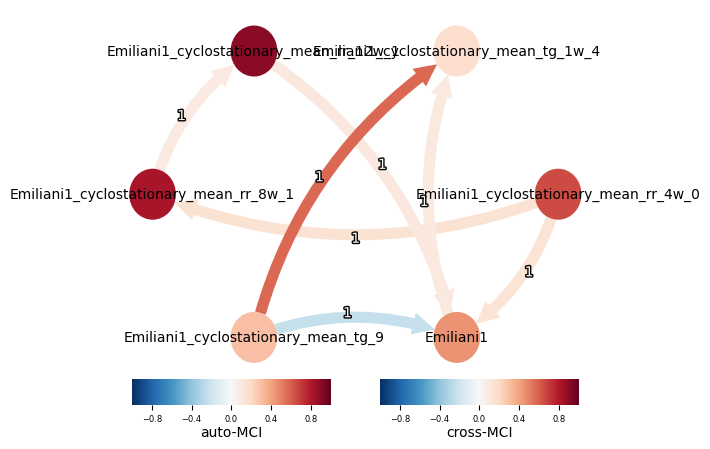

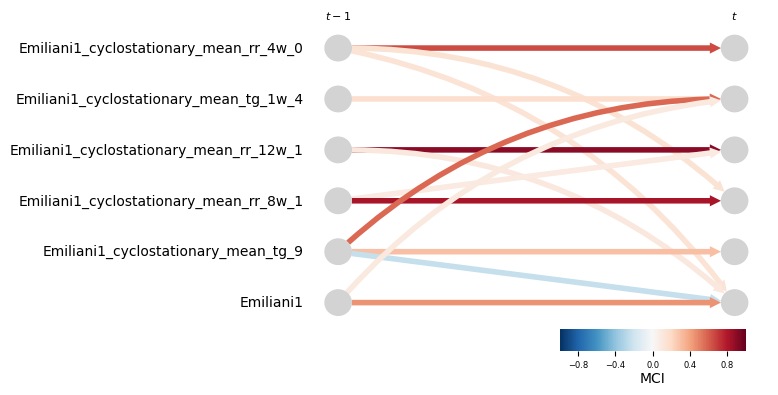

In [282]:
fullCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.663
        (2 -1): pval = 0.03631 | val =  0.083

    Variable 1 has 4 link(s):
        (1 -1): pval = 0.00000 | val =  0.373
        (4 -1): pval = 0.00000 | val =  0.366
        (0 -1): pval = 0.01664 | val = -0.095
        (2 -1): pval = 0.02615 | val = -0.088

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.662
        (4 -1): pval = 0.01768 | val = -0.094
        (0 -1): pval = 0.03150 | val =  0.085

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.642
        (1 -1): pval = 0.04365 | val = -0.080

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.407
        (5 -1): pval = 0.04791 | val = -0.078

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.428
        (4 -1): pval = 0.00000 | val = -0.317
        (0 -1): pval = 0.00000 | val =  0.194
        (2 -1): pval = 0.00571 | val = 

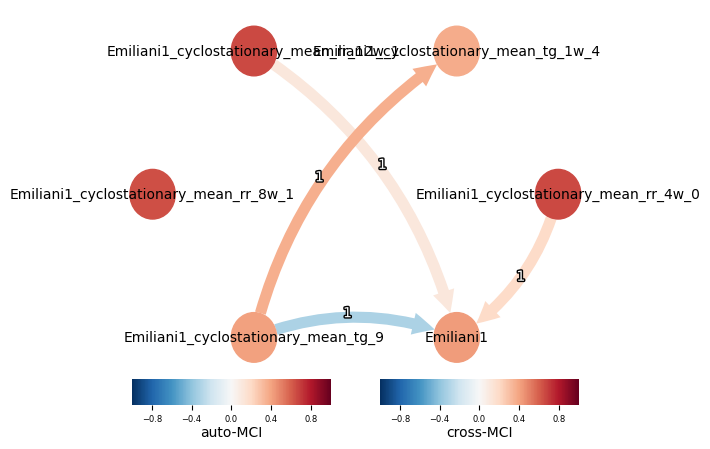

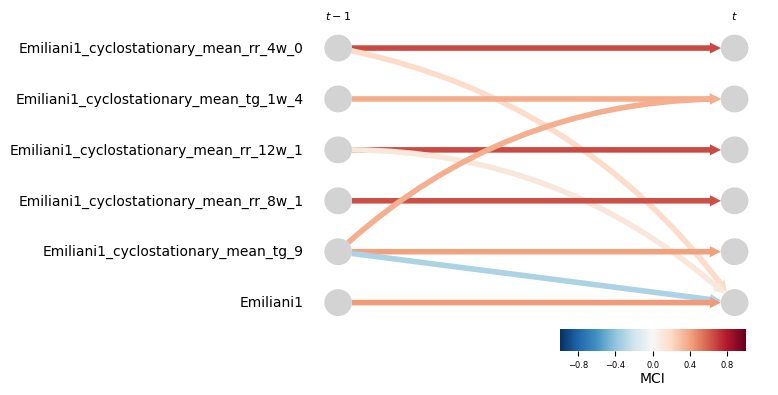

In [283]:
PCMCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.062
        (3 -1): pval = 0.00200 | val =  0.017
        (2 -1): pval = 0.03800 | val =  0.014

    Variable 1 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.070
        (1 -1): pval = 0.00000 | val =  0.027
        (2 -1): pval = 0.02800 | val =  0.007

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.154
        (3 -1): pval = 0.04800 | val =  0.010

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.101
        (0 -1): pval = 0.02400 | val =  0.016
        (1 -1): pval = 0.04000 | val =  0.006

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.023

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.036
        (4 -1): pval = 0.00000 | val =  0.018
        (0 -1): pval = 0.00800 | val =  0.017


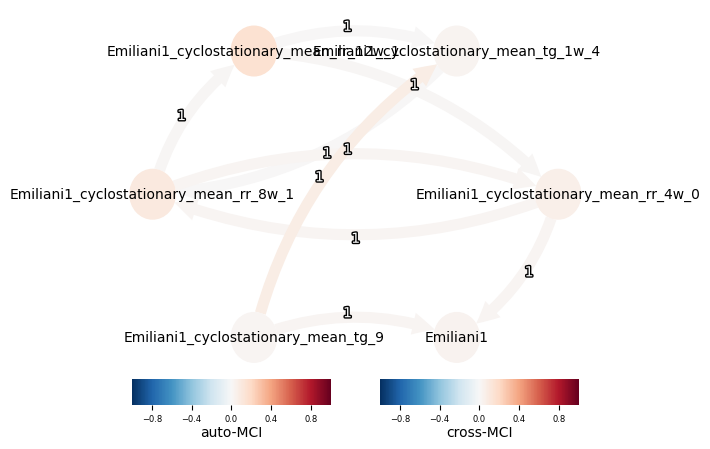

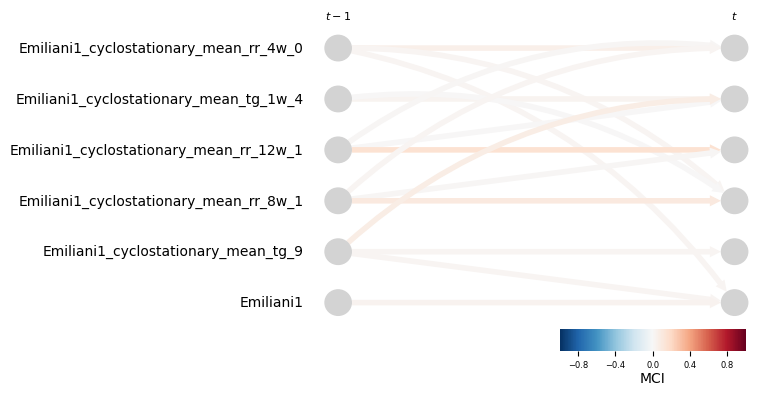

In [285]:
fullCI_singleBasin(df,tau=1,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (1 -1): pval = 0.01400 | val =  0.013
        (2 -1): pval = 0.02600 | val =  0.012

    Variable 1 has 4 link(s):
        (4 -1): pval = 0.00000 | val =  0.270
        (3 -1): pval = 0.03200 | val =  0.023
        (2 -1): pval = 0.03200 | val =  0.023
        (0 -1): pval = 0.01600 | val =  0.014

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.163
        (1 -1): pval = 0.02800 | val =  0.026

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.100
        (1 -1): pval = 0.03600 | val =  0.024
        (0 -1): pval = 0.01200 | val =  0.022
        (4 -1): pval = 0.05000 | val =  0.014

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.059
        (0 -1): pval = 0.03600 | val =  0.015

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.056
        (4 -1): pval = 0.00000 | val = 

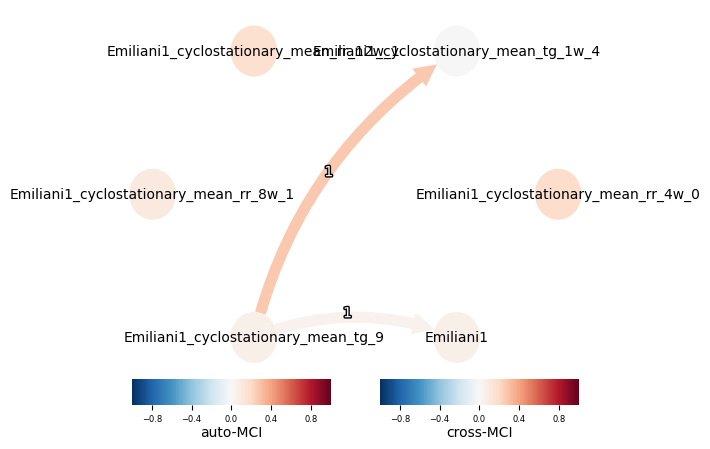

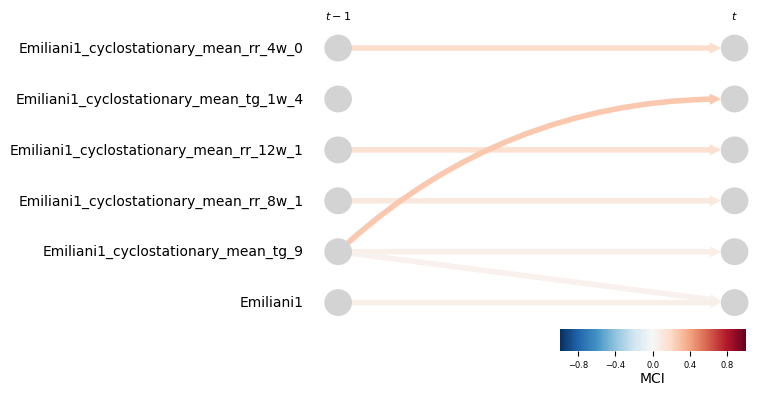

In [284]:
PCMCI_singleBasin(df,tau=1,cond_test=CMIknn())

### tau=2


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.535
        (2 -1): pval = 0.00434 | val =  0.114
        (2 -2): pval = 0.01850 | val = -0.094

    Variable 1 has 4 link(s):
        (1 -1): pval = 0.00000 | val =  0.365
        (4 -1): pval = 0.00000 | val =  0.334
        (4 -2): pval = 0.00000 | val = -0.321
        (2 -1): pval = 0.03848 | val = -0.083

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.688
        (5 -2): pval = 0.00187 | val =  0.124

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.632
        (0 -2): pval = 0.00110 | val =  0.131
        (3 -2): pval = 0.00326 | val = -0.118

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.220

    Variable 5 has 6 link(s):
        (5 -1): pval = 0.00000 | val =  0.420
        (4 -2): pval = 0.00159 | val =  0.126
        (1 -1): pval = 0.00279 | val = -0.120
        (0 -1): pval = 0.00883 | val = 

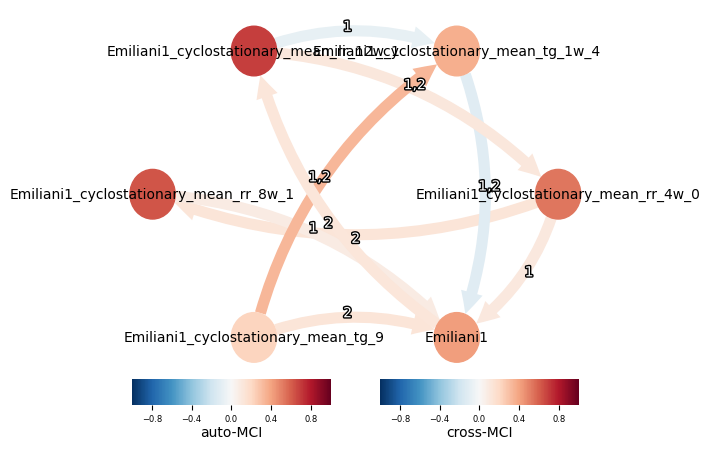

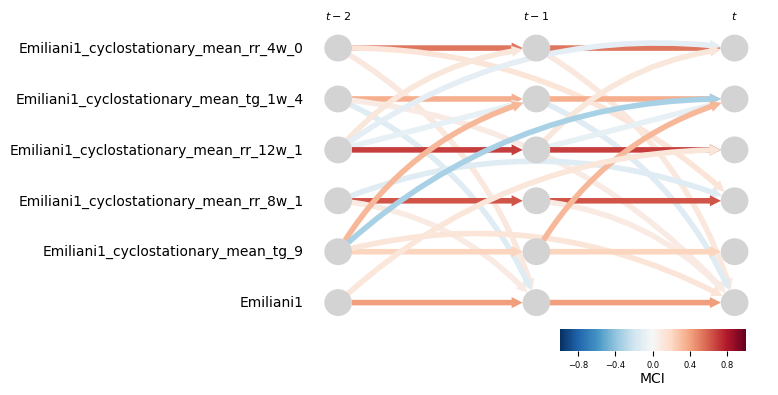

In [286]:
fullCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.029
        (3 -1): pval = 0.00000 | val =  0.012

    Variable 1 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.058

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.031

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.031

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.021
        (0 -1): pval = 0.03000 | val =  0.007

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.022
        (4 -1): pval = 0.00000 | val =  0.017
        (0 -1): pval = 0.00000 | val =  0.012


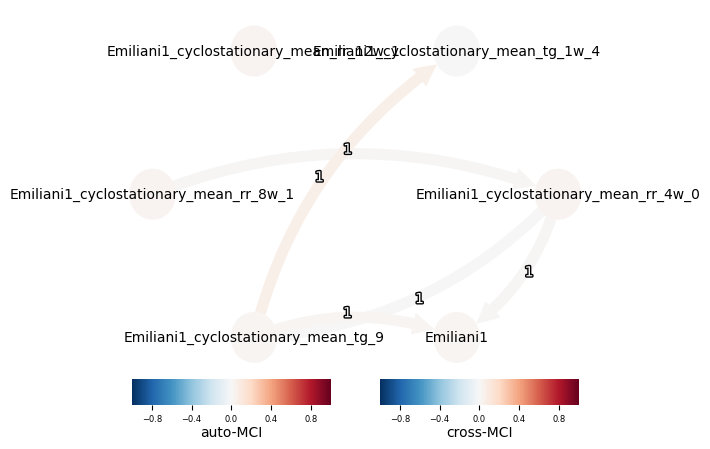

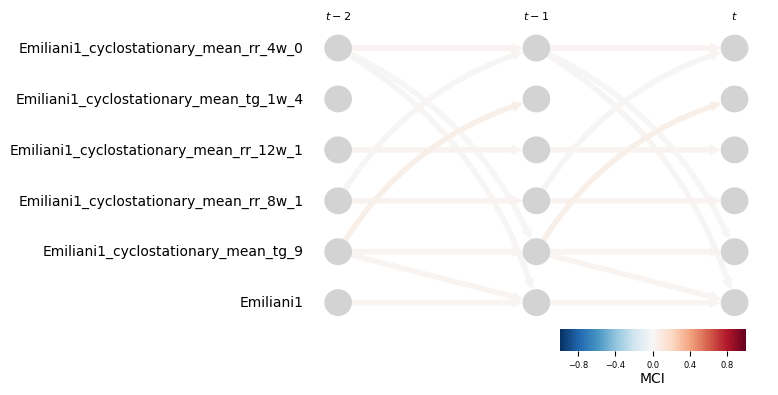

In [287]:
fullCI_singleBasin(df,tau=2,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.664
        (2 -1): pval = 0.03440 | val =  0.084

    Variable 1 has 6 link(s):
        (1 -1): pval = 0.00000 | val =  0.370
        (4 -1): pval = 0.00000 | val =  0.368
        (0 -1): pval = 0.01217 | val = -0.100
        (2 -2): pval = 0.01663 | val = -0.095
        (2 -1): pval = 0.02087 | val = -0.092
        (0 -2): pval = 0.03074 | val = -0.086

    Variable 2 has 6 link(s):
        (2 -1): pval = 0.00000 | val =  0.713
        (0 -2): pval = 0.01383 | val =  0.098
        (4 -1): pval = 0.01446 | val = -0.097
        (3 -1): pval = 0.01706 | val =  0.095
        (4 -2): pval = 0.03574 | val = -0.083
        (0 -1): pval = 0.04259 | val =  0.081

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.712
        (3 -2): pval = 0.01116 | val = -0.101
        (1 -1): pval = 0.03554 | val = -0.084

    Variable 4 has 2 link(s):
        (4 -1): pval = 0

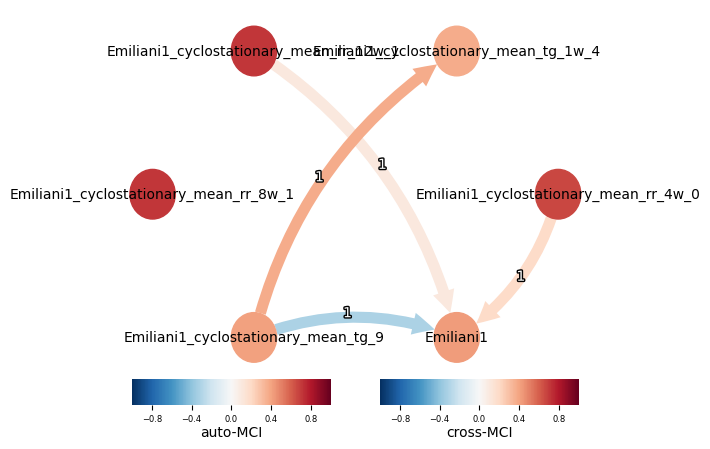

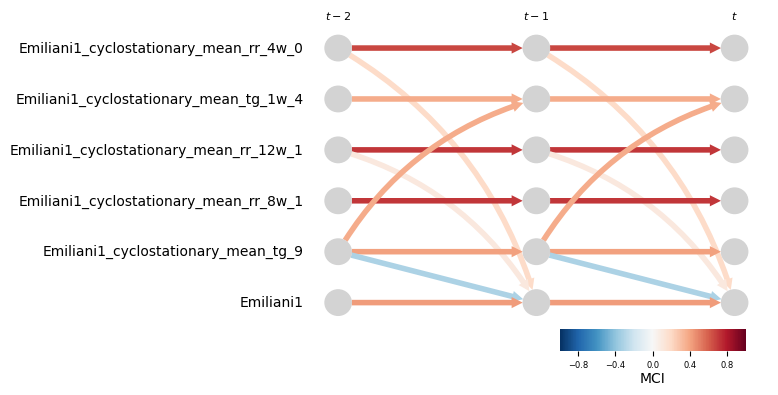

In [288]:
PCMCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (3 -1): pval = 0.01400 | val =  0.026
        (1 -1): pval = 0.01200 | val =  0.013
        (1 -2): pval = 0.04000 | val =  0.012
        (2 -1): pval = 0.03600 | val =  0.010

    Variable 1 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.273
        (2 -1): pval = 0.03800 | val =  0.025
        (0 -1): pval = 0.02000 | val =  0.014

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.164
        (1 -2): pval = 0.03800 | val =  0.021
        (0 -2): pval = 0.04400 | val =  0.013

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.102
        (0 -1): pval = 0.02000 | val =  0.022
        (4 -1): pval = 0.04800 | val =  0.015

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.061
        (0 -1): pval = 0.03200 | val =  0.014

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val = 

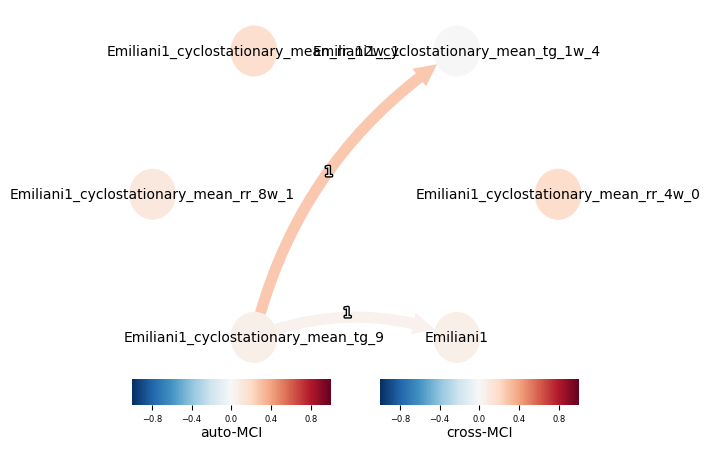

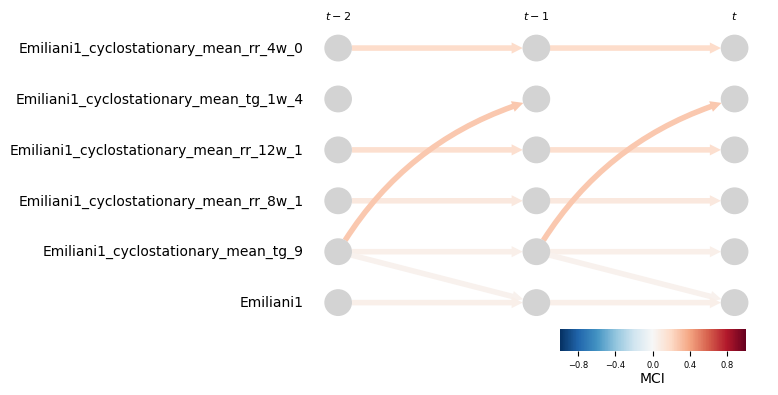

In [289]:
PCMCI_singleBasin(df,tau=2,cond_test=CMIknn())

### tau=3


## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (0 -1): pval = 0.00000 | val =  0.518
        (2 -1): pval = 0.00012 | val =  0.154
        (3 -3): pval = 0.00794 | val = -0.107
        (5 -2): pval = 0.03490 | val =  0.085

    Variable 1 has 6 link(s):
        (1 -1): pval = 0.00000 | val =  0.360
        (4 -2): pval = 0.00000 | val = -0.256
        (4 -1): pval = 0.00000 | val =  0.233
        (1 -3): pval = 0.00050 | val =  0.140
        (1 -2): pval = 0.00098 | val = -0.133
        (2 -1): pval = 0.03464 | val = -0.085

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.656
        (5 -2): pval = 0.04502 | val =  0.081

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.614
        (0 -3): pval = 0.00016 | val =  0.152

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.187

    Variable 5 has 6 link(s):
        (5 -1): pval = 0.00000 | val =  0.401
        (4 -2): pval = 0.00056 | val = 

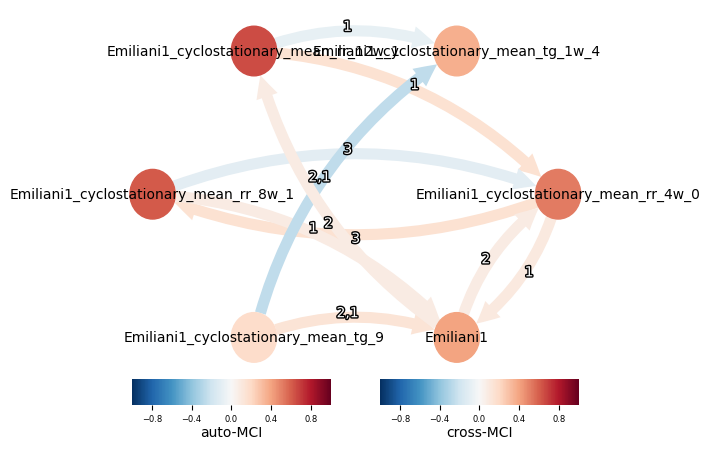

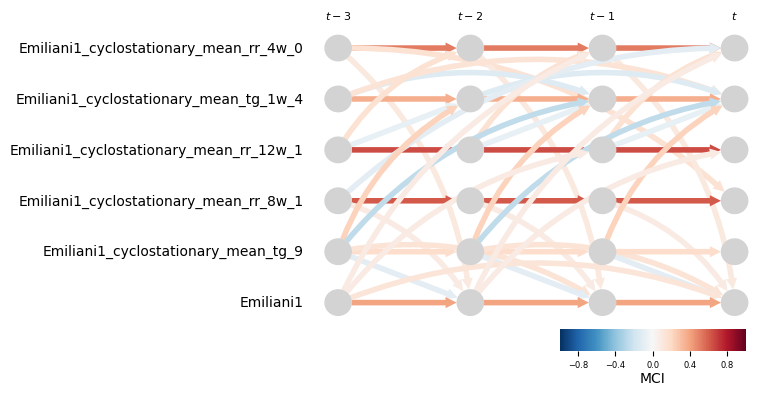

In [290]:
fullCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.023
        (3 -1): pval = 0.00000 | val =  0.010
        (5 -2): pval = 0.03600 | val =  0.008

    Variable 1 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.047
        (2 -1): pval = 0.02600 | val =  0.008
        (3 -1): pval = 0.00400 | val =  0.008

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.021

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.023

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.018

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.019
        (4 -1): pval = 0.00000 | val =  0.015
        (0 -1): pval = 0.05000 | val =  0.010
        (3 -1): pval = 0.02000 | val =  0.008


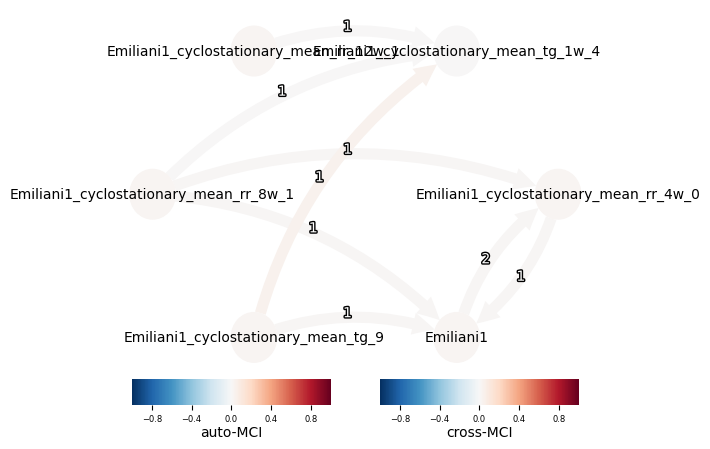

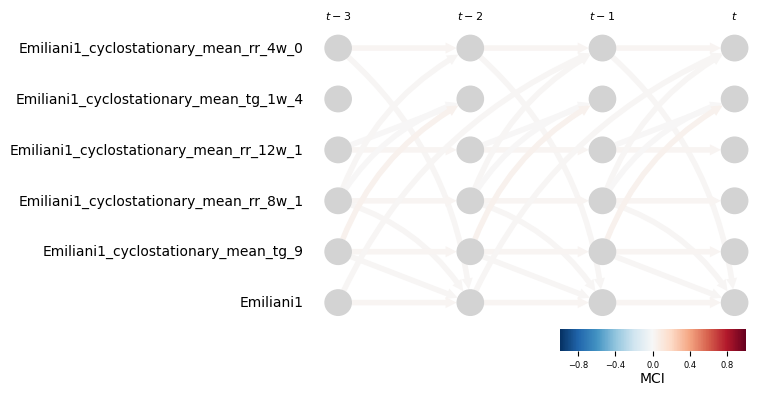

In [291]:
fullCI_singleBasin(df,tau=3,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.659
        (2 -1): pval = 0.02446 | val =  0.090
        (4 -3): pval = 0.03747 | val = -0.083

    Variable 1 has 8 link(s):
        (4 -1): pval = 0.00000 | val =  0.371
        (1 -1): pval = 0.00000 | val =  0.367
        (2 -1): pval = 0.01897 | val = -0.093
        (0 -3): pval = 0.01992 | val = -0.093
        (0 -2): pval = 0.02140 | val = -0.092
        (1 -3): pval = 0.02191 | val =  0.091
        (4 -3): pval = 0.04120 | val =  0.081
        (0 -1): pval = 0.04725 | val = -0.079

    Variable 2 has 9 link(s):
        (2 -1): pval = 0.00000 | val =  0.693
        (4 -1): pval = 0.01151 | val = -0.100
        (3 -1): pval = 0.01318 | val =  0.099
        (3 -3): pval = 0.01519 | val =  0.097
        (0 -3): pval = 0.01552 | val =  0.096
        (0 -2): pval = 0.01624 | val =  0.096
        (4 -3): pval = 0.02144 | val = -0.091
        (4 -2): pval = 0.03133 | val = -

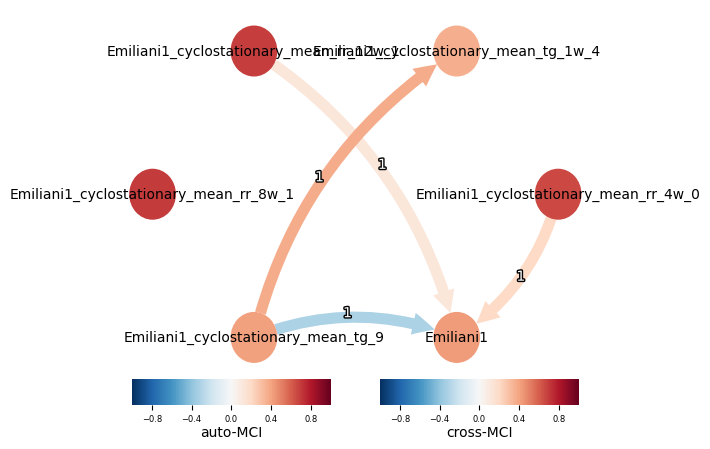

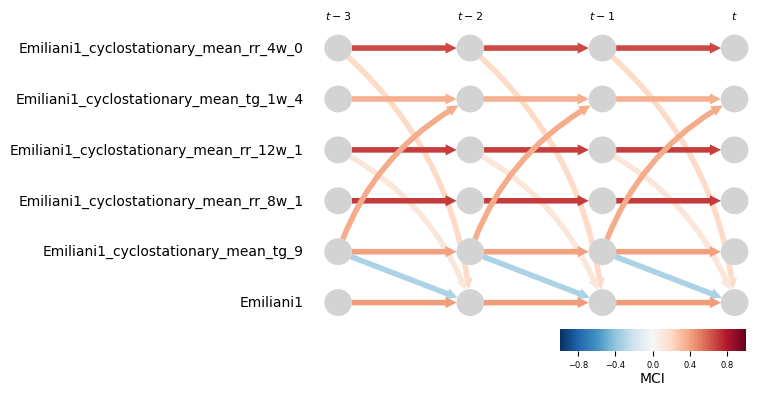

In [292]:
PCMCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (4 -3): pval = 0.01400 | val =  0.016
        (1 -1): pval = 0.01200 | val =  0.014
        (1 -2): pval = 0.03200 | val =  0.012
        (2 -1): pval = 0.03000 | val =  0.012
        (2 -3): pval = 0.02400 | val =  0.011

    Variable 1 has 5 link(s):
        (4 -1): pval = 0.00000 | val =  0.273
        (2 -1): pval = 0.02400 | val =  0.025
        (3 -1): pval = 0.01800 | val =  0.024
        (1 -3): pval = 0.02800 | val =  0.017
        (0 -1): pval = 0.01400 | val =  0.014

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.163
        (1 -1): pval = 0.03400 | val =  0.028
        (1 -2): pval = 0.04400 | val =  0.022
        (5 -3): pval = 0.05000 | val =  0.011

    Variable 3 has 5 link(s):
        (3 -1): pval = 0.00000 | val =  0.174
        (0 -1): pval = 0.02200 | val =  0.022
        (4 -1): pval = 0.03600 | val =  0.015
        (

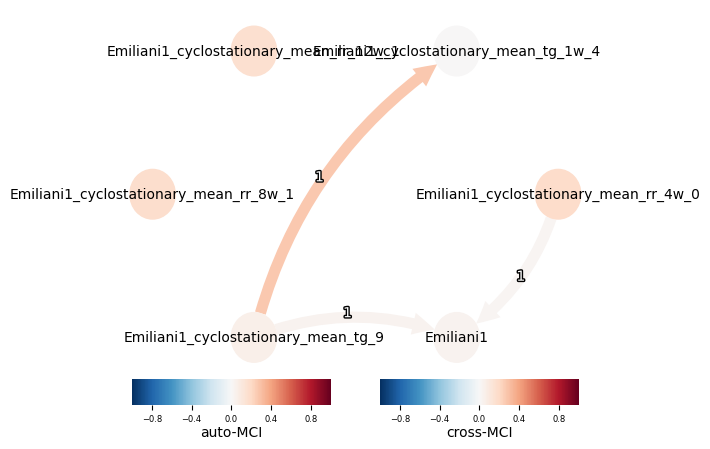

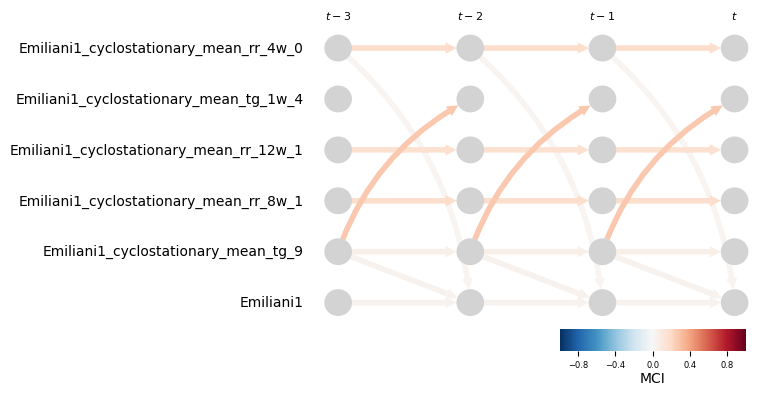

In [293]:
PCMCI_singleBasin(df,tau=3,cond_test=CMIknn())

## Regressions

In [20]:
## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
x_test = best5_CMI_fulldf_test.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],1),concatenate_past(x[:,1],1),concatenate_past(x[:,2],1),concatenate_past(x[:,3],1),concatenate_past(x[:,4],1)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],1),concatenate_past(x_test[:,1],1),concatenate_past(x_test[:,2],1),concatenate_past(x_test[:,3],1),concatenate_past(x_test[:,4],1)),axis=1)
y_lag1 = y[0:-1]
y_test_lag1 = y_test[0:-1]


In [19]:
def concatenate_past(x,lag):
    lag_x = x[lag-1:-1].reshape(-1,1)
    if lag<=1: return lag_x
        
    for i in range(lag-1):
        lag_x = np.concatenate((lag_x, x[lag-i-2:-i-2].reshape(-1,1)),axis=1)
        
    return lag_x

In [60]:
### tau = 1
print('####### tau=1 ########')

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
x_test = best5_CMI_fulldf_test.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],1),concatenate_past(x[:,1],1),concatenate_past(x[:,2],1),concatenate_past(x[:,3],1),concatenate_past(x[:,4],1)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],1),concatenate_past(x_test[:,1],1),concatenate_past(x_test[:,2],1),concatenate_past(x_test[:,3],1),concatenate_past(x_test[:,4],1)),axis=1)
y_lag1 = y[0:-1]
y_test_lag1 = y_test[0:-1]

reg_full = LinearRegression().fit(x_full, y[1:].reshape(-1,1))
print(f'Full regression, no target: {reg_full.score(x_full_test, y_test[1:].reshape(-1,1))}\n')

reg_full = LinearRegression().fit(x_full[:,[0,3,4]], y[1:].reshape(-1,1))
print(f'Regression with 0,3,4, no target: {reg_full.score(x_full_test[:,[0,3,4]], y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1, y[1:].reshape(-1,1))
print(f'Only target (baseline): {reg.score(y_test_lag1, y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,3,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,3,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,4 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,2,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,2,4 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,2,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 4 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,1,2,4 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,1,2,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')



####### tau=1 ########
Full regression, no target: 0.3380548652648995

Regression with 0,3,4, no target: 0.25441428371581787

Only target (baseline): 0.2756018203249285

Regression with 0,3,4 and target: 0.4441425000557896

Regression with 0,4 and target (PCMCI): 0.44229002972133336

Regression with 0,2,4 and target (PCMCI): 0.4540375055087965

Regression with 4 and target (PCMCI): 0.40300748702920774

Regression with 0,1,2,4 and target (PCMCI): 0.42742466108533517



In [71]:
print('####### tau=2 ########')
tau=2

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
x_test = best5_CMI_fulldf_test.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2 = np.concatenate((y[1:-1],y[:-2]),axis=1)
y_test_lag1_2 = np.concatenate((y_test[1:-1],y_test[:-2]),axis=1)

reg = LinearRegression().fit(x_full[:,[0,1]], y[2:].reshape(-1,1))
print(f'Regression with 0, no target: {reg.score(x_full_test[:,[0,1]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,2,3]], y[2:].reshape(-1,1))
print(f'Regression with 0,1, no target: {reg.score(x_full_test[:,[0,1,2,3]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,6,7,8,9]], y[2:].reshape(-1,1))
print(f'Regression with 0,3,4, no target: {reg.score(x_full_test[:,[0,1,6,7,8,9]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2, y[2:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2, y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0 and target: {reg.score(np.concatenate((x_full_test[:,[0,1]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,4,5,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,2,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,4,5,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,3,6,7,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,1,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,3,6,7,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,4,5,6,7,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,4,5,6,7,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 4 and target: {reg.score(np.concatenate((x_full_test[:,[8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')



####### tau=2 ########
Regression with 0, no target: 0.1480503778768928

Regression with 0,1, no target: 0.3588126415663496

Regression with 0,3,4, no target: 0.2573994198178893

Only target: 0.27767275761477295

Regression with 0,4 and target: 0.41772048023518105

Regression with 0 and target: 0.3665702699132376

Regression with 0,2,4 and target: 0.4287623492937648

Regression with 0,1,3,4 and target: 0.47451343118806877

Regression with 0,2,3,4 and target: 0.41877638324552235

Regression with 4 and target: 0.35788483323770925



In [90]:
print('####### tau=3 ########')
tau=3

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:5].values
x_test = best5_CMI_fulldf_test.iloc[1:,:5].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2_3 = np.concatenate((y[2:-1],y[1:-2],y[:-3]),axis=1)
y_test_lag1_2_3 = np.concatenate((y_test[2:-1],y_test[1:-2],y_test[:-3]),axis=1)

reg = LinearRegression().fit(x_full[:,[0,1,2,3,4,5,9,10,11]], y[3:].reshape(-1,1))
print(f'Regression with 0,1,3 no target: {reg.score(x_full_test[:,[0,1,2,3,4,5,9,10,11]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,2,3,4,5]], y[3:].reshape(-1,1))
print(f'Regression with 0,1 no target: {reg.score(x_full_test[:,[0,1,2,3,4,5]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,2]], y[3:].reshape(-1,1))
print(f'Regression with 0 no target: {reg.score(x_full_test[:,[0,1,2]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2_3, y[3:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2_3, y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 4 and target: {reg.score(np.concatenate((x_full_test[:,[12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,3,9,10,11,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,3,9,10,11,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[9,10,11,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 3,4 and target: {reg.score(np.concatenate((x_full_test[:,[9,10,11,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,3,4,5,9,10,11,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,1,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,3,4,5,9,10,11,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,6,7,8,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,2,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,6,7,8,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')



####### tau=3 ########
Regression with 0,1,3 no target: 0.35381696875423085

Regression with 0,1 no target: 0.3542339533299008

Regression with 0 no target: 0.13936709832577088

Only target: 0.26575741114516516

Regression with 4 and target: 0.41258910633455137

Regression with 0,3,4 and target: 0.4807521784946258

Regression with 3,4 and target: 0.4279670591689634

Regression with 0,4 and target: 0.4685343591076767

Regression with 0,1,3,4 and target: 0.47102569550914297

Regression with 0,2,4 and target: 0.47673668304938166



# Emiliani2

## forward and backward CMI, tau from 1 to 3

In [101]:
x = best5_CMI_fulldf_trainVal.iloc[1:,5:10].values
y = targets_df_trainVal.iloc[:-1,1].values.reshape(-1,1)


In [105]:
for tau in [1,2,3]:
    for k in  [20]:#[10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = forwardFeatureSelection(threshold=0.5,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
        
        #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.11901391474831369
CMI: 0.10702707885044788
CMI: 0.13076412066402907
CMI: 0.08632986949554182
CMI: 0.09560736399923565
Highest CMI score: 0.13076412066402907
Adding original feature: 2
CMI: 0.008422224532294492
CMI: 0.07112254733572373
CMI: 0.052413932916935885
CMI: 0.03646888696865527
Highest CMI score: 0.07112254733572373
Adding original feature: 1
CMI: 0.0026648083122663424
Highest CMI score: 0.0026648083122663424
Adding original feature: 0
CMI: 0.0030740308864705967
CMI: 0.003046845930942732
Highest CMI score: 0.0030740308864705967
Adding original feature: 3
CMI: 0.006140435594970017
Highest CMI score: 0.006140435594970017
Adding original feature: 4
[2, 1, 0, 3, 4]
###### tau=2 #########
CMI: 0.1028278930480794
CMI: 0.10575725026098928
CMI: 0.11955293638180267
CMI: 0.08910274972727822
CMI: 0.07482418462228528
Highest CMI score: 0.11955293638180267
Adding original feature: 2
CMI: 0.004549298878248786
CMI: 0.059829372830823194
CMI: 0.06308069807871024
CMI

In [107]:
for tau in [1,2,3]:
    for k in  [20]:#[10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = backwardFeatureSelection(threshold=0.000001,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
        
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.034448918160382425
CMI: 0.021769024229361
CMI: 0.02450692605492319
CMI: 0.014699508679849926
CMI: 0.0036915341265233714
[(4, 0.0036915341265233714), (3, 0.014699508679849926), (1, 0.021769024229361), (2, 0.02450692605492319), (0, 0.034448918160382425)]
[0, 1, 2, 3, 4]
###### tau=1 #########
CMI: 0.011441119719479975
CMI: 0.005890238224535604
CMI: 0.0011329391884088158
CMI: 0.0009620702543834958
[(3, -0.0012542864497611939), (4, 0.0009620702543834958), (2, 0.0011329391884088158), (1, 0.005890238224535604), (0, 0.011441119719479975)]
Removing original feature: 3
CMI: 0.015676559622688158
CMI: 0.028437777169424777
CMI: 0.006119206425207996
CMI: 0.0016241393251658354
[(3, 0.0016241393251658354), (2, 0.006119206425207996), (0, 0.015676559622688158), (1, 0.028437777169424777)]
[0, 1, 2, 4]
###### tau=1 #########
CMI: 0.011928291119543327
CMI: 0.008406728844447847
CMI: 0.005183008763109814
CMI: 0.006167620550497882
CMI: 0.006140435594970017
[(2, 0.005183008763109

[(0, -0.00636288544557248), (3, -0.0040494895686998544), (2, -0.0038097618599159666), (1, 0.054375412458453024)]
Removing original feature: 1
CMI: 0.05426452419131389
CMI: 0.007193064563976059
[(2, -0.006594373945386756), (1, 0.007193064563976059), (0, 0.05426452419131389)]
Removing original feature: 4
CMI: 0.06277440111417411
CMI: 0.03858259808529134
[(1, 0.03858259808529134), (0, 0.06277440111417411)]
[2, 3]


## forward and backward TE, tau from 1 to 3

In [110]:
x = best5_CMI_fulldf_trainVal.iloc[1:,5:10].values
y = targets_df_trainVal.iloc[:-1,1].values.reshape(-1,1)


In [111]:
for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_forwardFeatureSelection(threshold=100,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.017693139500937316
CMI: 0.029581481914530916
CMI: 0.05722680241683675
CMI: 0.008238527883267344
Highest CMI score: 0.05722680241683675
Adding original feature: 2
Highest CMI score: -0.0033872918159882914
[2]
###### tau=1 #########
CMI: 0.003917526603636756
CMI: 0.016523739914732827
CMI: 0.03797147104805504
CMI: 0.0013631919185652097
Highest CMI score: 0.03797147104805504
Adding original feature: 2
Highest CMI score: -0.002315665173603043
[2]
###### tau=1 #########
CMI: 0.005498578444216695
CMI: 0.024530656785057114
Highest CMI score: 0.024530656785057114
Adding original feature: 2
Highest CMI score: -0.00607027675746441
[2]
###### tau=1 #########
CMI: 0.01814208852302629
Highest CMI score: 0.01814208852302629
Adding original feature: 2
Highest CMI score: -0.008914016094707433
[2]
###### tau=1 #########
CMI: 0.018168152699946316
Highest CMI score: 0.018168152699946316
Adding original feature: 2
Highest CMI score: -0.013001693395586988
[2]
###### tau=2 #####

In [112]:
for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_backwardFeatureSelection(threshold=0.00000001,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.004174110616036564
[(4, -0.007740940880203495), (3, -0.006464446769084309), (0, -0.005022124617660828), (1, -0.003508908266726951), (2, 0.004174110616036564)]
Removing original feature: 4
CMI: 0.010738477896001297
[(0, -0.010566207300568564), (3, -0.006898192499913081), (1, -0.0029599242016082328), (2, 0.010738477896001297)]
Removing original feature: 0
CMI: 0.024441277053529387
[(2, -0.019651329595381517), (0, -0.009604016953494221), (1, 0.024441277053529387)]
Removing original feature: 3
CMI: 0.024258028686317545
[(0, -0.0033872918159882914), (1, 0.024258028686317545)]
Removing original feature: 1
[2]
###### tau=1 #########
[(4, -0.02142964285221699), (3, -0.015210501141077692), (0, -0.0105457243583863), (1, -0.009666352810379752), (2, -0.001847864342486405)]
Removing original feature: 4
CMI: 0.013032053911151698
[(3, -0.00901778857660046), (0, -0.0048358792136675155), (1, -0.0036747413672408302), (2, 0.013032053911151698)]
Removing original feature: 3
C

[(3, -0.01768186829873125), (0, -0.015002782944998405), (2, -0.007331864145433797), (1, -0.004109167982373735)]
Removing original feature: 4
[(2, -0.02104099736281337), (0, -0.017051627259385), (1, -0.0020644526542807073)]
Removing original feature: 3
[(0, -0.02068380547186205), (1, -0.008218644949055609)]
Removing original feature: 0
[2]
###### tau=3 #########
[(1, -0.020737503913016292), (0, -0.016008838852447332), (4, -0.012150473139759227), (2, -0.009165015335866333), (3, -0.004370992181279482)]
Removing original feature: 1
[(3, -0.020295886208625075), (0, -0.01797521658249565), (2, -0.009475071694977605), (1, -0.008465608981506667)]
Removing original feature: 4
[(2, -0.02146913079224394), (0, -0.01788963699857188), (1, -0.0042177370782037205)]
Removing original feature: 3
[(0, -0.02129247994337849), (1, -0.007454252816705836)]
Removing original feature: 0
[2]


## PCMCI and FullCI

In [318]:
df = pd.concat((best5_CMI_fulldf_trainVal.iloc[1:,5:10].reset_index(drop=True),targets_df_trainVal.iloc[:-1,1].reset_index(drop=True)),axis=1)
df


Emiliani2_cyclostationary_mean_tg_1w_4  \
0                                  0.237307   
1                                 -0.259989   
2                                 -0.565851   
3                                 -0.187005   
4                                  0.395576   
..                                      ...   
633                                2.050920   
634                                1.776750   
635                                1.963611   
636                                1.734032   
637                                1.748151   

     Emiliani2_cyclostationary_mean_rr_4w_3  \
0                                  0.849889   
1                                  0.518355   
2                                  0.239497   
3                                  0.696217   
4                                  0.443807   
..                                      ...   
633                                1.182447   
634                                1.931919   
635                                2.777644   
636                                2.563059   
637                                0.244175   

     Emiliani2_cyclostationary_mean_tg_4  \
0                               0.294888   
1                              -1.191392   
2                               0.067063   
3                              -0.894857   
4                               0.959532   
..                                   ...   
633                             0.848215   
634                             1.300383   
635                             1.044000   
636                             1.124935   
637                             1.295160   

     Emiliani2_cyclostationary_mean_rr_8w_0  \
0                                  2.460299   
1                                  1.657472   
2                                  1.600489   
3                                  1.249495   
4                                  0.984473   
..                                      ...   
633                                1.287369   
634                                1.500711   
635                                1.878066   
636                                1.799993   
637                                1.036511   

     Emiliani2_cyclostationary_mean_rr_12w_1  Emiliani2  
0                                   1.146518  -1.339879  
1                                   0.697926   0.402993  
2                                   0.578318   0.282703  
3                                   0.843396  -0.030490  
4                                   0.647103   0.451097  
..                                       ...        ...  
633                                 0.181394  -0.124038  
634                                 0.244831  -0.229575  
635                                 0.317723   0.038989  
636                                 0.278011   0.020677  
637                                 0.081538  -0.444088  

[638 rows x 6 columns]

### Tau = 1


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (2 -1): pval = 0.00000 | val =  0.603
        (4 -1): pval = 0.00035 | val = -0.142
        (0 -1): pval = 0.00108 | val =  0.130
        (3 -1): pval = 0.01413 | val =  0.098
        (1 -1): pval = 0.01773 | val =  0.094

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val =  0.671
        (3 -1): pval = 0.04764 | val =  0.079

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.239
        (4 -1): pval = 0.00474 | val = -0.112

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.772
        (1 -1): pval = 0.00061 | val =  0.136
        (2 -1): pval = 0.00250 | val = -0.120
        (0 -1): pval = 0.00750 | val =  0.106

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.829
        (3 -1): pval = 0.00000 | val =  0.228

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.610
        (2 -1): pval = 0.00000 | val = 

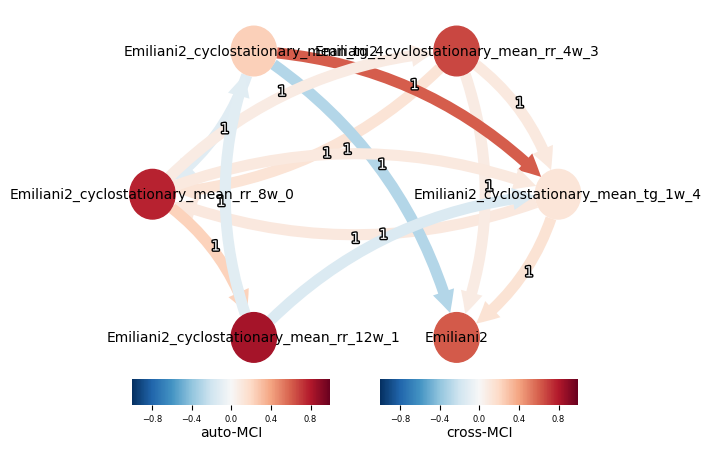

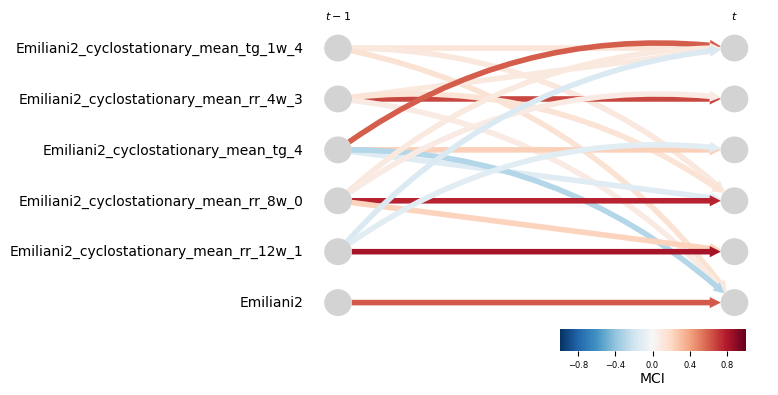

In [321]:
fullCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (0 -1): pval = 0.00000 | val =  0.312
        (2 -1): pval = 0.00000 | val =  0.254
        (3 -1): pval = 0.01760 | val = -0.094
        (1 -1): pval = 0.02092 | val = -0.092

    Variable 1 has 3 link(s):
        (1 -1): pval = 0.00000 | val =  0.662
        (3 -1): pval = 0.02543 | val =  0.089
        (2 -1): pval = 0.02668 | val = -0.088

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.353
        (5 -1): pval = 0.01242 | val = -0.099
        (4 -1): pval = 0.02135 | val = -0.091

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.650
        (1 -1): pval = 0.02071 | val =  0.092

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.639
        (3 -1): pval = 0.00002 | val =  0.169

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.488
        (2 -1): pval = 0.00000 | val = -0.199
        (1 -1): pval = 0.00020 | val = 

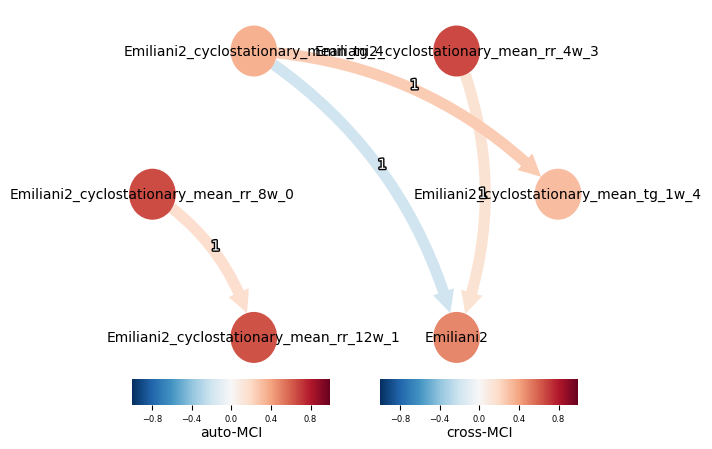

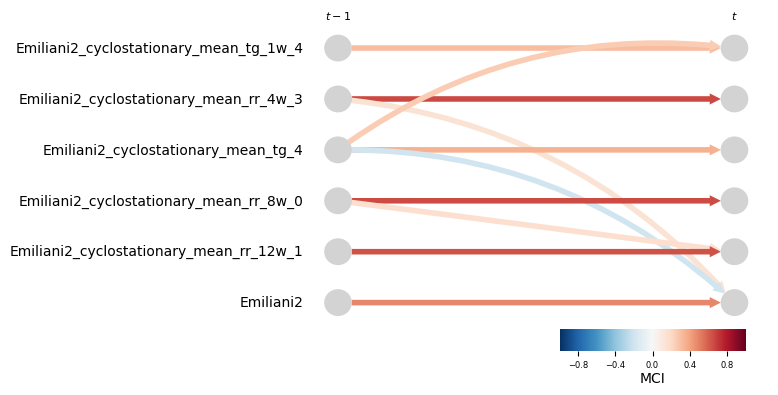

In [322]:
PCMCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.076
        (0 -1): pval = 0.01600 | val =  0.025

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.075

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.021

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.069
        (1 -1): pval = 0.00200 | val =  0.016

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.102
        (3 -1): pval = 0.00000 | val =  0.020

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.064
        (2 -1): pval = 0.00000 | val =  0.021
        (1 -1): pval = 0.02200 | val =  0.013


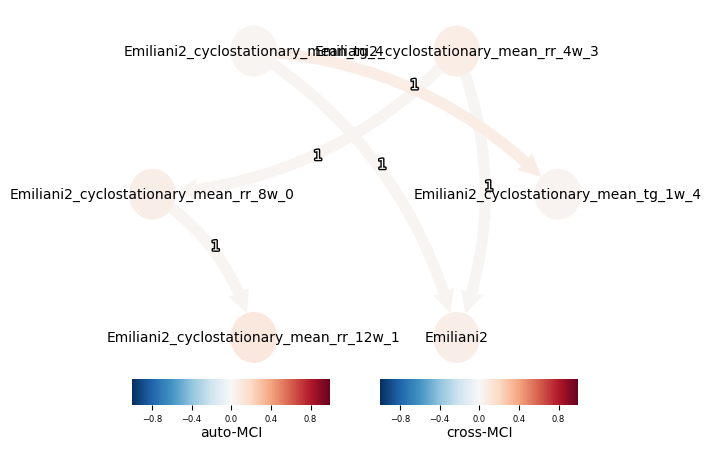

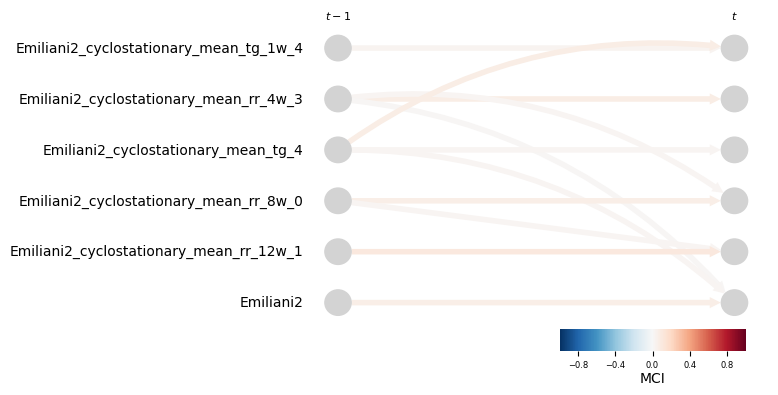

In [323]:
fullCI_singleBasin(df,tau=1,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (2 -1): pval = 0.00000 | val =  0.113
        (4 -1): pval = 0.03600 | val =  0.029
        (3 -1): pval = 0.02200 | val =  0.022
        (0 -1): pval = 0.00000 | val =  0.018
        (1 -1): pval = 0.01600 | val =  0.007

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.181

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.055
        (3 -1): pval = 0.04600 | val =  0.012

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.093
        (2 -1): pval = 0.04800 | val =  0.009

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.066
        (1 -1): pval = 0.03800 | val =  0.020
        (3 -1): pval = 0.00200 | val =  0.018

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.043
        (2 -1): pval = 0.00000 | val =  0.038
        (1 -1): pval = 0.01400 | val =  0.025
        (4 -1): pval = 0.02600 | val = 

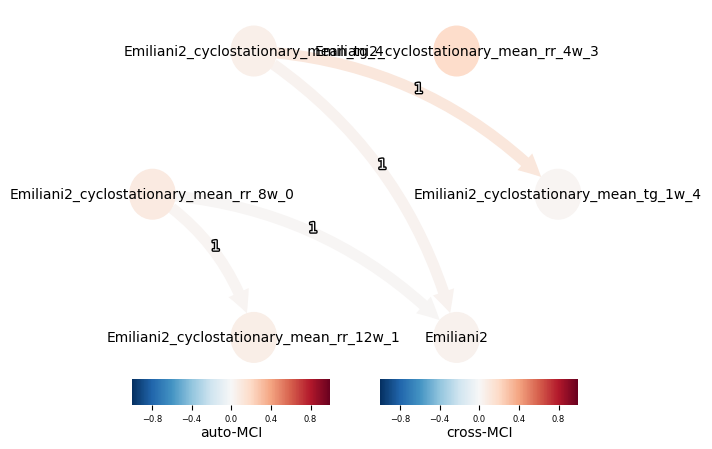

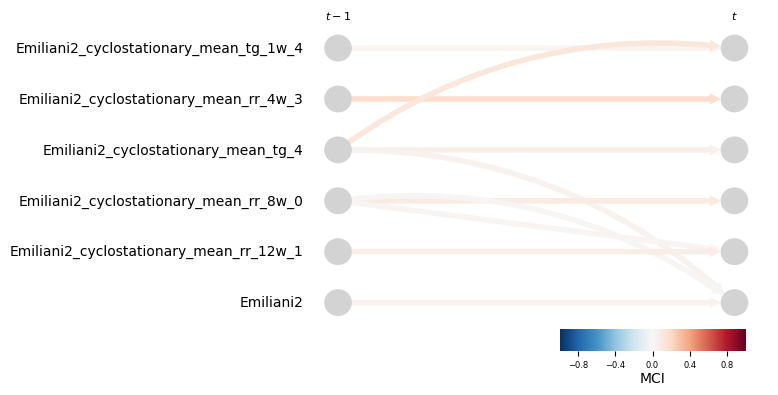

In [324]:
PCMCI_singleBasin(df,tau=1,cond_test=CMIknn())

### tau=2


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (0 -1): pval = 0.00000 | val =  0.280
        (2 -2): pval = 0.00000 | val = -0.256
        (2 -1): pval = 0.00000 | val =  0.235
        (1 -1): pval = 0.01286 | val =  0.100
        (1 -2): pval = 0.03710 | val = -0.084

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val =  0.519
        (4 -2): pval = 0.03193 | val = -0.086

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00001 | val =  0.178
        (1 -1): pval = 0.01718 | val =  0.095

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.606
        (1 -2): pval = 0.00449 | val =  0.114
        (2 -1): pval = 0.01678 | val = -0.096
        (3 -2): pval = 0.02248 | val = -0.091

    Variable 4 has 4 link(s):
        (4 -1): pval = 0.00000 | val =  0.613
        (4 -2): pval = 0.00070 | val = -0.136
        (3 -1): pval = 0.02292 | val =  0.091
        (5 -2): pval = 0.04234 | val =  0.081

    Variable 5 has 6 li

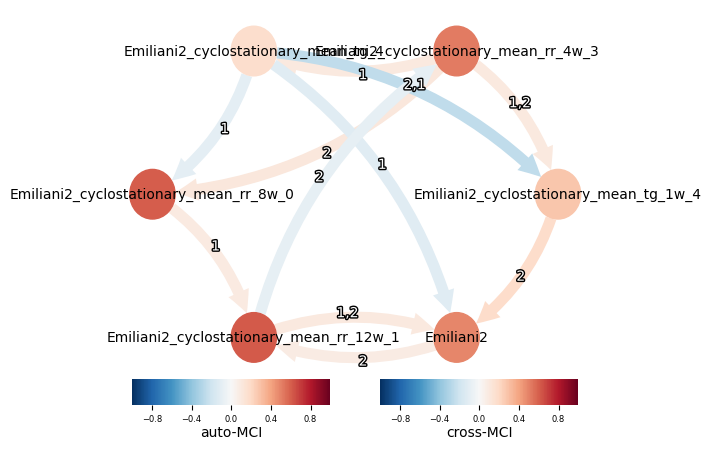

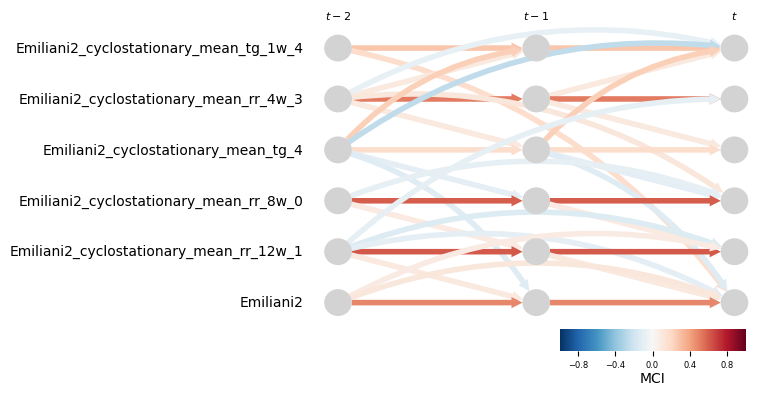

In [325]:
fullCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.060

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.035

    Variable 2 has 0 link(s):

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.025

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.021

    Variable 5 has 2 link(s):
        (5 -1): pval = 0.00000 | val =  0.028
        (2 -1): pval = 0.00400 | val =  0.017


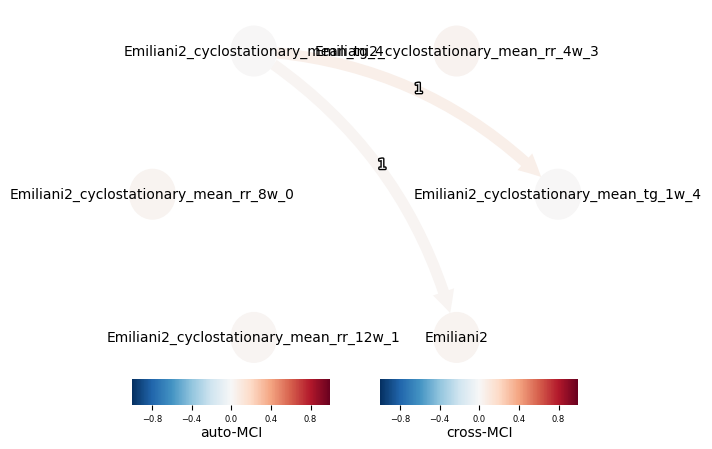

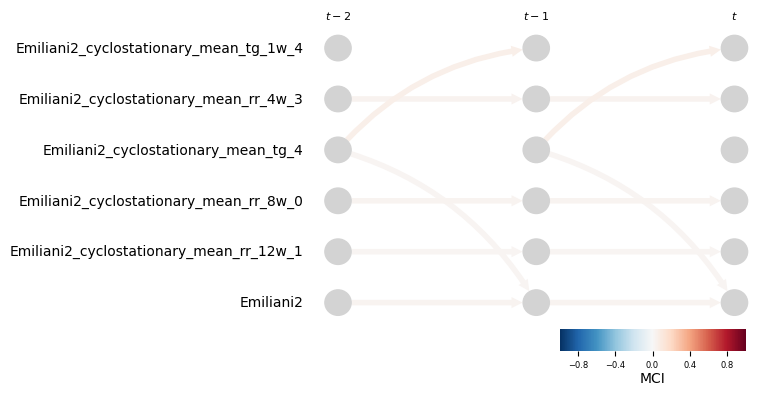

In [326]:
fullCI_singleBasin(df,tau=2,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (0 -1): pval = 0.00000 | val =  0.312
        (2 -1): pval = 0.00000 | val =  0.254
        (3 -1): pval = 0.01985 | val = -0.092
        (1 -1): pval = 0.02147 | val = -0.091
        (5 -2): pval = 0.04429 | val = -0.080

    Variable 1 has 3 link(s):
        (1 -1): pval = 0.00000 | val =  0.663
        (2 -1): pval = 0.02543 | val = -0.089
        (3 -1): pval = 0.02703 | val =  0.088

    Variable 2 has 7 link(s):
        (2 -1): pval = 0.00000 | val =  0.354
        (5 -1): pval = 0.01268 | val = -0.099
        (4 -2): pval = 0.01294 | val = -0.099
        (3 -2): pval = 0.01425 | val = -0.097
        (4 -1): pval = 0.02202 | val = -0.091
        (1 -2): pval = 0.04598 | val = -0.079
        (5 -2): pval = 0.04804 | val = -0.079

    Variable 3 has 5 link(s):
        (3 -1): pval = 0.00000 | val =  0.649
        (1 -2): pval = 0.01166 | val =  0.100
        (4 -2): pval = 0.03116 | val = -0.086
        (

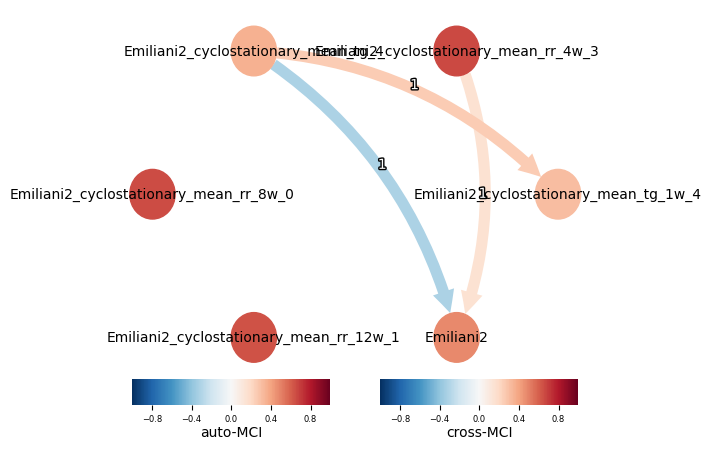

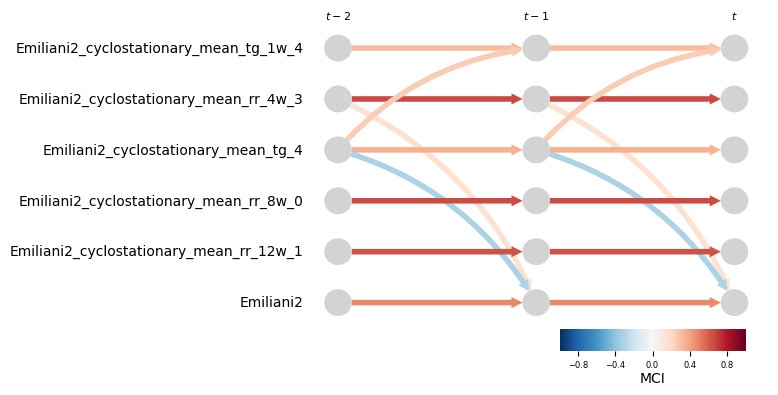

In [327]:
PCMCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.278
        (4 -1): pval = 0.04200 | val =  0.028
        (3 -1): pval = 0.02800 | val =  0.022
        (1 -1): pval = 0.03200 | val =  0.007

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.182

    Variable 2 has 6 link(s):
        (2 -1): pval = 0.00000 | val =  0.056
        (3 -1): pval = 0.01200 | val =  0.022
        (4 -2): pval = 0.01600 | val =  0.021
        (1 -1): pval = 0.01200 | val =  0.019
        (3 -2): pval = 0.03600 | val =  0.016
        (2 -2): pval = 0.01600 | val =  0.014

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.094
        (1 -2): pval = 0.04800 | val =  0.017
        (2 -1): pval = 0.03600 | val =  0.009

    Variable 4 has 6 link(s):
        (4 -1): pval = 0.00000 | val =  0.067
        (3 -2): pval = 0.03200 | val =  0.029
        (1 -2): pval = 0.04200 | val =  0.021
        (1 -1): pval = 0

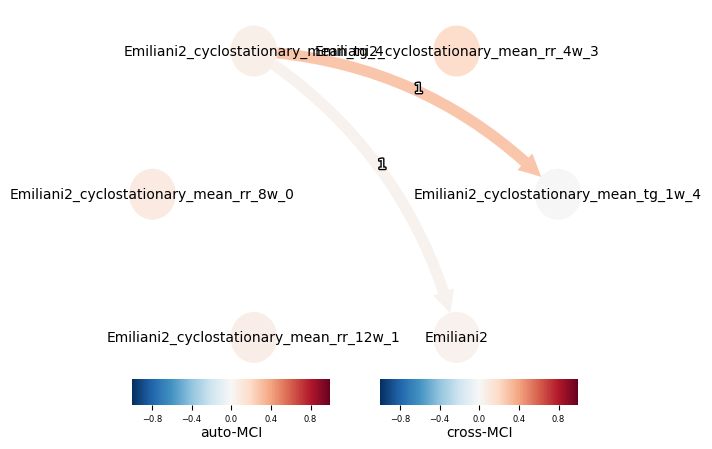

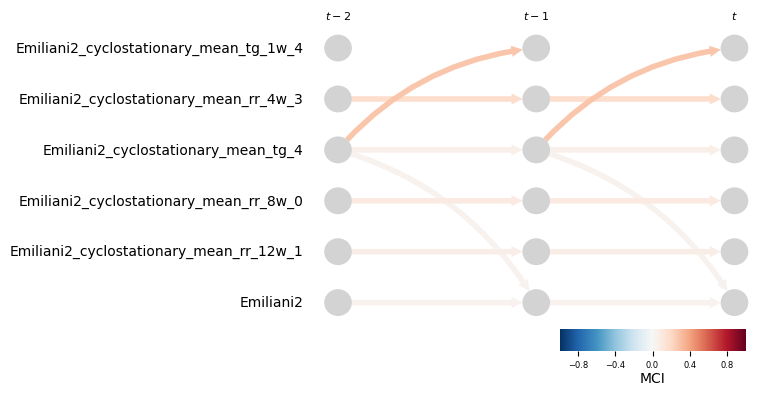

In [328]:
PCMCI_singleBasin(df,tau=2,cond_test=CMIknn())

### tau=3


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.248
        (2 -2): pval = 0.00000 | val = -0.205
        (0 -2): pval = 0.01429 | val = -0.099
        (2 -1): pval = 0.01773 | val =  0.096
        (1 -1): pval = 0.02608 | val =  0.090
        (0 -3): pval = 0.02722 | val =  0.089

    Variable 1 has 7 link(s):
        (1 -1): pval = 0.00000 | val =  0.517
        (2 -1): pval = 0.01108 | val = -0.102
        (5 -2): pval = 0.01322 | val =  0.100
        (3 -3): pval = 0.02208 | val = -0.092
        (0 -1): pval = 0.02478 | val =  0.091
        (4 -1): pval = 0.03494 | val =  0.085
        (5 -3): pval = 0.04502 | val = -0.081

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.01660 | val =  0.097
        (1 -1): pval = 0.03099 | val =  0.087

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.593
        (1 -3): pval = 0.00009 | val =  0.157

    Variable 4 has 4 link(s):
        (4 -1): pval = 0

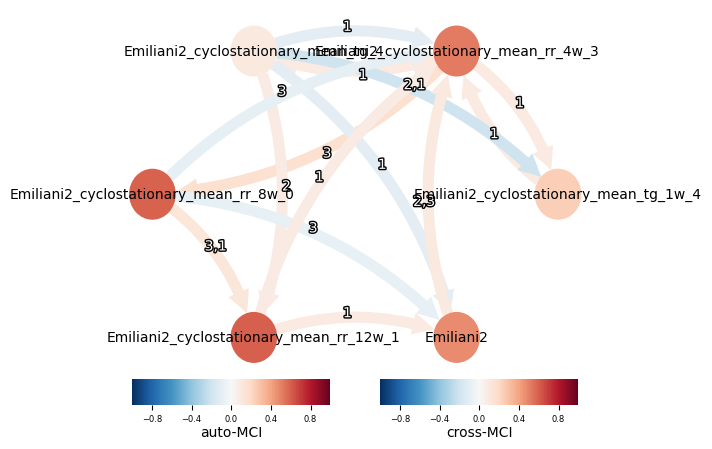

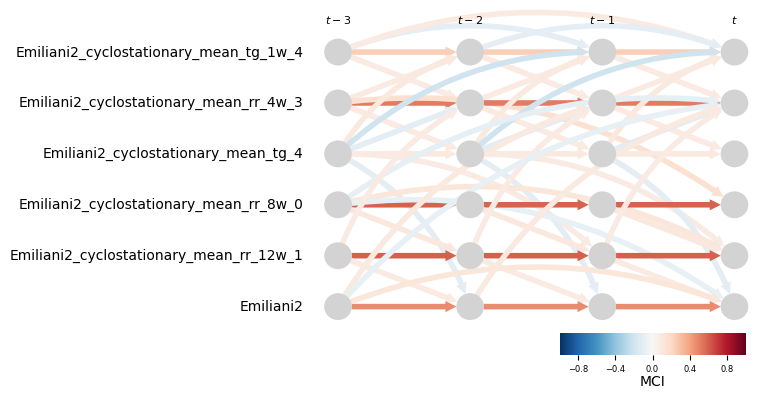

In [329]:
fullCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.048

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.028

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00400 | val =  0.014
        (1 -2): pval = 0.01800 | val =  0.007

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.020

    Variable 4 has 1 link(s):
        (4 -1): pval = 0.00000 | val =  0.014

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.022
        (2 -1): pval = 0.00400 | val =  0.014
        (5 -3): pval = 0.02400 | val =  0.011


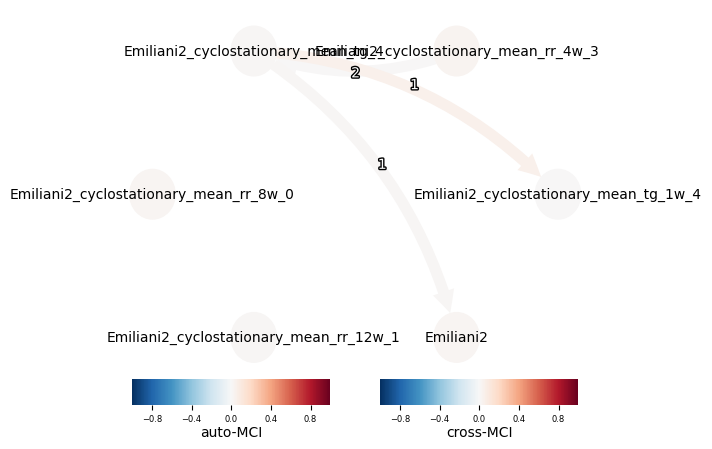

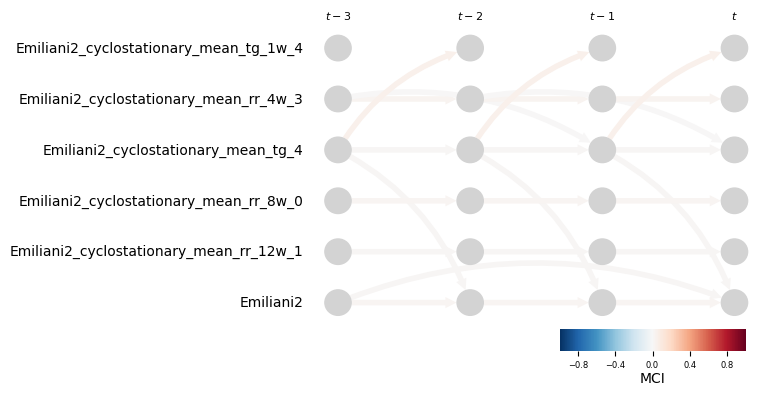

In [330]:
fullCI_singleBasin(df,tau=3,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.309
        (2 -1): pval = 0.00000 | val =  0.240
        (3 -1): pval = 0.01666 | val = -0.095
        (1 -1): pval = 0.02044 | val = -0.092
        (0 -3): pval = 0.03442 | val =  0.084
        (5 -2): pval = 0.04480 | val = -0.080

    Variable 1 has 3 link(s):
        (1 -1): pval = 0.00000 | val =  0.663
        (3 -1): pval = 0.02419 | val =  0.090
        (2 -1): pval = 0.02678 | val = -0.088

    Variable 2 has 10 link(s):
        (2 -1): pval = 0.00000 | val =  0.345
        (3 -2): pval = 0.01039 | val = -0.102
        (4 -2): pval = 0.01150 | val = -0.101
        (5 -1): pval = 0.01229 | val = -0.100
        (4 -1): pval = 0.01934 | val = -0.093
        (1 -3): pval = 0.02093 | val = -0.092
        (0 -3): pval = 0.02450 | val =  0.090
        (3 -3): pval = 0.03246 | val = -0.085
        (1 -2): pval = 0.04364 | val = -0.080
        (5 -2): pval = 0.04791 | val = 

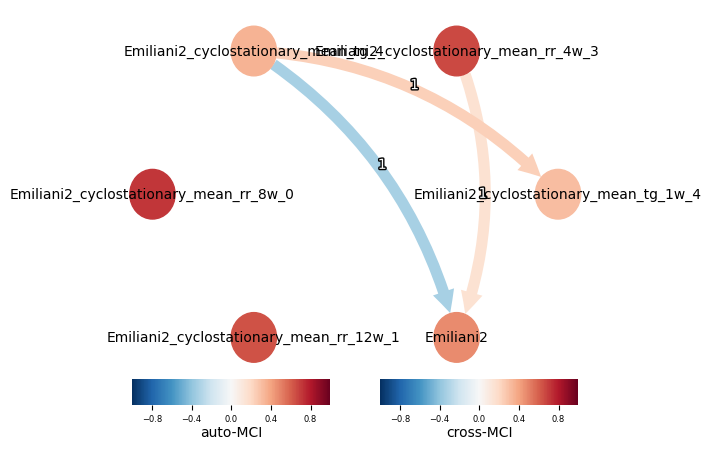

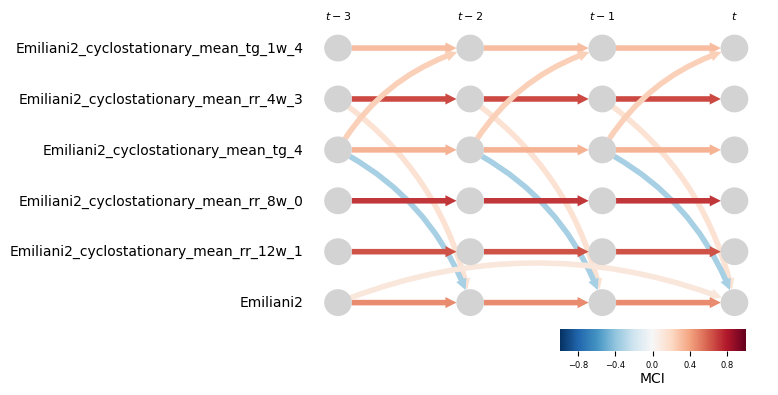

In [331]:
PCMCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (2 -1): pval = 0.00000 | val =  0.215
        (4 -1): pval = 0.02000 | val =  0.029
        (3 -1): pval = 0.01400 | val =  0.023
        (0 -1): pval = 0.01200 | val =  0.023
        (0 -2): pval = 0.01600 | val =  0.012
        (0 -3): pval = 0.01000 | val =  0.009

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val =  0.181
        (0 -2): pval = 0.04800 | val =  0.009

    Variable 2 has 7 link(s):
        (2 -1): pval = 0.00000 | val =  0.056
        (1 -1): pval = 0.01200 | val =  0.020
        (4 -3): pval = 0.02200 | val =  0.017
        (3 -2): pval = 0.02600 | val =  0.016
        (5 -3): pval = 0.03800 | val =  0.013
        (3 -1): pval = 0.03200 | val =  0.013
        (0 -2): pval = 0.04200 | val =  0.009

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.091
        (1 -3): pval = 0.02200 | val =  0.013
        (5 -3): pval = 0.02200 | val =  0.011
        (

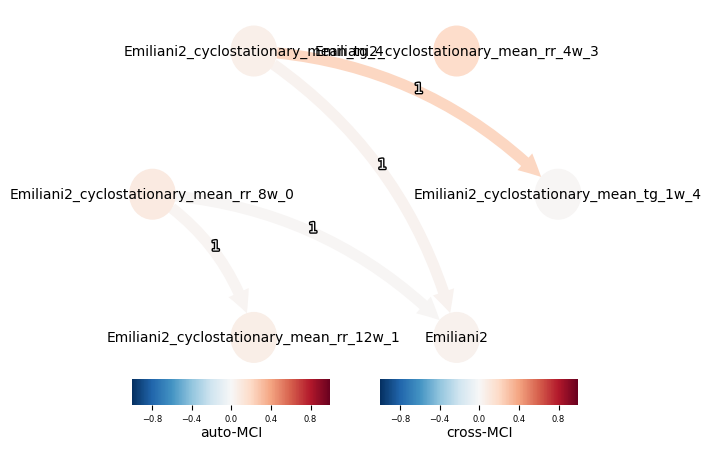

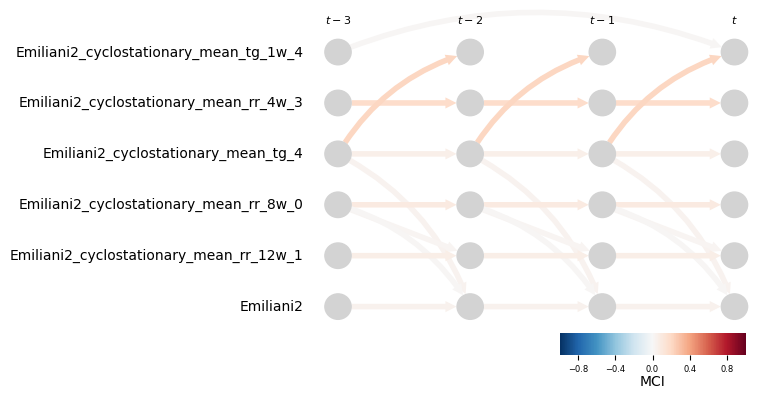

In [332]:
PCMCI_singleBasin(df,tau=3,cond_test=CMIknn())

## Regressions

In [132]:
### tau = 1
print('####### tau=1 ########')

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,5:10].values
x_test = best5_CMI_fulldf_test.iloc[1:,5:10].values
y = targets_df_trainVal.iloc[:-1,1].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,1].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],1),concatenate_past(x[:,1],1),concatenate_past(x[:,2],1),concatenate_past(x[:,3],1),concatenate_past(x[:,4],1)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],1),concatenate_past(x_test[:,1],1),concatenate_past(x_test[:,2],1),concatenate_past(x_test[:,3],1),concatenate_past(x_test[:,4],1)),axis=1)
y_lag1 = y[0:-1]
y_test_lag1 = y_test[0:-1]

reg_full = LinearRegression().fit(x_full, y[1:].reshape(-1,1))
print(f'Full regression, no target: {reg_full.score(x_full_test, y_test[1:].reshape(-1,1))}\n')

reg_full = LinearRegression().fit(x_full[:,[0,1,2]], y[1:].reshape(-1,1))
print(f'Regression with 0,1,2, no target: {reg_full.score(x_full_test[:,[0,1,2]], y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1, y[1:].reshape(-1,1))
print(f'Only target (baseline): {reg.score(y_test_lag1, y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 2 and target: {reg.score(np.concatenate((x_full_test[:,[2]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,1,2 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,2]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,2 and target: {reg.score(np.concatenate((x_full_test[:,[0,2]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1,2,3]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1,2,3 and target: {reg.score(np.concatenate((x_full_test[:,[1,2,3]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1,2,3,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1,2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[1,2,3,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')



####### tau=1 ########
Full regression, no target: 0.23657564198032144

Regression with 0,1,2, no target: 0.23251101367461002

Only target (baseline): 0.2918751155532263

Regression with 2 and target: 0.4265542649826599

Regression with 0,1,2 and target: 0.4117878108595462

Regression with 0,2 and target: 0.39831929990276826

Regression with 1,2,3 and target: 0.43377257214097475

Regression with 1,2,3,4 and target: 0.42586061973649103



In [148]:
print('####### tau=2 ########')
tau=2

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,5:10].values
x_test = best5_CMI_fulldf_test.iloc[1:,5:10].values
y = targets_df_trainVal.iloc[:-1,1].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,1].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2 = np.concatenate((y[1:-1],y[:-2]),axis=1)
y_test_lag1_2 = np.concatenate((y_test[1:-1],y_test[:-2]),axis=1)

reg = LinearRegression().fit(x_full[:,[2,3,4,5,6,7,8,9]], y[2:].reshape(-1,1))
print(f'Regression with 1,2,3,4 no target: {reg.score(x_full_test[:,[2,3,4,5,6,7,8,9]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[2,3,4,5,6,7]], y[2:].reshape(-1,1))
print(f'Regression with 1,2,3 no target: {reg.score(x_full_test[:,[2,3,4,5,6,7]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[2,3,4,5,8,9]], y[2:].reshape(-1,1))
print(f'Regression with 1,2,4 no target: {reg.score(x_full_test[:,[2,3,4,5,8,9]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2, y[2:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2, y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[4,5]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 2 and target: {reg.score(np.concatenate((x_full_test[:,[4,5]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,4,5,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,2,4 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,4,5,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,3,4,5,6,7]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,1,2,3 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,3,4,5,6,7]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3,4,5]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1,2 and target: {reg.score(np.concatenate((x_full_test[:,[2,3,4,5]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3,4,5,6,7,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1,2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[2,3,4,5,6,7,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')



####### tau=2 ########
Regression with 1,2,3,4 no target: 0.23823963722704056

Regression with 1,2,3 no target: 0.26624355686971934

Regression with 1,2,4 no target: 0.2379389779282347

Only target: 0.29786829314340846

Regression with 2 and target: 0.4199706454950529

Regression with 0,2,4 and target: 0.45083928076788804

Regression with 0,1,2,3 and target: 0.4691786267266679

Regression with 1,2 and target: 0.4245491687873191

Regression with 1,2,3,4 and target: 0.40157713038066445



In [155]:
print('####### tau=3 ########')
tau=3

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,5:10].values
x_test = best5_CMI_fulldf_test.iloc[1:,5:10].values
y = targets_df_trainVal.iloc[:-1,1].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,1].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2_3 = np.concatenate((y[2:-1],y[1:-2],y[:-3]),axis=1)
y_test_lag1_2_3 = np.concatenate((y_test[2:-1],y_test[1:-2],y_test[:-3]),axis=1)

reg = LinearRegression().fit(x_full[:,[6,7,8,9,10,11]], y[3:].reshape(-1,1))
print(f'Regression with 2,3 no target: {reg.score(x_full_test[:,[6,7,8,9,10,11]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2_3, y[3:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2_3, y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[6,7,8]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 2 and target: {reg.score(np.concatenate((x_full_test[:,[6,7,8]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[6,7,8,9,10,11,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[6,7,8,9,10,11,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[3,4,5,6,7,8,9,10,11]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 1,2,3 and target: {reg.score(np.concatenate((x_full_test[:,[3,4,5,6,7,8,9,10,11]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[3,4,5,6,7,8,9,10,11,12,13,14]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 1,2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[3,4,5,6,7,8,9,10,11,12,13,14]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')




####### tau=3 ########
Regression with 2,3 no target: 0.25089423525345134

Only target: 0.2915624228060333

Regression with 2 and target: 0.4730503338720492

Regression with 2,3,4 and target: 0.45576894485312036

Regression with 1,2,3 and target: 0.4664120658395693

Regression with 1,2,3,4 and target: 0.46085053716538094



# Garda_Mincio

## forward and backward CMI, tau from 1 to 3

In [173]:
x = best5_CMI_fulldf_trainVal.iloc[1:,10:].values
y = targets_df_trainVal.iloc[:-1,2].values.reshape(-1,1)


In [175]:
for tau in [1,2,3]:
    for k in  [20]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = forwardFeatureSelection(threshold=0.5,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
        
        #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.09587124060292126
CMI: 0.07093071987702818
CMI: 0.09259051893777151
CMI: 0.042735873737286635
CMI: 0.021778269816978228
Highest CMI score: 0.09587124060292126
Adding original feature: 0
CMI: 0.055696185934400066
CMI: 0.0047270027277464405
CMI: 0.013036957510396685
Highest CMI score: 0.055696185934400066
Adding original feature: 1
CMI: 0.009308664351362822
CMI: 0.0074898470810527695
Highest CMI score: 0.009308664351362822
Adding original feature: 2
CMI: 0.005795953537693244
CMI: 0.002450625202575246
Highest CMI score: 0.005795953537693244
Adding original feature: 3
Highest CMI score: -0.0018028946315062355
[0, 1, 2, 3]
###### tau=2 #########
CMI: 0.08570141190971796
CMI: 0.08056566831204512
CMI: 0.09425615161068386
CMI: 0.049046180871153575
CMI: 0.02825852486968703
Highest CMI score: 0.09425615161068386
Adding original feature: 2
CMI: 0.044604730107958956
CMI: 0.02869209968432733
CMI: 0.012731970866354095
Highest CMI score: 0.044604730107958956
Adding origi

In [176]:
for tau in [1,2,3]:
    for k in  [20]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = backwardFeatureSelection(threshold=0.000001,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
        
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.0006590658574627262
CMI: 0.02354601869457318
CMI: 0.003867414821970949
CMI: 0.001542433703611762
[(4, -0.0018028946315062355), (0, 0.0006590658574627262), (3, 0.001542433703611762), (2, 0.003867414821970949), (1, 0.02354601869457318)]
Removing original feature: 4
CMI: 0.002980380895189094
CMI: 0.036835281100905753
CMI: 0.007614770808003296
CMI: 0.005795953537693244
[(0, 0.002980380895189094), (3, 0.005795953537693244), (2, 0.007614770808003296), (1, 0.036835281100905753)]
[0, 1, 2, 3]
###### tau=2 #########
CMI: 0.004298084800347546
CMI: 0.015500519679581604
CMI: 0.010242414719344839
CMI: 0.006711100906289319
[(4, -0.0005004864215769622), (0, 0.004298084800347546), (3, 0.006711100906289319), (2, 0.010242414719344839), (1, 0.015500519679581604)]
Removing original feature: 4
CMI: 0.006158226960224222
CMI: 0.042709581749053926
CMI: 0.01825936506176634
CMI: 0.00514505121793063
[(3, 0.00514505121793063), (0, 0.006158226960224222), (2, 0.01825936506176634), (1, 

## forward and backward TE, tau from 1 to 3

In [162]:
x = best5_CMI_fulldf_trainVal.iloc[1:,10:].values
y = targets_df_trainVal.iloc[:-1,2].values.reshape(-1,1)


In [163]:
for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_forwardFeatureSelection(threshold=100,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.01849453249150479
CMI: 0.035229783855526275
CMI: 0.020801345252753345
CMI: 0.01007379040206946
CMI: 0.00262998264173514
Highest CMI score: 0.035229783855526275
Adding original feature: 1
CMI: 0.021641324501484815
CMI: 0.02389561223002612
CMI: 0.008628493596950337
CMI: 0.0016860497634186289
Highest CMI score: 0.02389561223002612
Adding original feature: 2
Highest CMI score: -0.0048255259308878085
[1, 2]
###### tau=1 #########
CMI: 0.005767240153643383
CMI: 0.03335507778142677
CMI: 0.025876638681050335
CMI: 0.005666825763905592
Highest CMI score: 0.03335507778142677
Adding original feature: 1
CMI: 0.005279243561782276
CMI: 0.012100378468890949
Highest CMI score: 0.012100378468890949
Adding original feature: 2
Highest CMI score: -0.011538942358434445
[1, 2]
###### tau=1 #########
CMI: 0.006521743865620155
CMI: 0.031847020422629824
CMI: 0.02446405643343208
Highest CMI score: 0.031847020422629824
Adding original feature: 1
CMI: 0.0017662671060606483
CMI: 0.0096

In [164]:
for tau in [1,2,3]:
    for k in [10,15,20,25,30]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_backwardFeatureSelection(threshold=0.00000001,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.010542655268242163
CMI: 0.001605956533451025
[(4, -0.016302151076915794), (0, -0.008739228456518922), (3, -0.005219550452933541), (2, 0.001605956533451025), (1, 0.010542655268242163)]
Removing original feature: 4
CMI: 0.022066535539072174
[(0, -0.009907289498142624), (3, -0.005704229583971876), (2, -0.0030866093267278294), (1, 0.022066535539072174)]
Removing original feature: 0
CMI: 0.017651045156010126
CMI: 0.010441592702187974
[(2, -0.0048255259308878085), (1, 0.010441592702187974), (0, 0.017651045156010126)]
Removing original feature: 3
CMI: 0.03832405083279905
CMI: 0.02389561223002612
[(1, 0.02389561223002612), (0, 0.03832405083279905)]
[1, 2]
###### tau=1 #########
CMI: 0.01712313082280109
CMI: 0.0016491417749851522
[(4, -0.010359643050603773), (0, -0.006564527877545301), (3, -0.004081199292074067), (2, 0.0016491417749851522), (1, 0.01712313082280109)]
Removing original feature: 4
CMI: 0.006703300494961262
[(3, -0.01687421192410904), (0, -0.0072673842

[(4, -0.012322456082556638), (0, -0.010962660782075195), (3, -0.010674260489368731), (1, -0.008918799957116086), (2, -0.0026913973401974933)]
Removing original feature: 4
[(3, -0.016425800035315907), (1, -0.013520018499449088), (0, -0.010190104542251055), (2, -0.008000295528485801)]
Removing original feature: 3
[(0, -0.012976712669392348), (1, -0.012409483319756498), (2, -0.006141995639519393)]
Removing original feature: 0
[(1, -0.020253802723871367), (0, -0.01578616243387157)]
Removing original feature: 2
[1]
###### tau=3 #########
[(4, -0.011893951850809159), (3, -0.010933680311687427), (1, -0.010626840246885622), (0, -0.006644954551402932), (2, -0.0013207782043851424)]
Removing original feature: 4
[(1, -0.016169558932113276), (3, -0.014070679199331831), (0, -0.009930670240097056), (2, -0.007198230197445449)]
Removing original feature: 1
[(0, -0.017543190919962343), (2, -0.016922566020606378), (1, -0.005473830532643609)]
Removing original feature: 0
[(1, -0.017964734331099047), (0, -

## PCMCI and FullCI

In [333]:
df = pd.concat((best5_CMI_fulldf_trainVal.iloc[1:,10:].reset_index(drop=True),targets_df_trainVal.iloc[:-1,2].reset_index(drop=True)),axis=1)
df


Garda_Mincio_cyclostationary_mean_rr_4w_0  \
0                                     1.494420   
1                                     0.992024   
2                                     0.831685   
3                                     0.648410   
4                                     0.337212   
..                                         ...   
633                                  -0.118561   
634                                   0.385108   
635                                   1.208375   
636                                   0.952668   
637                                   0.076574   

     Garda_Mincio_cyclostationary_mean_tg_0  \
0                                  1.158323   
1                                 -0.747849   
2                                  0.618235   
3                                 -0.197356   
4                                  1.289940   
..                                      ...   
633                                0.720331   
634                                1.882524   
635                                1.802134   
636                                1.588204   
637                                1.300507   

     Garda_Mincio_cyclostationary_mean_rr_8w_0  \
0                                     1.161450   
1                                     0.765542   
2                                     0.486500   
3                                     0.471393   
4                                     0.206774   
..                                         ...   
633                                  -0.181497   
634                                  -0.187245   
635                                   0.370318   
636                                   0.253557   
637                                  -0.166631   

     Garda_Mincio_cyclostationary_mean_rr_12w_2  \
0                                      3.292752   
1                                      2.143920   
2                                      2.057757   
3                                      1.411145   
4                                      1.253866   
..                                          ...   
633                                    0.130180   
634                                   -0.019638   
635                                    0.092279   
636                                   -0.003589   
637                                   -0.106535   

     Garda_Mincio_cyclostationary_mean_tg_8w_0  Garda_Mincio  
0                                     1.350980     -1.996014  
1                                     0.395851      0.498869  
2                                     0.584992     -0.428613  
3                                     0.375705     -0.583432  
4                                     0.728677      0.075938  
..                                         ...           ...  
633                                   1.825689      0.134176  
634                                   2.096129      0.018152  
635                                   2.438950      0.313402  
636                                   2.661555      0.293271  
637                                   2.555629     -0.217675  

[638 rows x 6 columns]

### Tau = 1


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | val =  0.674

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.341

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.767
        (0 -1): pval = 0.00000 | val =  0.230

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.887
        (0 -1): pval = 0.00085 | val =  0.133

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.939
        (1 -1): pval = 0.00000 | val =  0.341

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.553
        (1 -1): pval = 0.00000 | val = -0.250
        (2 -1): pval = 0.00054 | val =  0.137
        (4 -1): pval = 0.00663 | val =  0.108
        (3 -1): pval = 0.01394 | val = -0.098


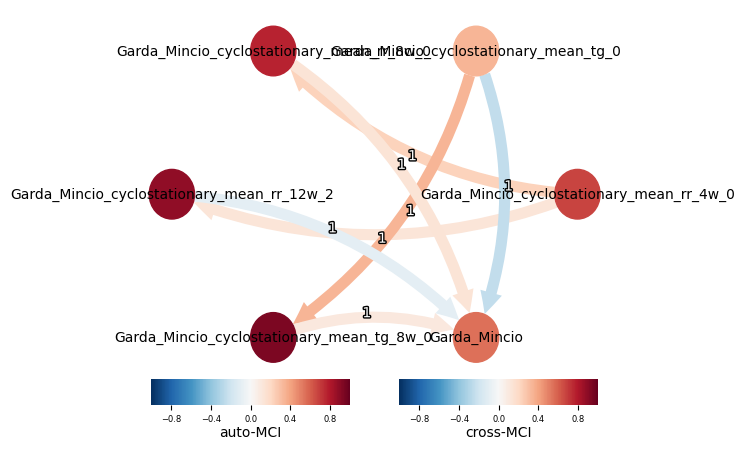

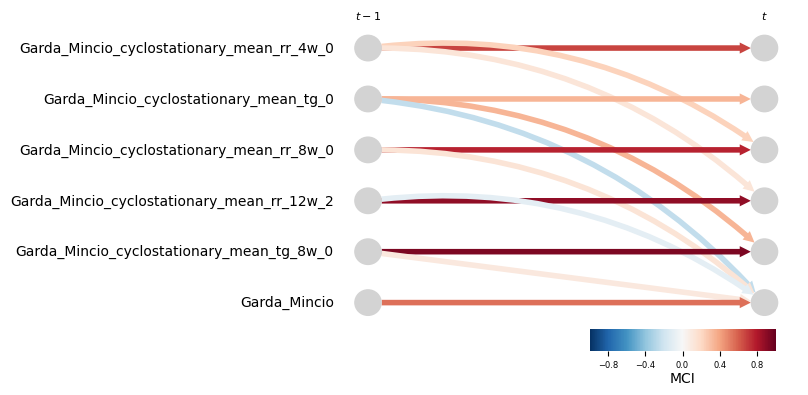

In [334]:
fullCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | val =  0.669

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.394

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.619
        (0 -1): pval = 0.00200 | val =  0.123

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.661

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.643
        (1 -1): pval = 0.00000 | val =  0.331

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.492
        (1 -1): pval = 0.00000 | val = -0.265
        (2 -1): pval = 0.01833 | val =  0.094


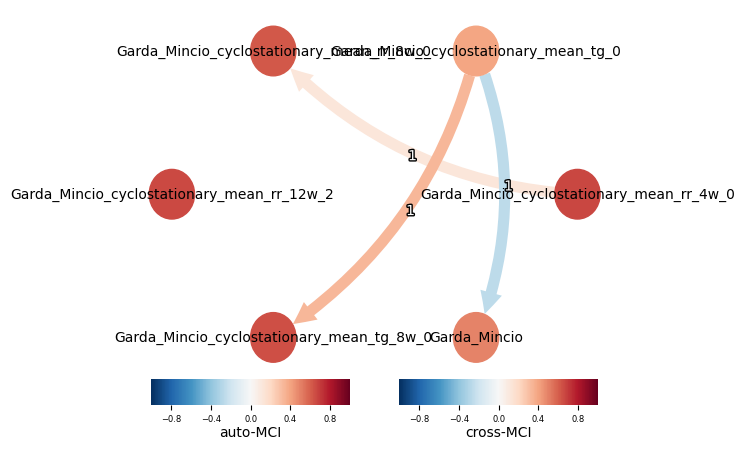

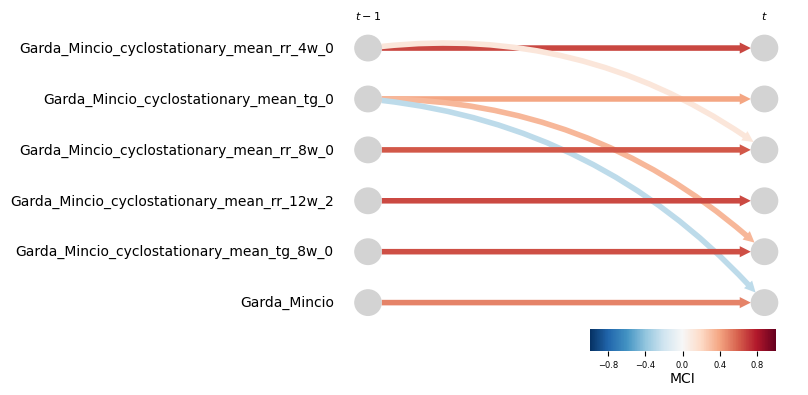

In [335]:
PCMCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.065
        (2 -1): pval = 0.04600 | val =  0.016

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.032

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.065
        (0 -1): pval = 0.00000 | val =  0.026

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.116

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.187
        (1 -1): pval = 0.00000 | val =  0.020

    Variable 5 has 4 link(s):
        (5 -1): pval = 0.00000 | val =  0.069
        (1 -1): pval = 0.00000 | val =  0.019
        (2 -1): pval = 0.05000 | val =  0.010
        (3 -1): pval = 0.00600 | val =  0.009


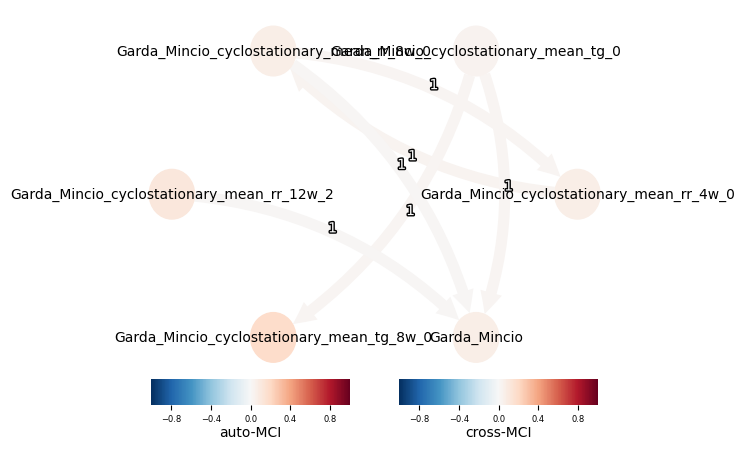

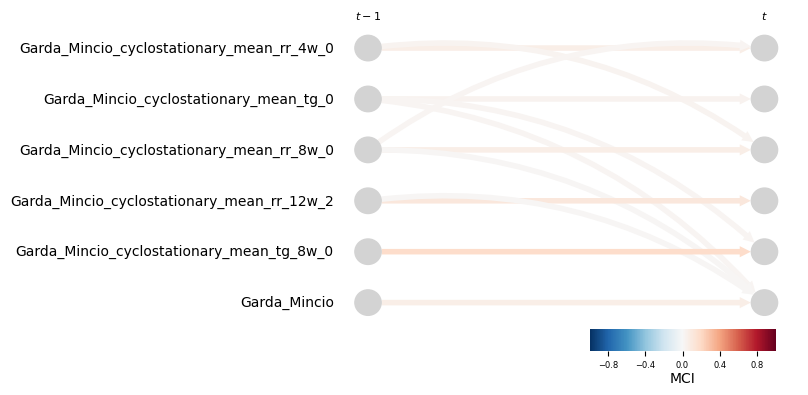

In [336]:
fullCI_singleBasin(df,tau=1,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | val =  0.171

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.057

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.059
        (4 -1): pval = 0.02600 | val =  0.042
        (5 -1): pval = 0.04000 | val =  0.013

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.174
        (2 -1): pval = 0.04600 | val =  0.014

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.053
        (5 -1): pval = 0.01600 | val =  0.026
        (1 -1): pval = 0.00000 | val =  0.022

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.069
        (1 -1): pval = 0.00000 | val =  0.028
        (2 -1): pval = 0.04400 | val =  0.010


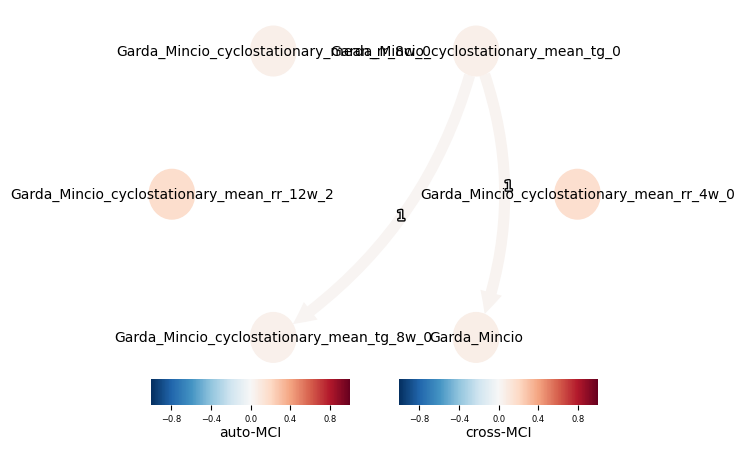

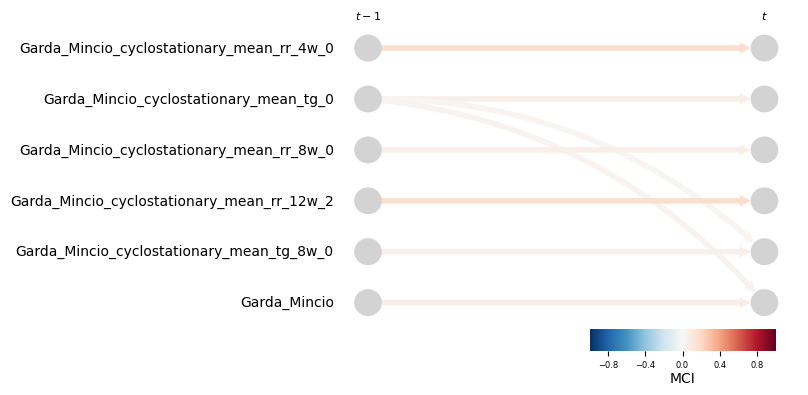

In [337]:
PCMCI_singleBasin(df,tau=1,cond_test=CMIknn())

### tau=2


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.529
        (3 -1): pval = 0.00356 | val =  0.117
        (3 -2): pval = 0.00462 | val = -0.113

    Variable 1 has 3 link(s):
        (1 -1): pval = 0.00000 | val =  0.241
        (1 -2): pval = 0.03943 | val = -0.083
        (0 -1): pval = 0.04875 | val =  0.079

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.577
        (0 -2): pval = 0.00000 | val =  0.185
        (2 -2): pval = 0.01097 | val = -0.102
        (3 -2): pval = 0.04229 | val = -0.081

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.651
        (3 -2): pval = 0.00475 | val = -0.113
        (0 -2): pval = 0.04179 | val =  0.082
        (2 -2): pval = 0.04546 | val =  0.080

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.627
        (4 -2): pval = 0.00000 | val = -0.215
        (1 -1): pval = 0.01351 | val =  0.099

    Variable 5 has 5 li

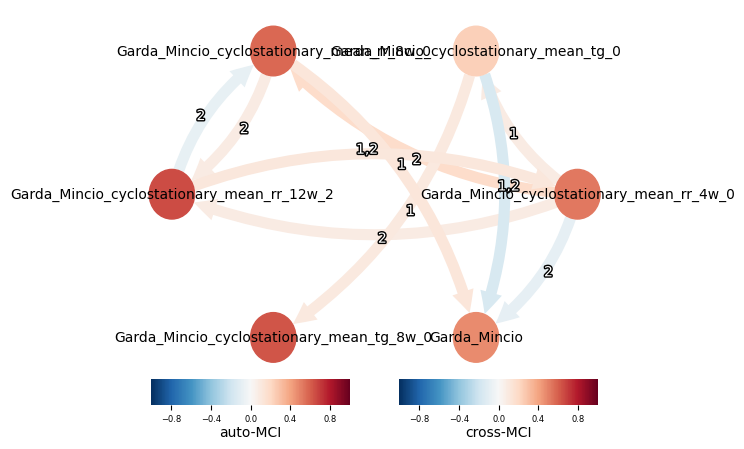

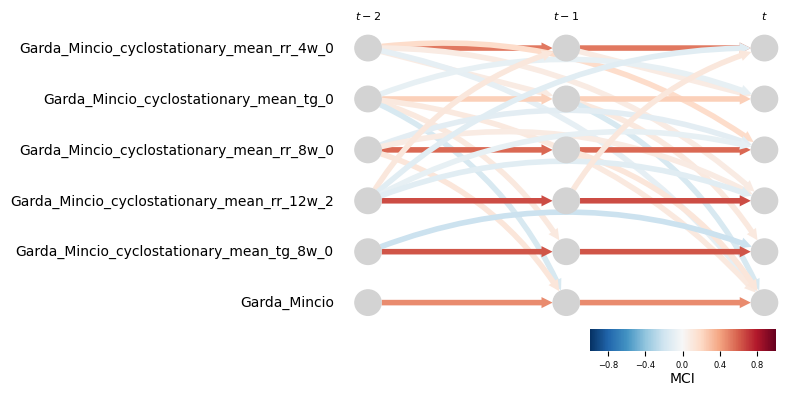

In [338]:
fullCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (0 -1): pval = 0.00000 | val =  0.034

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.026

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.020
        (0 -1): pval = 0.00000 | val =  0.015

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.024
        (4 -2): pval = 0.02600 | val =  0.007
        (5 -1): pval = 0.02000 | val =  0.007
        (1 -1): pval = 0.01400 | val =  0.007

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.026
        (1 -1): pval = 0.00000 | val =  0.016

    Variable 5 has 2 link(s):
        (5 -1): pval = 0.00000 | val =  0.037
        (1 -1): pval = 0.00000 | val =  0.016


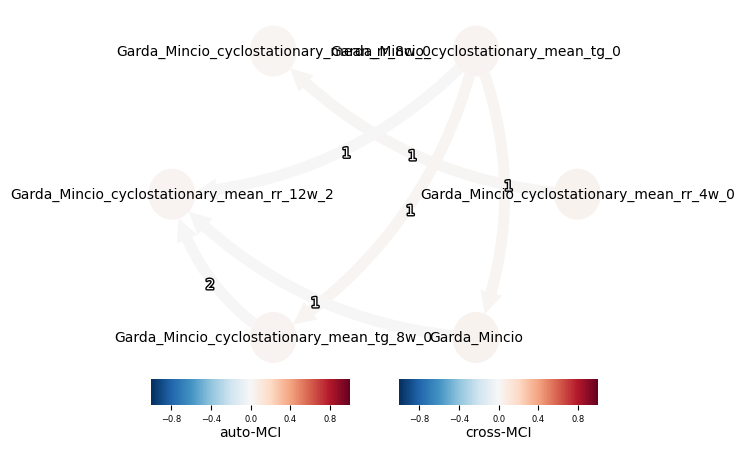

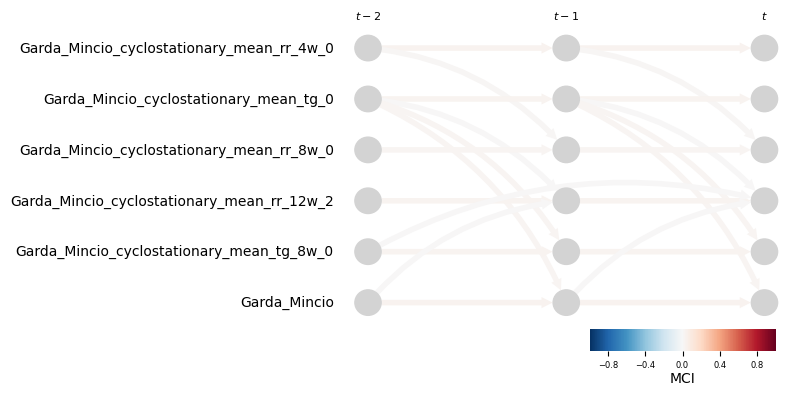

In [339]:
fullCI_singleBasin(df,tau=2,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.669
        (0 -2): pval = 0.03642 | val = -0.083

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.396

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.595
        (0 -1): pval = 0.00206 | val =  0.122
        (1 -2): pval = 0.02053 | val = -0.092

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.705
        (0 -2): pval = 0.01046 | val =  0.102
        (3 -2): pval = 0.01513 | val = -0.097

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.806
        (4 -2): pval = 0.00000 | val = -0.267
        (1 -1): pval = 0.03045 | val =  0.086

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.494
        (1 -1): pval = 0.00000 | val = -0.267
        (3 -2): pval = 0.01329 | val =  0.098
        (2 -1): pval = 0.01931 | val =  0.093
        (2 -2): pval = 0.02824 | val = 

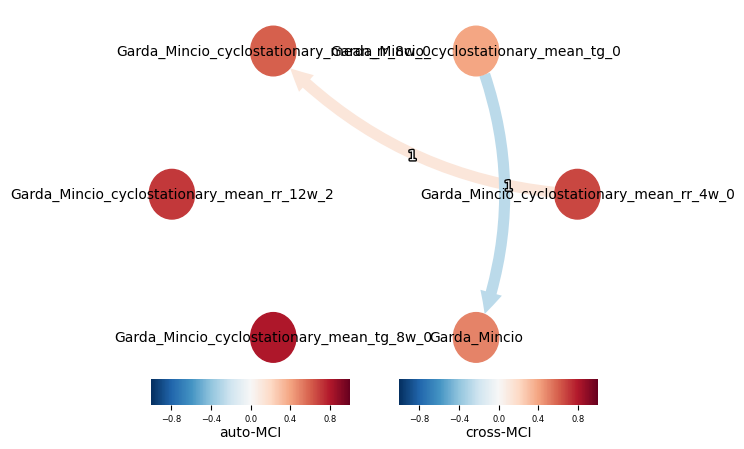

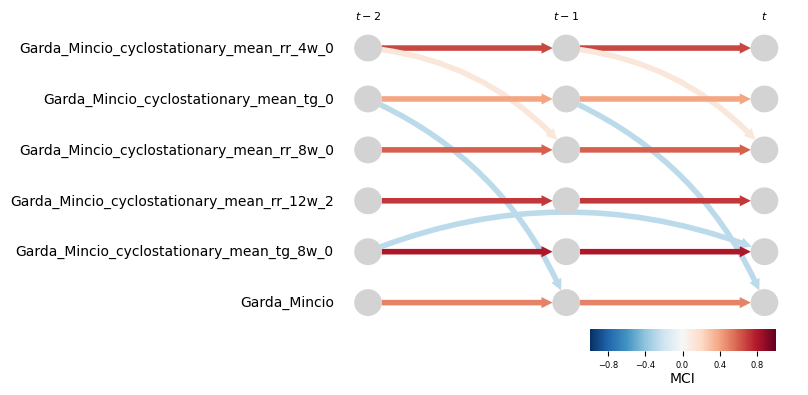

In [340]:
PCMCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.171
        (1 -2): pval = 0.05000 | val =  0.013

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.059

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.174
        (4 -1): pval = 0.01600 | val =  0.043
        (4 -2): pval = 0.04600 | val =  0.034

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.175
        (0 -2): pval = 0.01800 | val =  0.013

    Variable 4 has 4 link(s):
        (4 -1): pval = 0.00000 | val =  0.053
        (5 -1): pval = 0.02800 | val =  0.026
        (1 -1): pval = 0.00000 | val =  0.022
        (1 -2): pval = 0.01800 | val =  0.015

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.068
        (1 -1): pval = 0.00000 | val =  0.028
        (4 -1): pval = 0.04200 | val =  0.021
        (2 -2): pval = 0.02200 | val =  0.015
        (2 -1): pval = 0.02200 | val = 

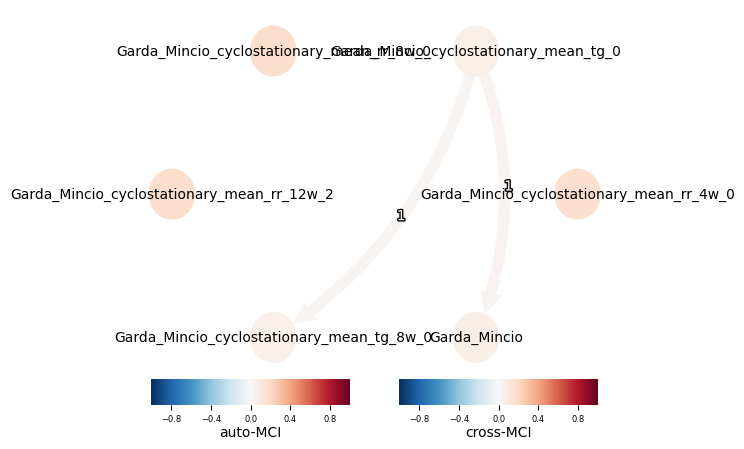

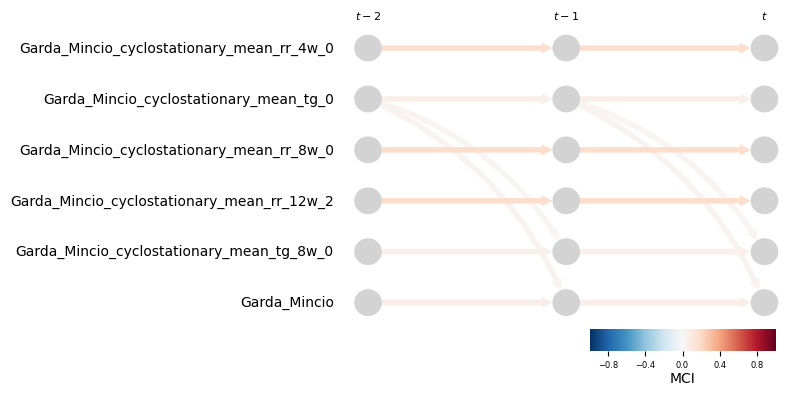

In [341]:
PCMCI_singleBasin(df,tau=2,cond_test=CMIknn())

### tau=3


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (0 -1): pval = 0.00000 | val =  0.512
        (3 -1): pval = 0.00057 | val =  0.139
        (5 -2): pval = 0.00327 | val =  0.118
        (5 -3): pval = 0.01271 | val = -0.100
        (2 -3): pval = 0.04453 | val = -0.081

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.225

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.552
        (0 -3): pval = 0.00000 | val =  0.249
        (3 -3): pval = 0.00718 | val = -0.108
        (5 -3): pval = 0.03086 | val =  0.087

    Variable 3 has 2 link(s):
        (3 -1): pval = 0.00000 | val =  0.638
        (2 -3): pval = 0.00361 | val =  0.117

    Variable 4 has 4 link(s):
        (4 -1): pval = 0.00000 | val =  0.602
        (4 -2): pval = 0.00001 | val = -0.174
        (1 -3): pval = 0.00290 | val =  0.120
        (1 -1): pval = 0.01416 | val =  0.099

    Variable 5 has 7 link(s):
        (5 -1): pval = 0.00000 | val = 

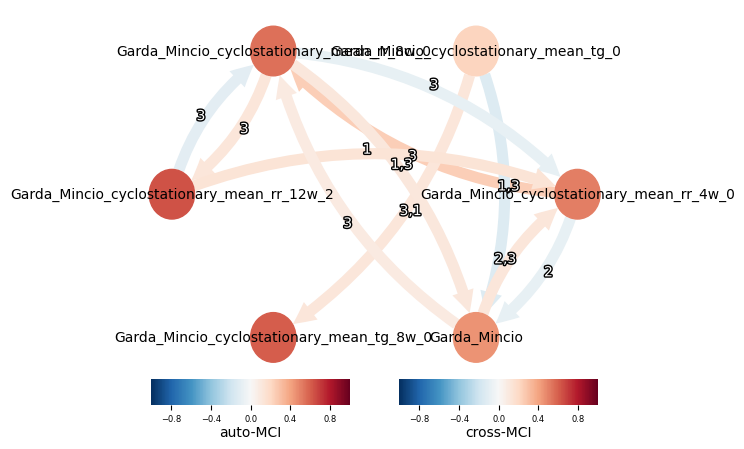

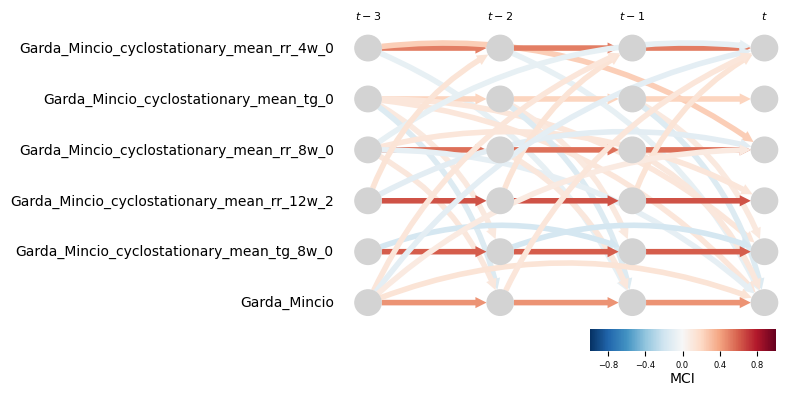

In [342]:
fullCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.028
        (5 -2): pval = 0.04200 | val =  0.007

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.022

    Variable 2 has 2 link(s):
        (2 -1): pval = 0.00000 | val =  0.015
        (0 -1): pval = 0.00200 | val =  0.011

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.017

    Variable 4 has 2 link(s):
        (4 -1): pval = 0.00000 | val =  0.018
        (1 -1): pval = 0.00000 | val =  0.015

    Variable 5 has 5 link(s):
        (5 -1): pval = 0.00000 | val =  0.029
        (1 -1): pval = 0.00000 | val =  0.013
        (5 -3): pval = 0.04800 | val =  0.011
        (1 -3): pval = 0.02200 | val =  0.007
        (3 -1): pval = 0.05000 | val =  0.007


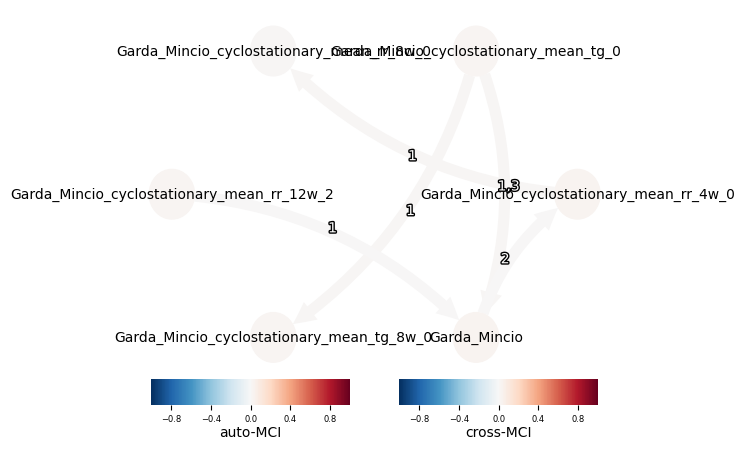

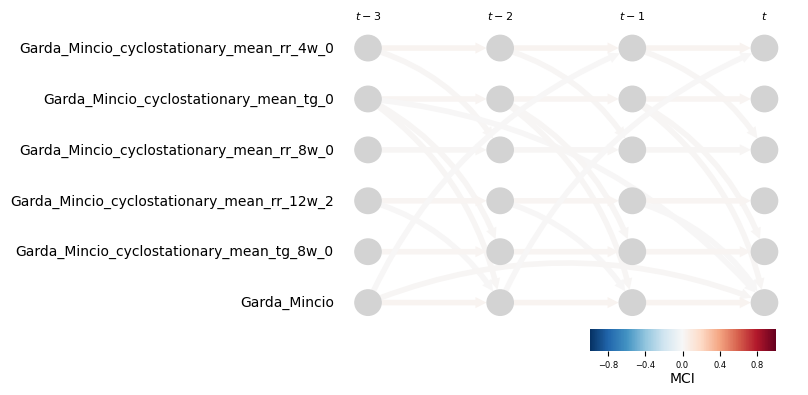

In [343]:
fullCI_singleBasin(df,tau=3,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.669
        (0 -3): pval = 0.03482 | val = -0.084
        (0 -2): pval = 0.04019 | val = -0.082

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val =  0.395
        (4 -3): pval = 0.04515 | val =  0.080

    Variable 2 has 5 link(s):
        (2 -1): pval = 0.00000 | val =  0.525
        (1 -2): pval = 0.02046 | val = -0.092
        (0 -1): pval = 0.02124 | val =  0.092
        (5 -3): pval = 0.03562 | val =  0.084
        (2 -2): pval = 0.03858 | val = -0.083

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.720
        (0 -2): pval = 0.01096 | val =  0.101
        (3 -2): pval = 0.01674 | val = -0.095
        (2 -3): pval = 0.02020 | val =  0.093

    Variable 4 has 3 link(s):
        (4 -1): pval = 0.00000 | val =  0.806
        (4 -2): pval = 0.00000 | val = -0.270
        (1 -1): pval = 0.03218 | val =  0.085

    Variable 5 has 5 li

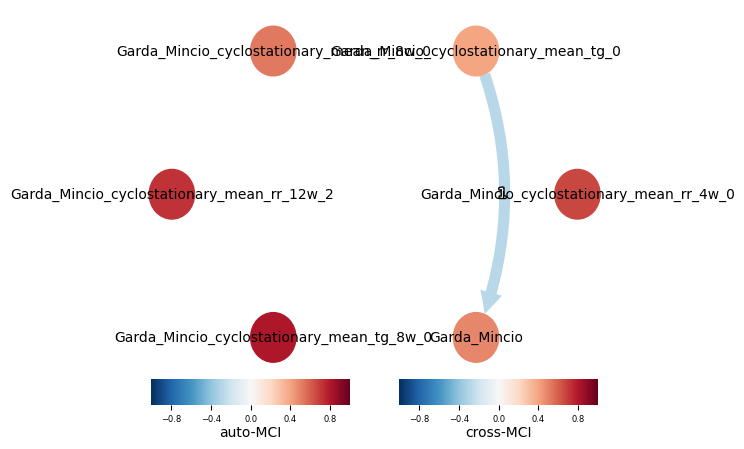

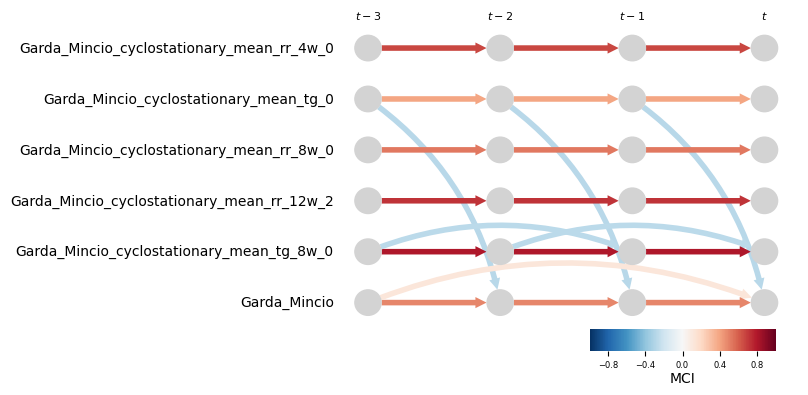

In [344]:
PCMCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.00000 | val =  0.172
        (5 -3): pval = 0.02000 | val =  0.023

    Variable 1 has 2 link(s):
        (1 -1): pval = 0.00000 | val =  0.060
        (3 -2): pval = 0.04600 | val =  0.014

    Variable 2 has 5 link(s):
        (4 -1): pval = 0.02000 | val =  0.042
        (4 -2): pval = 0.04400 | val =  0.033
        (2 -1): pval = 0.00000 | val =  0.028
        (0 -1): pval = 0.00000 | val =  0.019
        (0 -3): pval = 0.02200 | val =  0.012

    Variable 3 has 6 link(s):
        (3 -1): pval = 0.00000 | val =  0.175
        (5 -2): pval = 0.04600 | val =  0.029
        (5 -1): pval = 0.04400 | val =  0.027
        (2 -3): pval = 0.01400 | val =  0.025
        (1 -3): pval = 0.03600 | val =  0.015
        (0 -2): pval = 0.02200 | val =  0.014

    Variable 4 has 6 link(s):
        (4 -1): pval = 0.00000 | val =  0.053
        (2 -1): pval = 0.05000 | val =  0.039
        (5 -3): pval = 0

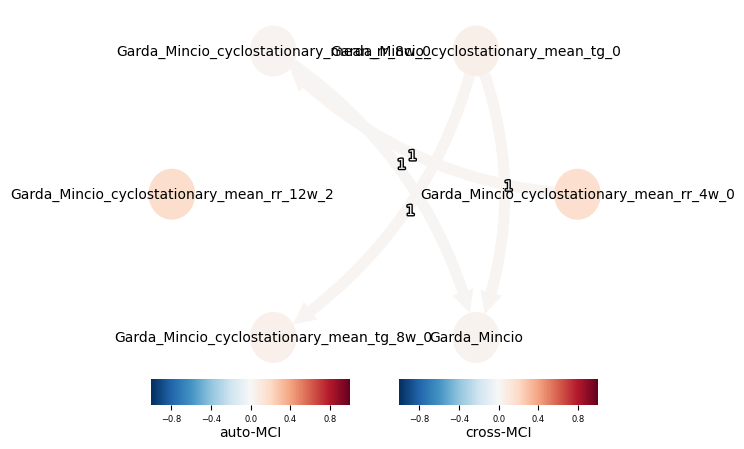

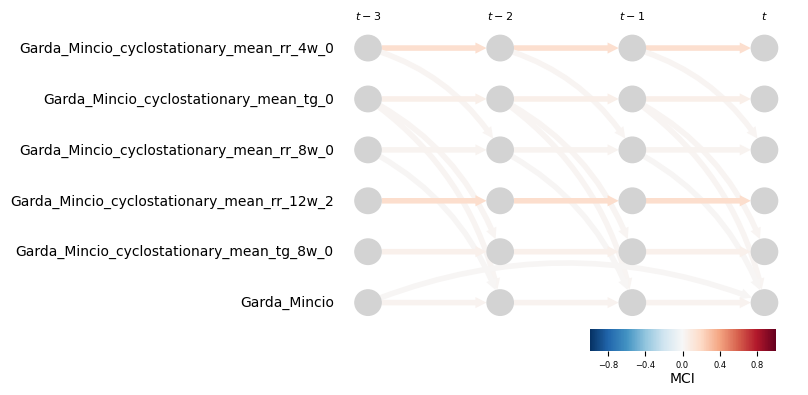

In [345]:
PCMCI_singleBasin(df,tau=3,cond_test=CMIknn())

## Regressions

In [191]:
### tau = 1
print('####### tau=1 ########')

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,10:].values
x_test = best5_CMI_fulldf_test.iloc[1:,10:].values
y = targets_df_trainVal.iloc[:-1,2].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,2].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],1),concatenate_past(x[:,1],1),concatenate_past(x[:,2],1),concatenate_past(x[:,3],1),concatenate_past(x[:,4],1)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],1),concatenate_past(x_test[:,1],1),concatenate_past(x_test[:,2],1),concatenate_past(x_test[:,3],1),concatenate_past(x_test[:,4],1)),axis=1)
y_lag1 = y[0:-1]
y_test_lag1 = y_test[0:-1]

reg_full = LinearRegression().fit(x_full[:,[0,1,2,3]], y[1:].reshape(-1,1))
print(f'Regression with 0,1,2,3 no target: {reg_full.score(x_full_test[:,[0,1,2,3]], y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1, y[1:].reshape(-1,1))
print(f'Only target (baseline): {reg.score(y_test_lag1, y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1 and target: {reg.score(np.concatenate((x_full_test[:,[1]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1,2]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1,2 and target: {reg.score(np.concatenate((x_full_test[:,[1,2]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1,2,3]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1,2,3 and target: {reg.score(np.concatenate((x_full_test[:,[1,2,3]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[1,2,3,4]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 1,2,3,4 and target: {reg.score(np.concatenate((x_full_test[:,[1,2,3,4]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')



####### tau=1 ########
Regression with 0,1,2,3 no target: 0.16996823956988893

Only target (baseline): 0.28958294818052077

Regression with 1 and target: 0.38246146708095086

Regression with 1,2 and target: 0.39548301118147

Regression with 1,2,3 and target: 0.39532307391516464

Regression with 1,2,3,4 and target: 0.4377668521403084



In [199]:
print('####### tau=2 ########')
tau=2

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,10:].values
x_test = best5_CMI_fulldf_test.iloc[1:,10:].values
y = targets_df_trainVal.iloc[:-1,2].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,2].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2 = np.concatenate((y[1:-1],y[:-2]),axis=1)
y_test_lag1_2 = np.concatenate((y_test[1:-1],y_test[:-2]),axis=1)

reg = LinearRegression().fit(x_full[:,[0,1,2,3,4,5,6,7]], y[2:].reshape(-1,1))
print(f'Regression with 0,1,2,3 no target: {reg.score(x_full_test[:,[0,1,2,3,4,5,6,7]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2, y[2:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2, y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1 and target: {reg.score(np.concatenate((x_full_test[:,[2,3]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3,4,5,6,7]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1,2,3 and target: {reg.score(np.concatenate((x_full_test[:,[2,3,4,5,6,7]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3,4,5,8,9]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1,2,4 and target: {reg.score(np.concatenate((x_full_test[:,[2,3,4,5,8,9]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,3,4,5]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,1,2 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,3,4,5]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,3,4,5]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 1,2 and target: {reg.score(np.concatenate((x_full_test[:,[2,3,4,5]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')



####### tau=2 ########
Regression with 0,1,2,3 no target: 0.17583184302744448

Only target: 0.296347888436162

Regression with 1 and target: 0.3833861565224598

Regression with 1,2,3 and target: 0.4010652051476046

Regression with 1,2,4 and target: 0.41602131684402965

Regression with 0,1,2 and target: 0.39861137411713277

Regression with 1,2 and target: 0.3976825945897151



In [203]:
print('####### tau=3 ########')
tau=3

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,10:].values
x_test = best5_CMI_fulldf_test.iloc[1:,10:].values
y = targets_df_trainVal.iloc[:-1,2].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,2].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau)),axis=1)
y_lag1_2_3 = np.concatenate((y[2:-1],y[1:-2],y[:-3]),axis=1)
y_test_lag1_2_3 = np.concatenate((y_test[2:-1],y_test[1:-2],y_test[:-3]),axis=1)

reg = LinearRegression().fit(x_full[:,[6,7,8,9,10,11,12,13,14]], y[3:].reshape(-1,1))
print(f'Regression with 2,3,4 no target: {reg.score(x_full_test[:,[6,7,8,9,10,11,12,13,14]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,2,3,4,5,6,7,8]], y[3:].reshape(-1,1))
print(f'Regression with 0,1,2 no target: {reg.score(x_full_test[:,[0,1,2,3,4,5,6,7,8]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2_3, y[3:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2_3, y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[3,4,5]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 1 and target: {reg.score(np.concatenate((x_full_test[:,[3,4,5]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[3,4,5,6,7,8]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 1,2 and target: {reg.score(np.concatenate((x_full_test[:,[3,4,5,6,7,8]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,3,4,5,6,7,8]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 1,2,0 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,3,4,5,6,7,8]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')



####### tau=3 ########
Regression with 2,3,4 no target: 0.14823255928742773

Regression with 0,1,2 no target: 0.18731001295633187

Only target: 0.2905445511633452

Regression with 1 and target: 0.4266898735697754

Regression with 1,2 and target: 0.44294002839629654

Regression with 1,2,0 and target: 0.44554144708157084



# Cluster

## Data

In [368]:
### targets
basins = ['Emiliani1','Emiliani2','Garda_Mincio']
path_targets = '../causalFS/droughts/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std


target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.379890    0.50  2001     1 -0.382765
1    2001-01-13  0.482679    0.58  2001     2  0.319215
2    2001-01-21  0.516259    0.59  2001     3  0.548542
3    2001-01-29  0.434421    0.50  2001     5 -0.010351
4    2001-02-06  0.494805    0.54  2001     6  0.402030
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.427085    0.43  2009    48 -0.060454
407  2009-12-05  0.547380    0.57  2009    49  0.761079
408  2009-12-13  0.531070    0.58  2009    50  0.649694
409  2009-12-21  0.295704    0.00  2009    52 -0.957702
410  2009-12-29  0.027861    0.00  2009    53 -2.786888

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  

In [369]:
targets_df_trainVal

Emiliani1  Emiliani2  Garda_Mincio
0    -0.382765  -1.339879     -1.996014
1     0.319215   0.402993      0.498869
2     0.548542   0.282703     -0.428613
3    -0.010351  -0.030490     -0.583432
4     0.402030   0.451097      0.075938
..         ...        ...           ...
634  -0.320516  -0.229575      0.018152
635   0.137056   0.038989      0.313402
636   0.305368   0.020677      0.293271
637  -0.586199  -0.444088     -0.217675
638  -0.203542  -0.466378     -0.242181

[639 rows x 3 columns]

In [370]:
### 5 features for each basin
#path_features = '../causalFS/droughts/adda_oglio_lambro_ticino/'
path_features = '../causalFS/droughts/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

#basins = ['Adda','Lambro_Olona','Oglio_Iseo','Ticino']
for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_nonLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

best5_CMI_fulldf_trainVal = pd.concat((best5_CMI_fulldf_train,best5_CMI_fulldf_val),axis=0).reset_index(drop=True)

In [371]:
best5_CMI_fulldf_trainVal

Emiliani1_cyclostationary_mean_rr_4w_0  \
0                                  2.112078   
1                                  1.404523   
2                                  1.162736   
3                                  0.861999   
4                                  1.461930   
..                                      ...   
634                               -0.608772   
635                               -0.325822   
636                                0.588081   
637                                0.360721   
638                                0.107863   

     Emiliani1_cyclostationary_mean_tg_1w_4  \
0                                  0.345989   
1                                  1.128851   
2                                  0.786460   
3                                  0.564161   
4                                  0.604584   
..                                      ...   
634                                2.159366   
635                                1.311011   
636                                1.354429   
637                                1.653467   
638                                1.265916   

     Emiliani1_cyclostationary_mean_rr_12w_1  \
0                                   1.690770   
1                                   1.865833   
2                                   1.429151   
3                                   0.611897   
4                                   4.150391   
..                                       ...   
634                                 1.128914   
635                                 0.790244   
636                                 1.428052   
637                                 1.152108   
638                                 0.578823   

     Emiliani1_cyclostationary_mean_rr_8w_1  \
0                                  3.965287   
1                                  1.655892   
2                                  1.672157   
3                                  1.593990   
4                                  1.782496   
..                                      ...   
634                                0.745100   
635                                0.037201   
636                                0.170754   
637                                0.094855   
638                               -0.634415   

     Emiliani1_cyclostationary_mean_tg_9  \
0                               0.268224   
1                               0.977612   
2                              -0.780151   
3                               0.408553   
4                              -0.260577   
..                                   ...   
634                             0.624547   
635                             1.691934   
636                             1.924323   
637                             1.546077   
638                             1.023210   

     Emiliani2_cyclostationary_mean_tg_1w_4  \
0                                 -0.415835   
1                                  0.237307   
2                                 -0.259989   
3                                 -0.565851   
4                                 -0.187005   
..                                      ...   
634                                2.050920   
635                                1.776750   
636                                1.963611   
637                                1.734032   
638                                1.748151   

     Emiliani2_cyclostationary_mean_rr_4w_3  \
0                                  0.733822   
1                                  0.849889   
2                                  0.518355   
3                                  0.239497   
4                                  0.696217   
..                                      ...   
634                                1.182447   
635                                1.931919   
636                                2.777644   
637                                2.563059   
638                                0.244175   

     Emiliani2_cyclostationary_mean_tg_4  \
0                             

In [372]:
x = best5_CMI_fulldf_trainVal.iloc[1:,:].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)


In [373]:
x.shape

(638, 15)

In [374]:
y.shape

(638, 1)

## forward and backward CMI, tau from 1 to 3

In [375]:
for tau in [1,2,3]:
    for k in [20]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = forwardFeatureSelection(threshold=0.5,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.16823209384418183
CMI: 0.10280538715847265
CMI: 0.10417411499506166
CMI: 0.12681772714160705
CMI: 0.09348105114415264
CMI: 0.11244560245647964
CMI: 0.11088604307945737
CMI: 0.12228618057258663
CMI: 0.09076420207628583
CMI: 0.07609857119741163
CMI: 0.11878263263592363
CMI: 0.10385784200120571
CMI: 0.150339562777073
CMI: 0.08340795603931954
CMI: 0.04341822310795466
Highest CMI score: 0.16823209384418183
Adding original feature: 0
CMI: 0.07207461094824688
CMI: 0.02662731062297166
CMI: 0.015329542014702852
CMI: 0.07615722496537786
CMI: 0.05668660183340066
CMI: 0.0728899299130619
CMI: 0.018894351433426854
CMI: 0.0004400391913059465
CMI: 0.002785611817917616
CMI: 0.078768786247991
CMI: 0.03484306707135765
CMI: 0.006020955648337822
CMI: 0.028129919381655072
Highest CMI score: 0.078768786247991
Adding original feature: 11
CMI: 0.007372277640213948
CMI: 0.01292272302026945
CMI: 0.011492751208883795
Highest CMI score: 0.01292272302026945
Adding original feature: 3
C

In [376]:
for tau in [1,2,3]:
    print(f'###### tau={tau} #########')
    res = {
            "delta" : [], # list with all deltas
            "numSelected" : [], #
            "selectedFeatures" : [] 
        #    "accuracy" : [] # list of scores associated with the reduced problem
    }
    
    sel = backwardFeatureSelection(threshold=11,features=x,target=y,res=res,k=20, nproc=1, tau=tau)
    print(sel)
        
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.0011627430526151838
CMI: 0.004968040791166778
CMI: 0.005432652533660737
[(14, -0.017546491605831993), (9, -0.009840640005547463), (13, -0.005526146339961041), (7, -0.004806790193143923), (6, -0.0036156075594794834), (10, -0.0033068049298933533), (5, -0.003299928259737378), (12, -0.0031851908480156066), (8, -0.002584236826964681), (4, -0.0024879165296580186), (11, -0.0012877112535727153), (0, -0.0001889852243145973), (1, 0.0011627430526151838), (2, 0.004968040791166778), (3, 0.005432652533660737)]
Removing original feature: 14
CMI: 0.002920644134779188
CMI: 0.004215941615111435
CMI: 0.007811724567030859
CMI: 0.0009993663262353736
[(9, -0.007799749998874006), (13, -0.00428223300489447), (7, -0.003961340717272194), (1, -0.00304929010787669), (10, -0.0029952094348771607), (8, -0.0028766920436512633), (4, -0.00237064620131186), (11, -0.0013423334022502897), (5, -0.0013217409893398757), (6, -0.0006821426976317546), (12, 0.0009993663262353736), (0, 0.002920644134

CMI: 0.00877023989774553
[(1, -0.005382085666409853), (5, -0.004622800987414494), (7, -0.00447496837532263), (8, -0.0016644659409114915), (4, -0.0015923990258875087), (6, -0.0006692941108541739), (0, 0.001217746999770758), (2, 0.005465779461515385), (3, 0.00877023989774553)]
Removing original feature: 1
CMI: 0.0015901410765937207
CMI: 0.00560211752980902
CMI: 0.006241018587557379
[(5, -0.008034583383343091), (6, -0.007354791060485977), (4, -0.005461255975414192), (7, -0.0026784800989072266), (3, -0.0022810372158565684), (0, 0.0015901410765937207), (1, 0.00560211752980902), (2, 0.006241018587557379)]
Removing original feature: 7
CMI: 0.007093285571057872
CMI: 0.0029992252558392885
CMI: 0.009717307322049729
CMI: 0.0034831000300913906
[(5, -0.009159142904976492), (4, -0.007499870842962164), (6, -0.0009336274483568441), (1, 0.0029992252558392885), (3, 0.0034831000300913906), (0, 0.007093285571057872), (2, 0.009717307322049729)]
Removing original feature: 10
CMI: 0.00746721754415422
CMI: 0.

## forward and backward TE, tau from 1 to 3

In [379]:
for tau in [1,2,3]:
    for k in [10,20]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_forwardFeatureSelection(threshold=100,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.04533884761738344
CMI: 0.030817899184002184
CMI: 0.002958677495556006
CMI: 0.041775299468419014
CMI: 0.04944707981941132
CMI: 0.02567573388641442
CMI: 0.025175358793670888
CMI: 0.0606743351948707
CMI: 0.04223198984319659
CMI: 0.00856105790368017
CMI: 0.01147084301298995
CMI: 0.046019774136196456
CMI: 0.042829258006676585
CMI: 0.033317152337054345
CMI: 0.003109001158461633
Highest CMI score: 0.0606743351948707
Adding original feature: 7
CMI: 0.03277376729891912
CMI: 0.019588940921798748
CMI: 0.011949836247091339
CMI: 0.006598641351772516
CMI: 0.005805439250600453
CMI: 0.008267684572903555
CMI: 0.008483602749818187
CMI: 0.008478619998772419
CMI: 0.008342945150513092
CMI: 0.001953487468224213
Highest CMI score: 0.03277376729891912
Adding original feature: 0
Highest CMI score: -0.004699050607612609
[7, 0]
###### tau=1 #########
CMI: 0.03112663207976818
CMI: 0.007062370531462081
CMI: 0.019991981087714605
CMI: 0.030877057703629363
CMI: 0.01068907106028022
CMI: 0

In [380]:
for tau in [1,2,3]:
    for k in [10,20]:
        print(f'###### tau={tau} #########')
        res = {
                "delta" : [], # list with all deltas
                "numSelected" : [], #
                "selectedFeatures" : [] 
            #    "accuracy" : [] # list of scores associated with the reduced problem
        }
        
        sel = TE_backwardFeatureSelection(threshold=1,features=x,target=y,res=res,k=k, nproc=1, tau=tau)
        print(sel)
    
    #regr = LinearRegression().fit(x[:,sel], y_target2[:200].reshape(-1,1))
    #x1_past2 = concatenate_past(x1,2)
    #y_past2 = concatenate_past(y,2)

###### tau=1 #########
CMI: 0.0018019315287328141
CMI: 0.0012977168773051218
[(14, -0.021167074240947936), (13, -0.013065185891271869), (9, -0.011873906011966306), (1, -0.008771786243331692), (6, -0.007115486499336077), (5, -0.0069634336006424435), (2, -0.006165524722149041), (10, -0.005676275020147226), (12, -0.005553302145740402), (7, -0.0052090039184174985), (8, -0.0035328130350686937), (11, -0.0009003892906278566), (4, -0.000520658464451873), (3, 0.0012977168773051218), (0, 0.0018019315287328141)]
Removing original feature: 14
CMI: 0.0016671771365060484
CMI: 0.002134927796509589
[(9, -0.009246863073363365), (13, -0.007972291249061014), (1, -0.006307732167943336), (2, -0.005164730656150307), (6, -0.004027985950824653), (5, -0.003676633239944882), (10, -0.0035923295845292635), (7, -0.002626435174471975), (4, -0.001913115860087189), (11, -0.001711093433402644), (8, -0.0008878590540365994), (12, -0.0005187270246290177), (0, 0.0016671771365060484), (3, 0.002134927796509589)]
Removing or

[(1, -0.008262386480279216), (4, -0.004987673318757657), (3, -0.0044882092914501626), (5, -0.002657072124259807), (6, -0.0017209094014911108), (0, -0.00022231203219486018), (2, 0.0021602927641051206)]
Removing original feature: 2
CMI: 0.007141158579944962
CMI: 0.0006810240686758728
[(3, -0.008814504707877369), (4, -0.005550891109283085), (5, -0.0012840663202188796), (0, -0.0008167261946449567), (2, 0.0006810240686758728), (1, 0.007141158579944962)]
Removing original feature: 6
CMI: 0.0072673970614646755
CMI: 0.005546234975765618
CMI: 0.0007894203091047269
[(3, -0.003416252560498878), (2, -0.002964861512693928), (4, 0.0007894203091047269), (1, 0.005546234975765618), (0, 0.0072673970614646755)]
Removing original feature: 10
CMI: 0.013517210472101693
CMI: 0.0016759236669018907
CMI: 0.0003736238632220945
[(2, -0.0016454934841473867), (3, 0.0003736238632220945), (1, 0.0016759236669018907), (0, 0.013517210472101693)]
Removing original feature: 4
CMI: 0.007666824399562344
CMI: 0.0345767988884

CMI: 0.00015589536606427923
CMI: 0.001651585264164479
CMI: 0.0006310159289943107
CMI: 0.0007380544361533237
[(1, -0.00581115446354441), (4, -0.005470911228817571), (6, -0.0045237567383291655), (3, -0.0034042887393753163), (5, -0.0029940319086640688), (2, 0.00015589536606427923), (8, 0.0006310159289943107), (9, 0.0007380544361533237), (7, 0.001651585264164479), (0, 0.0024026609021372547)]
Removing original feature: 1
CMI: 0.003298455226676711
CMI: 0.0005605195723966672
CMI: 0.0007341156635117807
[(3, -0.012631192137644631), (5, -0.003851248922945666), (4, -0.003814454239187165), (2, -0.0037058139352085795), (7, -0.0021327043919801836), (8, -0.0005863183554529194), (1, 0.0005605195723966672), (6, 0.0007341156635117807), (0, 0.003298455226676711)]
Removing original feature: 5
CMI: 0.0028926035811858986
CMI: 0.0008772080492573664
CMI: 0.0034505120281976
[(4, -0.0046325954342788245), (2, -0.004211592471702941), (3, -0.0031468461315897756), (7, -0.00041581229820208954), (6, -0.00024091194699

[(3, -0.00612010552223774), (7, -0.0058343898491848845), (8, -0.005344190460323334), (5, -0.005084378014523411), (6, -0.004629540946352317), (10, -0.004478631658877991), (0, -0.0033578894224989275), (4, -0.0030755087091360322), (9, -0.0017899219770416974), (2, -0.001648116873518235), (1, -0.0014899341255147358)]
Removing original feature: 4
[(4, -0.009721363751365647), (8, -0.00581297673501277), (7, -0.005731405223977415), (9, -0.005213599217429615), (6, -0.0044278639087513005), (5, -0.0032986176392468536), (3, -0.0025941140705771637), (0, -0.002006729713392663), (1, -0.001350513111077728), (2, -0.0003872143437310682)]
Removing original feature: 7
CMI: 0.0005699334208869589
CMI: 0.0008837056039185387
[(6, -0.005161409144672141), (5, -0.0030947113712617713), (8, -0.002615001019332902), (3, -0.0009660700419151513), (1, -0.0006336622161798033), (4, -0.0005874445345714907), (7, -0.0005106016365467592), (0, 0.0005699334208869589), (2, 0.0008837056039185387)]
Removing original feature: 10
CM

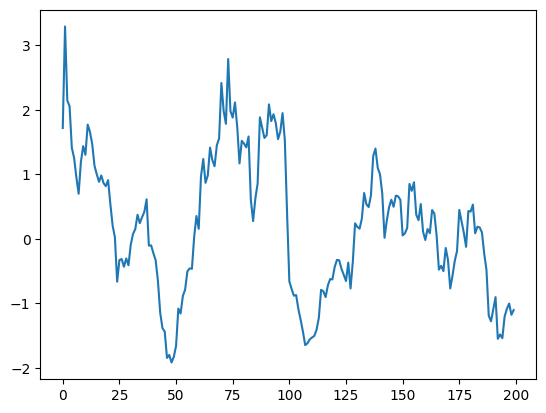

In [432]:
plt.plot(best5_CMI_fulldf_trainVal.iloc[:200,-2])


In [435]:
best5_CMI_fulldf_trainVal.iloc[:,-2].to_csv('data/sampleX1.csv', index=False)

In [272]:
best5_CMI_fulldf_trainVal.iloc[:,2].to_csv('data/sampleX0.csv', index=False)

In [62]:
best5_CMI_fulldf_trainVal.iloc[:,14].to_csv('data/sampleX2.csv', index=False)

In [88]:
best5_CMI_fulldf_trainVal.iloc[:,10].to_csv('data/sampleX3.csv', index=False)

In [85]:
best5_CMI_fulldf_trainVal.iloc[:,2].corr(best5_CMI_fulldf_trainVal.iloc[:,11])


# 10 - corr con 2: 0,37 , con 14: 0,028

-0.10993384050430757

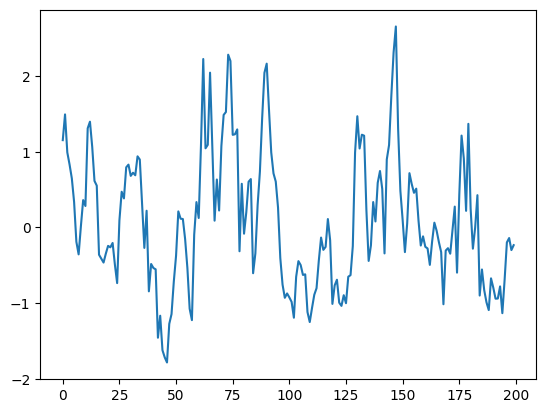

In [87]:
plt.plot(best5_CMI_fulldf_trainVal.iloc[:200,10])

In [431]:
best5_CMI_fulldf_trainVal

Emiliani1_cyclostationary_mean_rr_4w_0  \
0                                  2.112078   
1                                  1.404523   
2                                  1.162736   
3                                  0.861999   
4                                  1.461930   
..                                      ...   
634                               -0.608772   
635                               -0.325822   
636                                0.588081   
637                                0.360721   
638                                0.107863   

     Emiliani1_cyclostationary_mean_tg_1w_4  \
0                                  0.345989   
1                                  1.128851   
2                                  0.786460   
3                                  0.564161   
4                                  0.604584   
..                                      ...   
634                                2.159366   
635                                1.311011   
636                                1.354429   
637                                1.653467   
638                                1.265916   

     Emiliani1_cyclostationary_mean_rr_12w_1  \
0                                   1.690770   
1                                   1.865833   
2                                   1.429151   
3                                   0.611897   
4                                   4.150391   
..                                       ...   
634                                 1.128914   
635                                 0.790244   
636                                 1.428052   
637                                 1.152108   
638                                 0.578823   

     Emiliani1_cyclostationary_mean_rr_8w_1  \
0                                  3.965287   
1                                  1.655892   
2                                  1.672157   
3                                  1.593990   
4                                  1.782496   
..                                      ...   
634                                0.745100   
635                                0.037201   
636                                0.170754   
637                                0.094855   
638                               -0.634415   

     Emiliani1_cyclostationary_mean_tg_9  \
0                               0.268224   
1                               0.977612   
2                              -0.780151   
3                               0.408553   
4                              -0.260577   
..                                   ...   
634                             0.624547   
635                             1.691934   
636                             1.924323   
637                             1.546077   
638                             1.023210   

     Emiliani2_cyclostationary_mean_tg_1w_4  \
0                                 -0.415835   
1                                  0.237307   
2                                 -0.259989   
3                                 -0.565851   
4                                 -0.187005   
..                                      ...   
634                                2.050920   
635                                1.776750   
636                                1.963611   
637                                1.734032   
638                                1.748151   

     Emiliani2_cyclostationary_mean_rr_4w_3  \
0                                  0.733822   
1                                  0.849889   
2                                  0.518355   
3                                  0.239497   
4                                  0.696217   
..                                      ...   
634                                1.182447   
635                                1.931919   
636                                2.777644   
637                                2.563059   
638                                0.244175   

     Emiliani2_cyclostationary_mean_tg_4  \
0                             

## PCMCI and FullCI linear and with CMI

In [381]:
df = pd.concat((best5_CMI_fulldf_trainVal.iloc[1:,:].reset_index(drop=True),targets_df_trainVal.iloc[:-1,0].reset_index(drop=True)),axis=1)
df


Emiliani1_cyclostationary_mean_rr_4w_0  \
0                                  1.404523   
1                                  1.162736   
2                                  0.861999   
3                                  1.461930   
4                                  1.080303   
..                                      ...   
633                               -0.608772   
634                               -0.325822   
635                                0.588081   
636                                0.360721   
637                                0.107863   

     Emiliani1_cyclostationary_mean_tg_1w_4  \
0                                  1.128851   
1                                  0.786460   
2                                  0.564161   
3                                  0.604584   
4                                  0.767746   
..                                      ...   
633                                2.159366   
634                                1.311011   
635                                1.354429   
636                                1.653467   
637                                1.265916   

     Emiliani1_cyclostationary_mean_rr_12w_1  \
0                                   1.865833   
1                                   1.429151   
2                                   0.611897   
3                                   4.150391   
4                                   3.625185   
..                                       ...   
633                                 1.128914   
634                                 0.790244   
635                                 1.428052   
636                                 1.152108   
637                                 0.578823   

     Emiliani1_cyclostationary_mean_rr_8w_1  \
0                                  1.655892   
1                                  1.672157   
2                                  1.593990   
3                                  1.782496   
4                                  1.417955   
..                                      ...   
633                                0.745100   
634                                0.037201   
635                                0.170754   
636                                0.094855   
637                               -0.634415   

     Emiliani1_cyclostationary_mean_tg_9  \
0                               0.977612   
1                              -0.780151   
2                               0.408553   
3                              -0.260577   
4                               0.838725   
..                                   ...   
633                             0.624547   
634                             1.691934   
635                             1.924323   
636                             1.546077   
637                             1.023210   

     Emiliani2_cyclostationary_mean_tg_1w_4  \
0                                  0.237307   
1                                 -0.259989   
2                                 -0.565851   
3                                 -0.187005   
4                                  0.395576   
..                                      ...   
633                                2.050920   
634                                1.776750   
635                                1.963611   
636                                1.734032   
637                                1.748151   

     Emiliani2_cyclostationary_mean_rr_4w_3  \
0                                  0.849889   
1                                  0.518355   
2                                  0.239497   
3                                  0.696217   
4                                  0.443807   
..                                      ...   
633                                1.182447   
634                                1.931919   
635                                2.777644   
636                                2.563059   
637                                0.244175   

     Emiliani2_cyclostationary_mean_tg_4  \
0                             

### Tau = 1


## Significant links at alpha = 0.05:

    Variable 0 has 3 link(s):
        (0 -1): pval = 0.00000 | val =  0.434
        (2 -1): pval = 0.02854 | val =  0.088
        (10 -1): pval = 0.04374 | val =  0.081

    Variable 1 has 7 link(s):
        (1 -1): pval = 0.00000 | val =  0.214
        (5 -1): pval = 0.00002 | val = -0.169
        (11 -1): pval = 0.00279 | val =  0.120
        (7 -1): pval = 0.00370 | val =  0.116
        (0 -1): pval = 0.01018 | val = -0.103
        (10 -1): pval = 0.03193 | val =  0.086
        (12 -1): pval = 0.03436 | val = -0.085

    Variable 2 has 3 link(s):
        (2 -1): pval = 0.00000 | val =  0.872
        (9 -1): pval = 0.00664 | val = -0.109
        (8 -1): pval = 0.04597 | val =  0.080

    Variable 3 has 5 link(s):
        (3 -1): pval = 0.00000 | val =  0.721
        (10 -1): pval = 0.00016 | val =  0.151
        (12 -1): pval = 0.01452 | val = -0.098
        (5 -1): pval = 0.01673 | val =  0.096
        (7 -1): pval = 0.02926 | val = -0.087

  

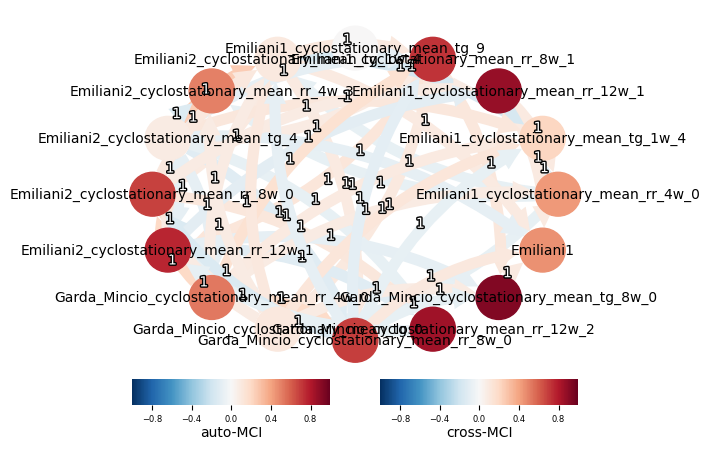

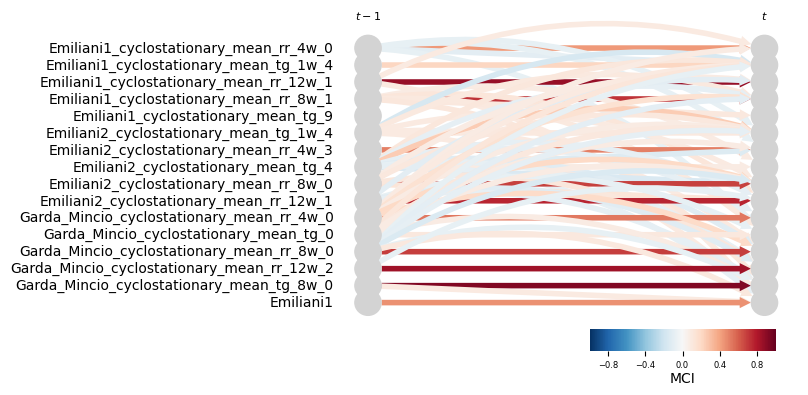

In [382]:
fullCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 1 link(s):
        (2 -1): pval = 0.01800 | val =  0.010

    Variable 1 has 0 link(s):

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.086

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.023

    Variable 4 has 0 link(s):

    Variable 5 has 1 link(s):
        (7 -1): pval = 0.00000 | val =  0.016

    Variable 6 has 1 link(s):
        (6 -1): pval = 0.00000 | val =  0.029

    Variable 7 has 0 link(s):

    Variable 8 has 2 link(s):
        (8 -1): pval = 0.00000 | val =  0.017
        (2 -1): pval = 0.01000 | val =  0.010

    Variable 9 has 1 link(s):
        (9 -1): pval = 0.00000 | val =  0.031

    Variable 10 has 1 link(s):
        (10 -1): pval = 0.00000 | val =  0.022

    Variable 11 has 0 link(s):

    Variable 12 has 1 link(s):
        (12 -1): pval = 0.00000 | val =  0.021

    Variable 13 has 5 link(s):
        (13 -1): pval = 0.00000 | val =  0.059
        (15 -1

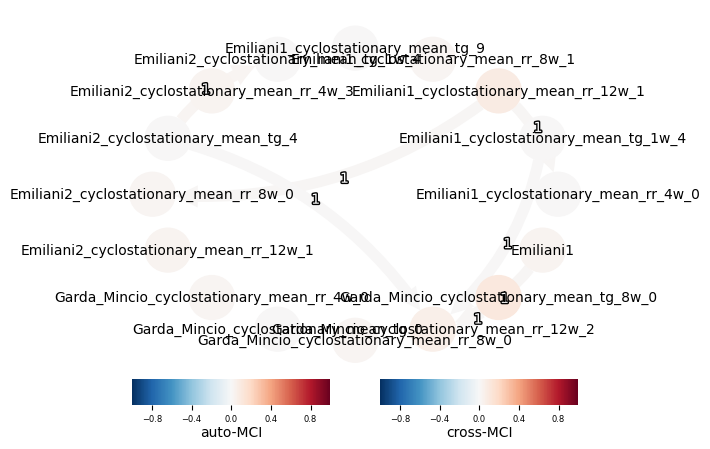

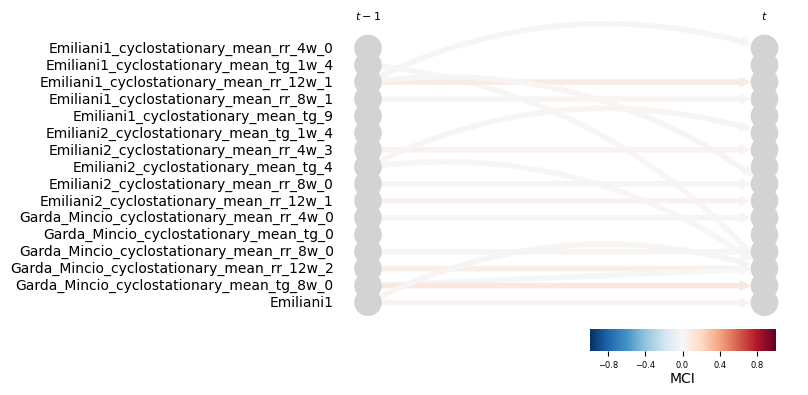

In [410]:
fullCI_singleBasin(df,tau=1,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.663
        (12 -1): pval = 0.01841 | val =  0.094
        (14 -1): pval = 0.02740 | val = -0.087
        (7 -1): pval = 0.02940 | val = -0.086
        (2 -1): pval = 0.03631 | val =  0.083
        (8 -1): pval = 0.03994 | val =  0.082

    Variable 1 has 4 link(s):
        (11 -1): pval = 0.00000 | val =  0.395
        (1 -1): pval = 0.00000 | val =  0.342
        (9 -1): pval = 0.02037 | val = -0.092
        (2 -1): pval = 0.02535 | val = -0.089

    Variable 2 has 7 link(s):
        (2 -1): pval = 0.00000 | val =  0.681
        (10 -1): pval = 0.01712 | val =  0.095
        (11 -1): pval = 0.01741 | val = -0.094
        (4 -1): pval = 0.01768 | val = -0.094
        (0 -1): pval = 0.03150 | val =  0.085
        (6 -1): pval = 0.04476 | val =  0.080
        (13 -1): pval = 0.04717 | val =  0.079

    Variable 3 has 4 link(s):
        (3 -1): pval = 0.00000 | val =  0.712
   

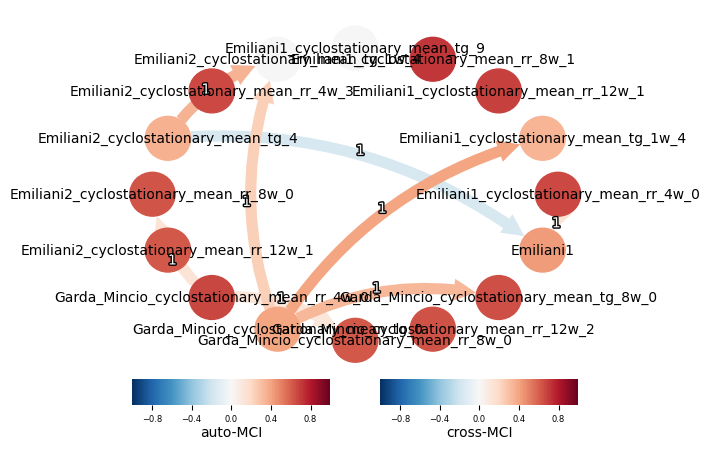

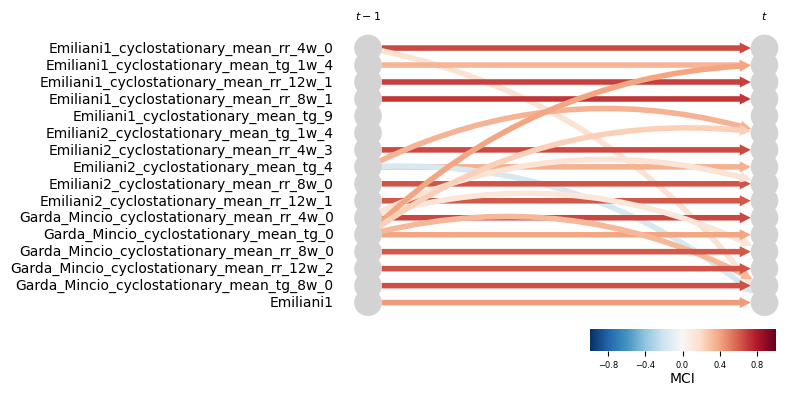

In [383]:
PCMCI_singleBasin(df,tau=1)


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (5 -1): pval = 0.03400 | val =  0.014
        (1 -1): pval = 0.01200 | val =  0.013
        (2 -1): pval = 0.03600 | val =  0.012
        (8 -1): pval = 0.04000 | val =  0.010

    Variable 1 has 7 link(s):
        (7 -1): pval = 0.00000 | val =  0.100
        (1 -1): pval = 0.00000 | val =  0.034
        (11 -1): pval = 0.01200 | val =  0.024
        (3 -1): pval = 0.02800 | val =  0.023
        (9 -1): pval = 0.03600 | val =  0.023
        (2 -1): pval = 0.04200 | val =  0.023
        (0 -1): pval = 0.01600 | val =  0.013

    Variable 2 has 5 link(s):
        (2 -1): pval = 0.00000 | val =  0.082
        (1 -1): pval = 0.03000 | val =  0.026
        (5 -1): pval = 0.05000 | val =  0.020
        (8 -1): pval = 0.01400 | val =  0.019
        (10 -1): pval = 0.02800 | val =  0.010

    Variable 3 has 8 link(s):
        (3 -1): pval = 0.00000 | val =  0.174
       

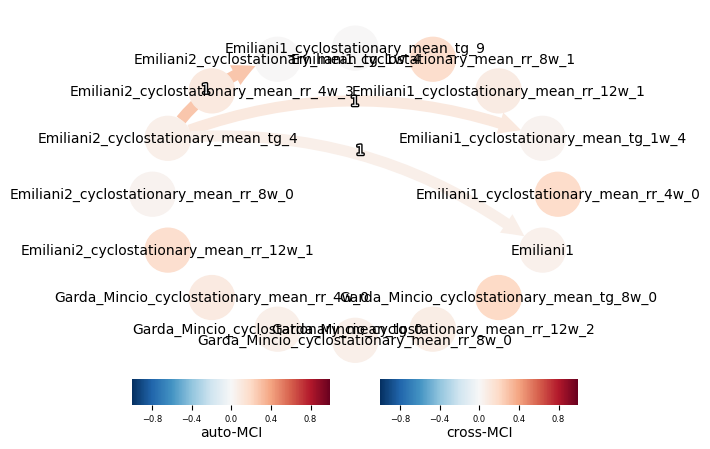

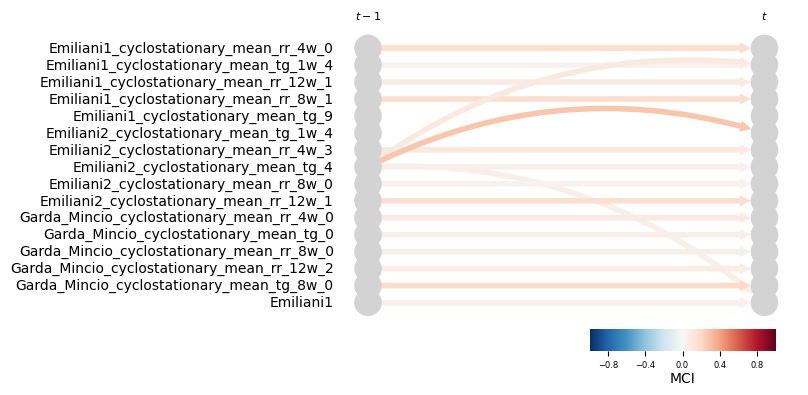

In [411]:
PCMCI_singleBasin(df,tau=1,cond_test=CMIknn())

### tau=2


## Significant links at alpha = 0.05:

    Variable 0 has 4 link(s):
        (0 -1): pval = 0.00000 | val =  0.346
        (4 -2): pval = 0.02080 | val =  0.094
        (0 -2): pval = 0.03598 | val = -0.085
        (1 -1): pval = 0.04152 | val = -0.083

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | val =  0.277

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.641
        (15 -2): pval = 0.00145 | val =  0.129
        (3 -2): pval = 0.00838 | val =  0.107
        (13 -2): pval = 0.02232 | val = -0.093

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.453

    Variable 4 has 0 link(s):

    Variable 5 has 3 link(s):
        (5 -1): pval = 0.00000 | val =  0.222
        (7 -2): pval = 0.00098 | val = -0.134
        (7 -1): pval = 0.03483 | val =  0.086

    Variable 6 has 5 link(s):
        (6 -1): pval = 0.00000 | val =  0.332
        (7 -1): pval = 0.00968 | val = -0.105
        (1 -1): pval = 0.01065 | val = -0.104
      

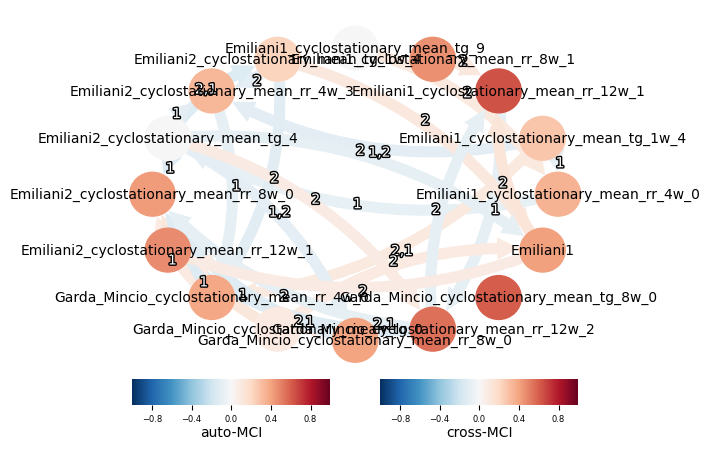

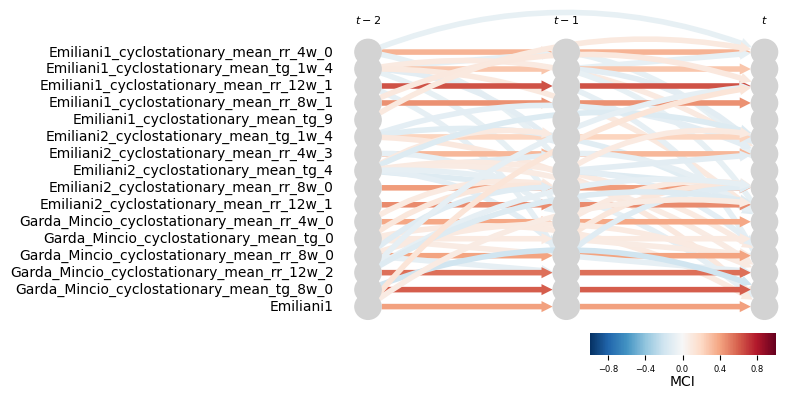

In [384]:
fullCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 2 link(s):
        (0 -1): pval = 0.01200 | val =  0.010
        (3 -1): pval = 0.03800 | val =  0.009

    Variable 1 has 0 link(s):

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.022

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.013

    Variable 4 has 0 link(s):

    Variable 5 has 1 link(s):
        (7 -1): pval = 0.00400 | val =  0.015

    Variable 6 has 1 link(s):
        (6 -1): pval = 0.00000 | val =  0.016

    Variable 7 has 0 link(s):

    Variable 8 has 1 link(s):
        (8 -1): pval = 0.03000 | val =  0.011

    Variable 9 has 1 link(s):
        (9 -1): pval = 0.00000 | val =  0.012

    Variable 10 has 1 link(s):
        (10 -1): pval = 0.00000 | val =  0.015

    Variable 11 has 0 link(s):

    Variable 12 has 1 link(s):
        (12 -1): pval = 0.00600 | val =  0.012

    Variable 13 has 1 link(s):
        (13 -1): pval = 0.00000 | val =  0.016

    Variable 

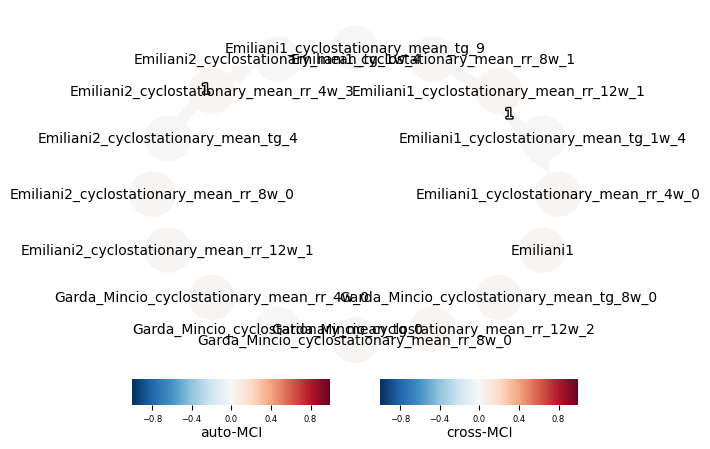

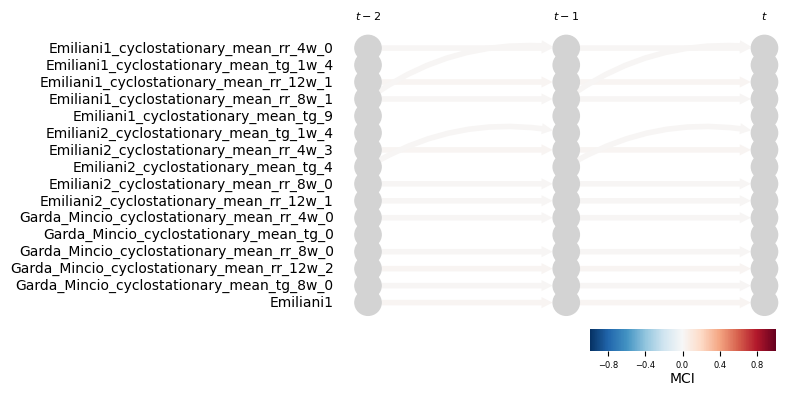

In [412]:
fullCI_singleBasin(df,tau=2,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (0 -1): pval = 0.00000 | val =  0.664
        (12 -1): pval = 0.01746 | val =  0.094
        (14 -1): pval = 0.02356 | val = -0.090
        (7 -1): pval = 0.02700 | val = -0.088
        (2 -1): pval = 0.03440 | val =  0.084
        (8 -1): pval = 0.04593 | val =  0.079

    Variable 1 has 8 link(s):
        (11 -1): pval = 0.00000 | val =  0.397
        (1 -1): pval = 0.00000 | val =  0.340
        (9 -2): pval = 0.01257 | val = -0.099
        (12 -2): pval = 0.01587 | val = -0.096
        (2 -2): pval = 0.01663 | val = -0.095
        (9 -1): pval = 0.01839 | val = -0.094
        (2 -1): pval = 0.02024 | val = -0.092
        (0 -2): pval = 0.03074 | val = -0.086

    Variable 2 has 9 link(s):
        (2 -1): pval = 0.00000 | val =  0.718
        (11 -1): pval = 0.01299 | val = -0.099
        (0 -2): pval = 0.01383 | val =  0.098
        (4 -1): pval = 0.01446 | val = -0.097
        (10 -1): pval = 0.02210 | v

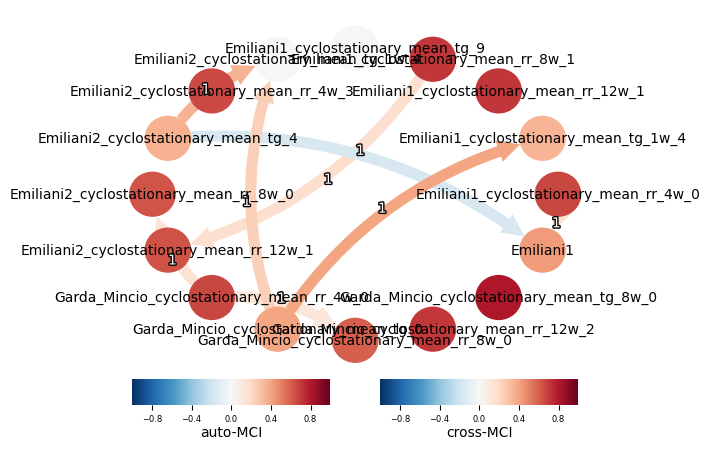

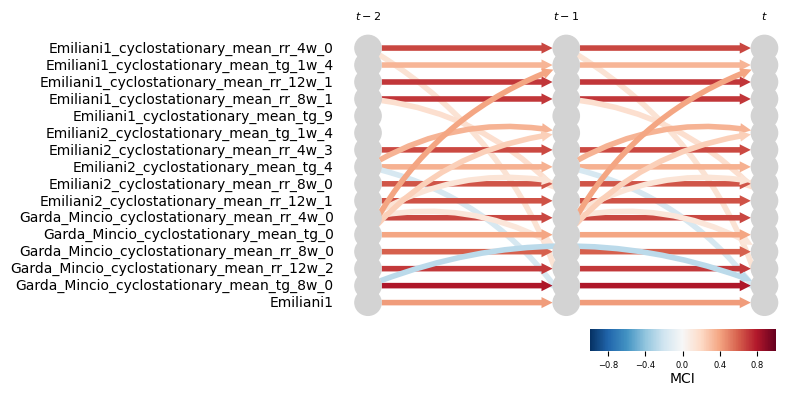

In [385]:
PCMCI_singleBasin(df,tau=2,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 7 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (5 -2): pval = 0.01200 | val =  0.015
        (5 -1): pval = 0.03000 | val =  0.014
        (1 -1): pval = 0.01400 | val =  0.013
        (2 -1): pval = 0.02000 | val =  0.012
        (1 -2): pval = 0.03200 | val =  0.012
        (8 -1): pval = 0.04200 | val =  0.010

    Variable 1 has 7 link(s):
        (11 -1): pval = 0.00000 | val =  0.275
        (1 -1): pval = 0.01200 | val =  0.029
        (2 -1): pval = 0.03200 | val =  0.025
        (9 -1): pval = 0.03800 | val =  0.024
        (13 -2): pval = 0.02400 | val =  0.022
        (5 -1): pval = 0.02400 | val =  0.019
        (0 -1): pval = 0.02400 | val =  0.013

    Variable 2 has 6 link(s):
        (2 -1): pval = 0.00000 | val =  0.164
        (7 -1): pval = 0.01200 | val =  0.023
        (1 -2): pval = 0.03600 | val =  0.021
        (12 -2): pval = 0.02200 | val =  0.021
        (8 -1): pval = 0.01200 | val 

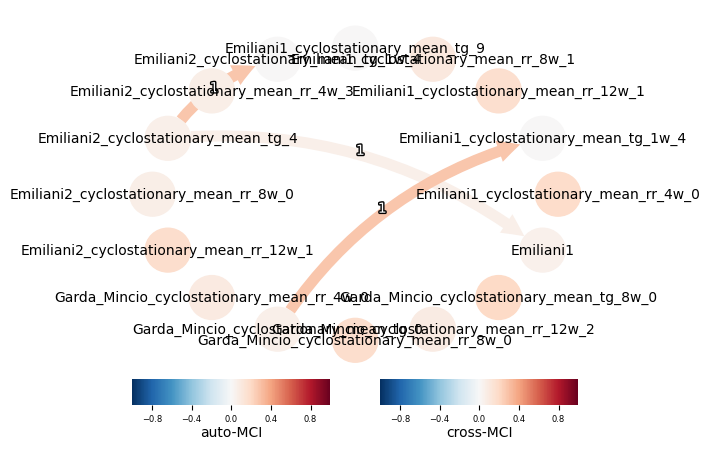

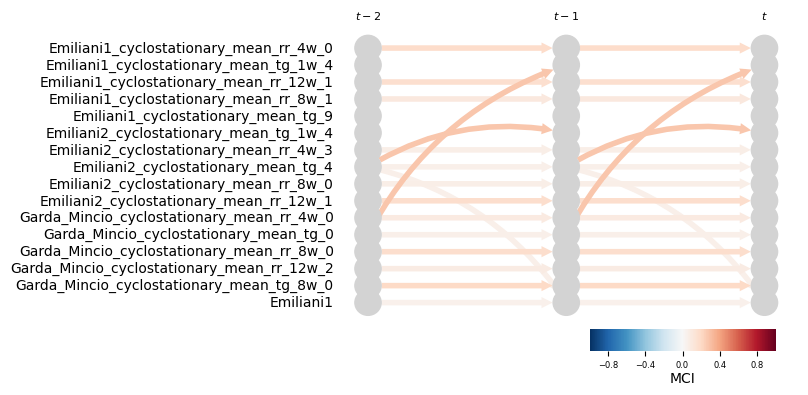

In [413]:
PCMCI_singleBasin(df,tau=2,cond_test=CMIknn())

### tau=3


## Significant links at alpha = 0.05:

    Variable 0 has 7 link(s):
        (0 -1): pval = 0.00000 | val =  0.316
        (0 -3): pval = 0.00375 | val = -0.120
        (4 -2): pval = 0.01127 | val =  0.105
        (2 -1): pval = 0.02447 | val =  0.093
        (5 -2): pval = 0.03866 | val = -0.086
        (11 -2): pval = 0.04170 | val = -0.084
        (6 -3): pval = 0.04447 | val =  0.083

    Variable 1 has 3 link(s):
        (1 -1): pval = 0.00000 | val =  0.296
        (1 -2): pval = 0.00057 | val = -0.142
        (1 -3): pval = 0.00143 | val =  0.132

    Variable 2 has 4 link(s):
        (2 -1): pval = 0.00000 | val =  0.593
        (3 -2): pval = 0.01430 | val =  0.101
        (15 -3): pval = 0.01680 | val =  0.099
        (7 -1): pval = 0.03901 | val = -0.085

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | val =  0.464
        (13 -3): pval = 0.01547 | val = -0.100
        (10 -1): pval = 0.04903 | val =  0.081

    Variable 4 has 0 link(s):

    Variable 5 has 

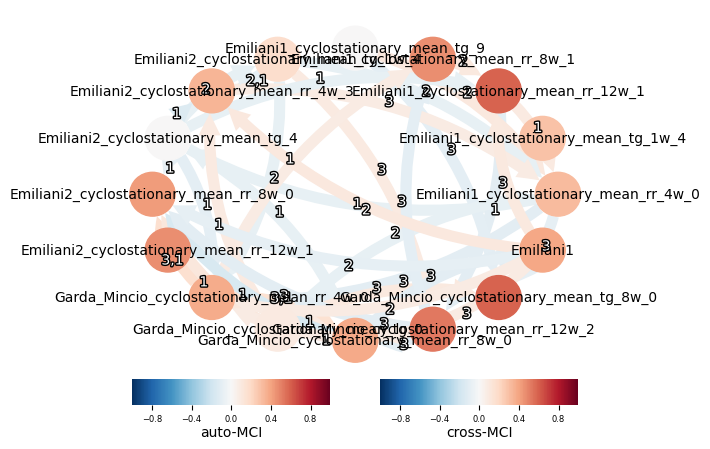

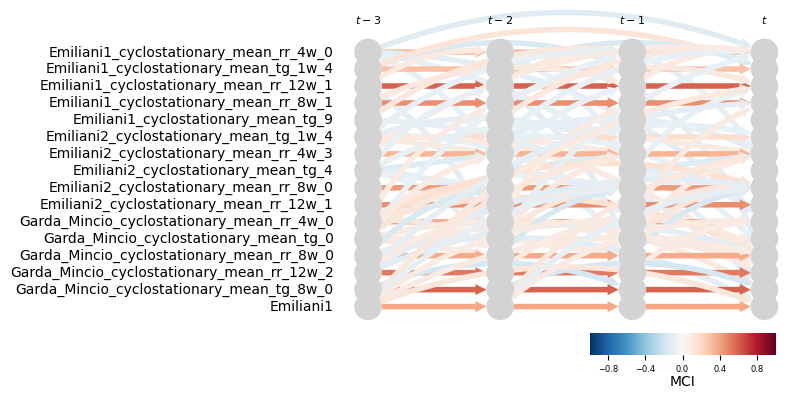

In [386]:
fullCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 0 link(s):

    Variable 1 has 0 link(s):

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | val =  0.016

    Variable 3 has 1 link(s):
        (3 -1): pval = 0.00000 | val =  0.012

    Variable 4 has 0 link(s):

    Variable 5 has 1 link(s):
        (7 -1): pval = 0.01200 | val =  0.014

    Variable 6 has 1 link(s):
        (6 -1): pval = 0.00000 | val =  0.015

    Variable 7 has 0 link(s):

    Variable 8 has 0 link(s):

    Variable 9 has 25 link(s):
        (9 -1): pval = 0.00200 | val =  0.011
        (6 -1): pval = 0.00400 | val =  0.008
        (10 -2): pval = 0.02800 | val =  0.008
        (12 -3): pval = 0.04000 | val =  0.008
        (6 -3): pval = 0.01000 | val =  0.008
        (7 -3): pval = 0.01800 | val =  0.008
        (1 -1): pval = 0.00400 | val =  0.008
        (5 -2): pval = 0.02200 | val =  0.008
        (7 -1): pval = 0.01400 | val =  0.008
        (2 -3): pval = 0.05000 | val =  0.008
    

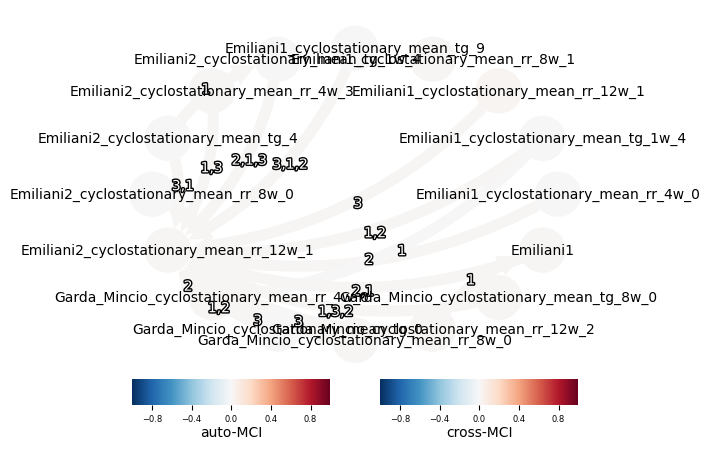

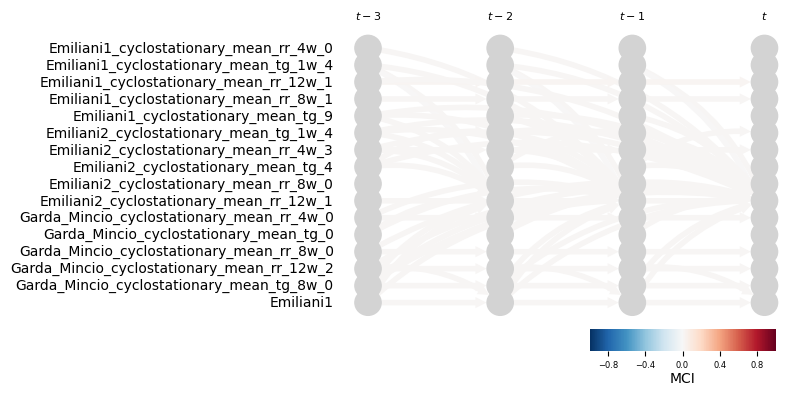

In [414]:
fullCI_singleBasin(df,tau=3,cond_test=CMIknn())


## Significant links at alpha = 0.05:

    Variable 0 has 7 link(s):
        (0 -1): pval = 0.00000 | val =  0.659
        (12 -1): pval = 0.01903 | val =  0.093
        (14 -1): pval = 0.02113 | val = -0.092
        (2 -1): pval = 0.02446 | val =  0.090
        (7 -1): pval = 0.02849 | val = -0.087
        (4 -3): pval = 0.03747 | val = -0.083
        (8 -1): pval = 0.04608 | val =  0.079

    Variable 1 has 14 link(s):
        (11 -1): pval = 0.00000 | val =  0.404
        (1 -1): pval = 0.00000 | val =  0.332
        (9 -2): pval = 0.01072 | val = -0.102
        (12 -2): pval = 0.01411 | val = -0.098
        (9 -1): pval = 0.01543 | val = -0.096
        (11 -3): pval = 0.01541 | val =  0.096
        (0 -3): pval = 0.01992 | val = -0.093
        (0 -2): pval = 0.02140 | val = -0.092
        (2 -1): pval = 0.02272 | val = -0.091
        (7 -3): pval = 0.02365 | val =  0.090
        (13 -3): pval = 0.03078 | val = -0.086
        (12 -3): pval = 0.03252 | val = -0.085
        (1 -3): p

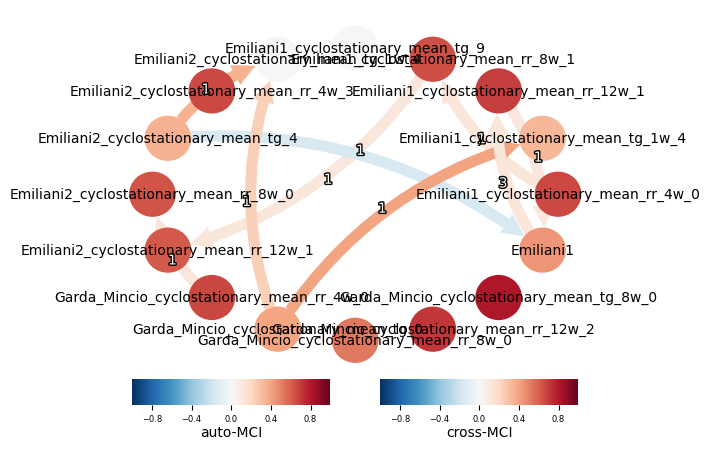

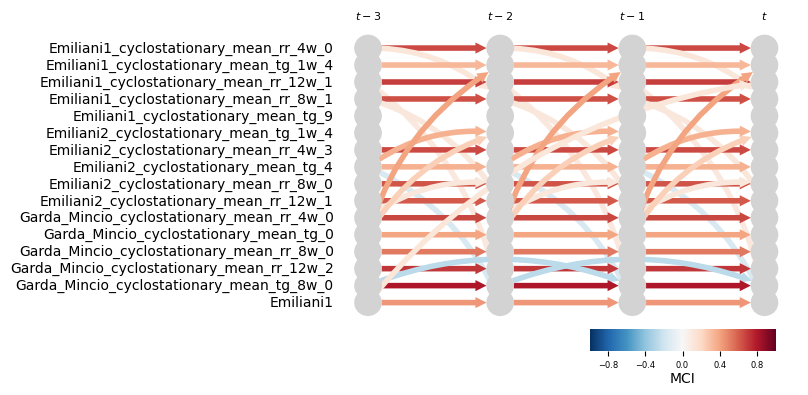

In [387]:
PCMCI_singleBasin(df,tau=3,cond_test=ParCorr())


## Significant links at alpha = 0.05:

    Variable 0 has 9 link(s):
        (0 -1): pval = 0.00000 | val =  0.182
        (4 -3): pval = 0.01400 | val =  0.016
        (5 -2): pval = 0.01600 | val =  0.015
        (5 -1): pval = 0.01400 | val =  0.014
        (11 -3): pval = 0.02800 | val =  0.014
        (1 -1): pval = 0.01800 | val =  0.014
        (1 -2): pval = 0.04000 | val =  0.012
        (2 -1): pval = 0.02400 | val =  0.012
        (2 -3): pval = 0.03600 | val =  0.011

    Variable 1 has 14 link(s):
        (11 -1): pval = 0.00000 | val =  0.275
        (1 -1): pval = 0.01800 | val =  0.029
        (9 -1): pval = 0.04200 | val =  0.026
        (2 -1): pval = 0.03600 | val =  0.025
        (3 -1): pval = 0.01800 | val =  0.024
        (13 -2): pval = 0.02400 | val =  0.022
        (13 -3): pval = 0.03000 | val =  0.021
        (5 -1): pval = 0.03000 | val =  0.020
        (1 -3): pval = 0.03000 | val =  0.017
        (4 -1): pval = 0.04800 | val =  0.015
        (5 -3): pval

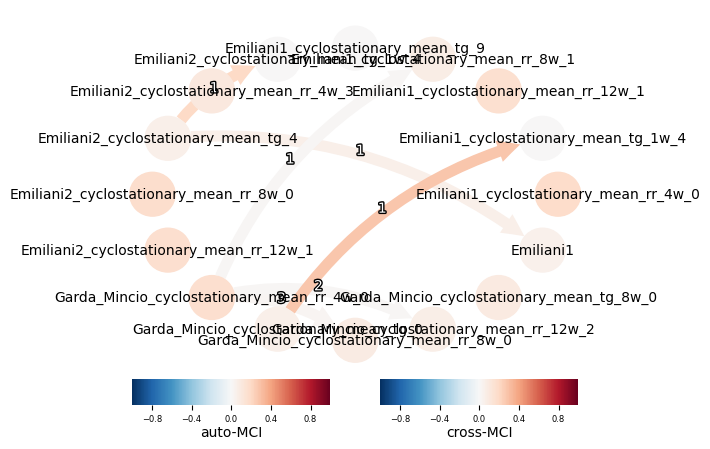

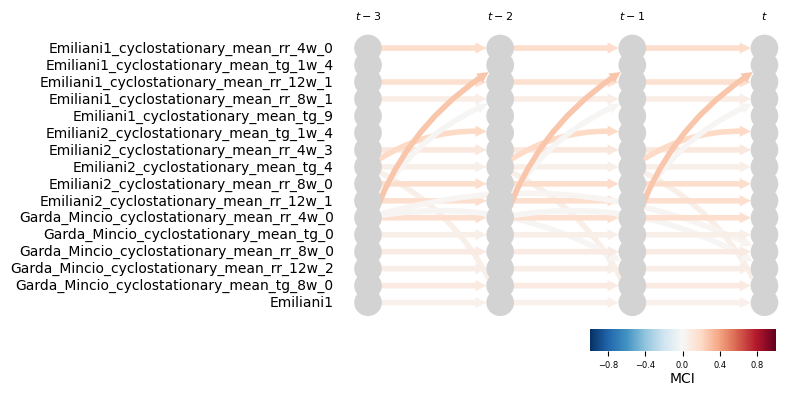

In [415]:
PCMCI_singleBasin(df,tau=3,cond_test=CMIknn())

## Regressions

In [417]:
### tau = 1
print('####### tau=1 ########')

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
x_test = best5_CMI_fulldf_test.iloc[1:,:].values
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],1),concatenate_past(x[:,1],1),concatenate_past(x[:,2],1),concatenate_past(x[:,3],1),concatenate_past(x[:,4],1),concatenate_past(x[:,5],1),concatenate_past(x[:,6],1),concatenate_past(x[:,7],1),concatenate_past(x[:,8],1),concatenate_past(x[:,9],1),concatenate_past(x[:,10],1),concatenate_past(x[:,11],1),concatenate_past(x[:,12],1),concatenate_past(x[:,13],1),concatenate_past(x[:,14],1)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],1),concatenate_past(x_test[:,1],1),concatenate_past(x_test[:,2],1),concatenate_past(x_test[:,3],1),concatenate_past(x_test[:,4],1),concatenate_past(x_test[:,5],1),concatenate_past(x_test[:,6],1),concatenate_past(x_test[:,7],1),concatenate_past(x_test[:,8],1),concatenate_past(x_test[:,9],1),concatenate_past(x_test[:,10],1),concatenate_past(x_test[:,11],1),concatenate_past(x_test[:,12],1),concatenate_past(x_test[:,13],1),concatenate_past(x_test[:,14],1)),axis=1)
y_lag1 = y[0:-1]
y_test_lag1 = y_test[0:-1]

reg_full = LinearRegression().fit(x_full, y[1:].reshape(-1,1))
print(f'Full regression, no target: {reg_full.score(x_full_test, y_test[1:].reshape(-1,1))}\n')

reg_full = LinearRegression().fit(x_full[:,[0,3,4,11,12]], y[1:].reshape(-1,1))
print(f'Regression with 0,3,4,11,12 no target: {reg_full.score(x_full_test[:,[0,3,4,11,12]], y_test[1:].reshape(-1,1))}\n')

reg_full = LinearRegression().fit(x_full[:,[0,2,3,11]], y[1:].reshape(-1,1))
print(f'Regression with 0,2,3,11 no target: {reg_full.score(x_full_test[:,[0,2,3,11]], y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1, y[1:].reshape(-1,1))
print(f'Only target (baseline): {reg.score(y_test_lag1, y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,7]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,7 and target: {reg.score(np.concatenate((x_full_test[:,[0,7]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[7]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 7 and target: {reg.score(np.concatenate((x_full_test[:,[7]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,2,3,11]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,2,3,11 and target: {reg.score(np.concatenate((x_full_test[:,[0,2,3,11]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,2,11]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,2,11 and target: {reg.score(np.concatenate((x_full_test[:,[0,2,11]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,11]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,11 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,11]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,5,7,12,14]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 2,5,7,12,14 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[2,5,7,12,14]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[12]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 12 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[12]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,7,10,12]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,1,2,7,10,12 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,1,2,7,10,12]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,2,7]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 0,2,7 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[0,2,7]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[2,7]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 2,7 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[2,7]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[5]],y_lag1),axis=1), y[1:].reshape(-1,1))
print(f'Regression with 5 and target (PCMCI): {reg.score(np.concatenate((x_full_test[:,[5]],y_test_lag1),axis=1), y_test[1:].reshape(-1,1))}\n')


####### tau=1 ########
Full regression, no target: 0.4204127093621798

Regression with 0,3,4,11,12 no target: 0.29306141117612294

Regression with 0,2,3,11 no target: 0.2902223728551553

Only target (baseline): 0.2756018203249285

Regression with 0,7 and target: 0.44500647720944553

Regression with 7 and target: 0.4305373393313586

Regression with 0,2,3,11 and target: 0.45711681353349276

Regression with 0,2,11 and target: 0.45737223108145453

Regression with 0,11 and target (PCMCI): 0.4427215697797532

Regression with 2,5,7,12,14 and target (PCMCI): 0.46148767413649205

Regression with 12 and target (PCMCI): 0.3183974032749647

Regression with 0,1,2,7,10,12 and target (PCMCI): 0.4361458968705537

Regression with 0,2,7 and target (PCMCI): 0.45538450592257007

Regression with 2,7 and target (PCMCI): 0.44375930016524534

Regression with 5 and target (PCMCI): 0.3765000418840717



In [420]:
print('####### tau=2 ########')
tau=2

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
x_test = best5_CMI_fulldf_test.iloc[1:,:].values
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau),concatenate_past(x[:,5],tau),concatenate_past(x[:,6],tau),concatenate_past(x[:,7],tau),concatenate_past(x[:,8],tau),concatenate_past(x[:,9],tau),concatenate_past(x[:,10],tau),concatenate_past(x[:,11],tau),concatenate_past(x[:,12],tau),concatenate_past(x[:,13],tau),concatenate_past(x[:,14],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau),concatenate_past(x_test[:,5],tau),concatenate_past(x_test[:,6],tau),concatenate_past(x_test[:,7],tau),concatenate_past(x_test[:,8],tau),concatenate_past(x_test[:,9],tau),concatenate_past(x_test[:,10],tau),concatenate_past(x_test[:,11],tau),concatenate_past(x_test[:,12],tau),concatenate_past(x_test[:,13],tau),concatenate_past(x_test[:,14],tau)),axis=1)
y_lag1_2 = np.concatenate((y[1:-1],y[:-2]),axis=1)
y_test_lag1_2 = np.concatenate((y_test[1:-1],y_test[:-2]),axis=1)

reg = LinearRegression().fit(x_full[:,[0,1,4,5,22,23]], y[2:].reshape(-1,1))
print(f'Regression with 0,2,11 no target: {reg.score(x_full_test[:,[0,1,4,5,22,23]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,22,23]], y[2:].reshape(-1,1))
print(f'Regression with 0,11 no target: {reg.score(x_full_test[:,[0,1,22,23]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,4,5]], y[2:].reshape(-1,1))
print(f'Regression with 0,2 no target: {reg.score(x_full_test[:,[0,1,4,5]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1]], y[2:].reshape(-1,1))
print(f'Regression with 0 no target: {reg.score(x_full_test[:,[0,1]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,6,7,8,9]], y[2:].reshape(-1,1))
print(f'Regression with 0,3,4, no target: {reg.score(x_full_test[:,[0,1,6,7,8,9]], y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2, y[2:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2, y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,14,15]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,7 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,14,15]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[14,15]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 7 and target: {reg.score(np.concatenate((x_full_test[:,[14,15]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,22,23]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,11 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,22,23]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[22,23]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 11 and target: {reg.score(np.concatenate((x_full_test[:,[22,23]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[10,11,14,15,22,23]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 5,7,11 and target: {reg.score(np.concatenate((x_full_test[:,[10,11,14,15,22,23]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[10,11,14,15]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 5,7 and target: {reg.score(np.concatenate((x_full_test[:,[10,11,14,15]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,4,5,14,15,18,19,26,27]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,2,7,9,13 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,4,5,14,15,18,19,26,27]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,4,5,14,15,18,19,20,21]],y_lag1_2),axis=1), y[2:].reshape(-1,1))
print(f'Regression with 0,2,7,9,10 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,4,5,14,15,18,19,20,21]],y_test_lag1_2),axis=1), y_test[2:].reshape(-1,1))}\n')




####### tau=2 ########
Regression with 0,2,11 no target: 0.2966961466943928

Regression with 0,11 no target: 0.23777251582186687

Regression with 0,2 no target: 0.18927471423846576

Regression with 0 no target: 0.1480503778768928

Regression with 0,3,4, no target: 0.2573994198178893

Only target: 0.27767275761477295

Regression with 0,7 and target: 0.428132087281725

Regression with 7 and target: 0.40977020879886483

Regression with 0,11 and target: 0.4171355660491566

Regression with 11 and target: 0.36485309654893994

Regression with 5,7,11 and target: 0.46819250891389097

Regression with 5,7 and target: 0.4637861532732529

Regression with 0,2,7,9,13 and target: 0.420807944144176

Regression with 0,2,7,9,10 and target: 0.41369543572658973



In [425]:
print('####### tau=3 ########')
tau=3

## full regression without target
x = best5_CMI_fulldf_trainVal.iloc[1:,:].values
x_test = best5_CMI_fulldf_test.iloc[1:,:].values
y = targets_df_trainVal.iloc[:-1,0].values.reshape(-1,1)
y_test = targets_df_test.iloc[:-1,0].values.reshape(-1,1)

x_full = np.concatenate((concatenate_past(x[:,0],tau),concatenate_past(x[:,1],tau),concatenate_past(x[:,2],tau),concatenate_past(x[:,3],tau),concatenate_past(x[:,4],tau),concatenate_past(x[:,5],tau),concatenate_past(x[:,6],tau),concatenate_past(x[:,7],tau),concatenate_past(x[:,8],tau),concatenate_past(x[:,9],tau),concatenate_past(x[:,10],tau),concatenate_past(x[:,11],tau),concatenate_past(x[:,12],tau),concatenate_past(x[:,13],tau),concatenate_past(x[:,14],tau)),axis=1)
x_full_test = np.concatenate((concatenate_past(x_test[:,0],tau),concatenate_past(x_test[:,1],tau),concatenate_past(x_test[:,2],tau),concatenate_past(x_test[:,3],tau),concatenate_past(x_test[:,4],tau),concatenate_past(x_test[:,5],tau),concatenate_past(x_test[:,6],tau),concatenate_past(x_test[:,7],tau),concatenate_past(x_test[:,8],tau),concatenate_past(x_test[:,9],tau),concatenate_past(x_test[:,10],tau),concatenate_past(x_test[:,11],tau),concatenate_past(x_test[:,12],tau),concatenate_past(x_test[:,13],tau),concatenate_past(x_test[:,14],tau)),axis=1)
y_lag1_2_3 = np.concatenate((y[2:-1],y[1:-2],y[:-3]),axis=1)
y_test_lag1_2_3 = np.concatenate((y_test[2:-1],y_test[1:-2],y_test[:-3]),axis=1)

reg = LinearRegression().fit(x_full[:,[0,1,2,15,16,17]], y[3:].reshape(-1,1))
print(f'Regression with 0,5 no target: {reg.score(x_full_test[:,[0,1,2,15,16,17]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[0,1,2]], y[3:].reshape(-1,1))
print(f'Regression with 0 no target: {reg.score(x_full_test[:,[0,1,2]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[3,4,5,6,7,8,9,10,11,24,25,26]], y[3:].reshape(-1,1))
print(f'Regression with 1,2,3,12 no target: {reg.score(x_full_test[:,[3,4,5,6,7,8,9,10,11,24,25,26]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(x_full[:,[3,4,5]], y[3:].reshape(-1,1))
print(f'Regression with 1 no target: {reg.score(x_full_test[:,[3,4,5]], y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(y_lag1_2_3, y[3:].reshape(-1,1))
print(f'Only target: {reg.score(y_test_lag1_2_3, y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[21,22,23]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 7 and target: {reg.score(np.concatenate((x_full_test[:,[21,22,23]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[33,34,35]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 11 and target: {reg.score(np.concatenate((x_full_test[:,[33,34,35]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[36,37,38]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 12 and target: {reg.score(np.concatenate((x_full_test[:,[36,37,38]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,6,7,8,21,22,23,27,28,29,30,31,32,39,40,41]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,2,7,9,10,13 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,6,7,8,21,22,23,27,28,29,30,31,32,39,40,41]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[6,7,8,21,22,23]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 7,2 and target: {reg.score(np.concatenate((x_full_test[:,[6,7,8,21,22,23]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[39,40,41]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 13 and target: {reg.score(np.concatenate((x_full_test[:,[39,40,41]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')

reg = LinearRegression().fit(np.concatenate((x_full[:,[0,1,2,21,22,23,36,37,38,39,40,41]],y_lag1_2_3),axis=1), y[3:].reshape(-1,1))
print(f'Regression with 0,7,12,13 and target: {reg.score(np.concatenate((x_full_test[:,[0,1,2,21,22,23,36,37,38,39,40,41]],y_test_lag1_2_3),axis=1), y_test[3:].reshape(-1,1))}\n')



####### tau=3 ########
Regression with 0,5 no target: 0.2825009883256778

Regression with 0 no target: 0.13936709832577088

Regression with 1,2,3,12 no target: 0.3585998505429292

Regression with 1 no target: 0.3309826528469879

Only target: 0.26575741114516516

Regression with 7 and target: 0.4679302557308437

Regression with 11 and target: 0.4283224839367944

Regression with 12 and target: 0.3160263689868945

Regression with 0,2,7,9,10,13 and target: 0.4774211374893478

Regression with 7,2 and target: 0.4795580662933221

Regression with 13 and target: 0.287300006180328

Regression with 0,7,12,13 and target: 0.48524480289405747

